In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
from datetime import datetime, timedelta
import yfinance as yf
from IPython.display import display
from lets_plot import *

from IPython.display import display
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA #non-linear model, alternatively, t-stochastic neighborhood embedding, UMAP

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix
from lets_plot import *
LetsPlot.setup_html()  # Enable Lets-Plot for notebooks
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

In [2]:
import os

cache_file = "spy_raw_cache.csv"

if os.path.exists(cache_file):
    spy_raw = pd.read_csv(cache_file, index_col=0, parse_dates=True)
else:
    spy_raw = (
        yf
        .download(["SPY"],
                  start=dt.datetime(2006, 11, 1),
                  end=dt.datetime(2025, 11, 13),
                  auto_adjust=True
                 )
    )
    
    # Ensure index is datetime and is one-level
    spy_raw.index = pd.to_datetime(spy_raw.index)
    display(spy_raw)

    # Convert to 1-level columns if necessary
    if spy_raw.columns.nlevels > 1:
        spy_raw.columns = spy_raw.columns.droplevel(1)
    print("columns: ", spy_raw.columns.nlevels)
    display(spy_raw)

    spy_raw.to_csv(cache_file)

In [3]:
# ============================================================
# PHASE 1: EXPLORATORY CLUSTERING ANALYSIS
# ============================================================

In [4]:
def add_clustering_features(df):
    df = df.copy()
    
    # Returns (both types for comparison)
    df['returns_simple'] = df['Adj_Close'].pct_change()  # Simple: (P_t - P_{t-1}) / P_{t-1}
    df['returns_log'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))  # Log: ln(P_t / P_{t-1})
    
    # Use log returns for volatility (more theoretically sound)
    df['returns'] = df['returns_log']
    
    # Multiple volatility timeframes (short to long)
    volatility_windows = [3, 5, 10, 20, 30, 60, 90]
    for window in volatility_windows:
        df[f'volatility_{window}'] = df['returns'].rolling(window).std() * np.sqrt(252) * 100
    
    # ATR with multiple windows
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    for window in [3, 5, 7, 14, 21, 30]:  # Multiple ATR windows
        df[f'ATR_{window}'] = true_range.rolling(window).mean()
        df[f'ATR_{window}_pct'] = (df[f'ATR_{window}'] / df['Close']) * 100
    
    # Volume features (multiple windows)
    df['high_low_range'] = (df['High'] - df['Low']) / df['Close'] * 100  # Calculate range first
    
    volume_windows = [3, 5, 10, 20, 30, 60]
    for window in volume_windows:
        df[f'volume_ma{window}'] = df['Volume'].rolling(window).mean()
        df[f'volume_ratio_{window}'] = df['Volume'] / df[f'volume_ma{window}']
        df[f'volume_std_{window}'] = df['Volume'].rolling(window).std()
    
    # Create alias for backward compatibility (default to 20-day)
    df['volume_ratio'] = df['volume_ratio_20']  # Used in feature_cols below
    
    # Price range features (multiple windows)
    range_windows = [3, 5, 10, 20, 30, 60]
    for window in range_windows:
        df[f'range_ma{window}'] = df['high_low_range'].rolling(window).mean()
        df[f'range_std{window}'] = df['high_low_range'].rolling(window).std()
    
    return df

spy = spy_raw.copy()
spy["Adj_Close"] = spy["Close"]

# Split into train/test (75/25)
total_rows = len(spy)
train_size = int(total_rows * 0.75)
spy_train = spy.iloc[:train_size].copy()
spy_test = spy.iloc[train_size:].copy()

print(f"Training set: {len(spy_train)} rows ({spy_train.index[0]} to {spy_train.index[-1]})")
print(f"Test set: {len(spy_test)} rows ({spy_test.index[0]} to {spy_test.index[-1]})")

# Add features
spy_train_features = add_clustering_features(spy_train)
display(spy_train_features)
print("\n" + "="*70)
print("FEATURES ADDED FOR CLUSTERING")
print("="*70)
feature_cols = ['volatility_20', 'volatility_60', 'ATR_14', 'ATR_14_pct', 
                'volume_ratio', 'high_low_range', 'range_ma20']
print("\nFeature Summary Statistics:")
display(spy_train_features[feature_cols].describe())

# Show all volatility windows
print("\nAll Volatility Windows:")
vol_cols = [col for col in spy_train_features.columns if col.startswith('volatility_')]
display(spy_train_features[vol_cols].describe())

# Show all ATR windows
print("\nAll ATR Windows (%):")
atr_cols = [col for col in spy_train_features.columns if col.startswith('ATR_') and col.endswith('_pct')]
display(spy_train_features[atr_cols].describe())

# Show all volume ratio windows
print("\nAll Volume Ratio Windows:")
vol_ratio_cols = [col for col in spy_train_features.columns if col.startswith('volume_ratio_')]
display(spy_train_features[vol_ratio_cols].describe())

# Show all range MA windows
print("\nAll Range Moving Average Windows:")
range_cols = [col for col in spy_train_features.columns if col.startswith('range_ma') and col != 'range_ma20']
range_cols = ['range_ma5', 'range_ma10', 'range_ma20', 'range_ma30', 'range_ma60']
display(spy_train_features[range_cols].describe())

# Compare simple vs log returns
print("\n" + "="*70)
print("SIMPLE vs LOG RETURNS COMPARISON")
print("="*70)
comparison = pd.DataFrame({
    'Simple Returns': spy_train_features['returns_simple'].describe(),
    'Log Returns': spy_train_features['returns_log'].describe(),
    'Difference': spy_train_features['returns_simple'].describe() - spy_train_features['returns_log'].describe()
})
display(comparison)
print("\nKey Observations:")
print("• Differences are very small for daily returns (~0.01%)")
print("• Log returns are more symmetric (mean closer to median)")
print("• Using log returns for volatility calculations (theoretically correct)")
print("="*70)

Training set: 3591 rows (2006-11-01 00:00:00 to 2021-02-08 00:00:00)
Test set: 1197 rows (2021-02-09 00:00:00 to 2025-11-12 00:00:00)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,volume_ratio_60,volume_std_60,volume_ratio,range_ma3,range_std3,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-11-01,95.973610,96.990426,95.875435,96.927316,83005600,95.973610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100,95.917526,-0.000584,-0.000585,-0.000585,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,95.749207,96.345277,95.104054,96.261130,71346400,95.749207,-0.001755,-0.001756,-0.001756,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.977769,0.440397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,96.829124,96.969373,96.036704,96.043724,63303300,96.829124,0.011279,0.011215,0.011215,11.389941,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.911583,0.412985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,97.200806,97.460266,96.773040,96.913289,63318900,97.200806,0.003839,0.003831,0.003831,10.328964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.988851,0.295491,0.920707,0.333593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-02,357.220245,358.783769,352.323757,355.441406,64450700,357.220245,0.014140,0.014041,0.014041,32.592836,31.323262,22.316268,17.232993,15.057025,13.940104,...,0.939515,2.637800e+07,0.899947,1.976063,0.255270,1.949425,0.286303,1.409913,0.683272,1.228286,0.580042,1.244370,0.881388,1.126264,0.713290
2021-02-03,357.501160,359.233199,356.218523,358.053535,52427100,357.501160,0.000786,0.000786,0.000786,13.422709,23.480799,21.121929,17.126187,14.983573,13.455639,...,0.769782,2.639929e+07,0.739283,1.500535,0.569592,1.674179,0.524341,1.387437,0.699277,1.210529,0.586406,1.235189,0.884173,1.124472,0.713873
2021-02-04,361.564514,361.611314,357.613602,358.540466,47142600,361.564514,0.011366,0.011302,0.011302,11.107905,23.897641,21.948709,17.417435,15.196731,13.598702,...,0.696937,2.652081e+07,0.694566,1.252448,0.499035,1.575425,0.584933,1.453761,0.627453,1.160606,0.547539,1.123166,0.639796,1.124527,0.713871



FEATURES ADDED FOR CLUSTERING

Feature Summary Statistics:


,volatility_20,volatility_60,ATR_14,ATR_14_pct,volume_ratio,high_low_range,range_ma20
count,3571.000000,3531.000000,3578.000000,3578.000000,3572.000000,3591.000000,3572.000000
mean,16.470803,17.240107,2.071115,1.416202,1.009952,1.291616,1.292995
std,12.521268,11.439693,1.682990,1.039859,0.358067,1.143106,0.912768
min,3.186031,4.978634,0.541453,0.337144,0.181372,0.122910,0.358516
25%,9.030378,10.909643,1.186687,0.814116,0.772866,0.630448,0.770713
50%,13.301498,13.780025,1.565546,1.115396,0.941159,0.962443,1.016517
75%,19.650329,19.616181,2.237225,1.637520,1.156085,1.526074,1.509047
max,93.971520,75.584303,18.332011,9.412922,3.710790,11.706215,7.574218



All Volatility Windows:


,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,volatility_90
count,3588.000000,3586.000000,3581.000000,3571.000000,3561.000000,3531.000000,3501.000000
mean,14.799636,15.543161,16.113137,16.470803,16.718975,17.240107,17.587781
std,15.407864,14.165306,13.184796,12.521268,12.150342,11.439693,10.960746
min,0.295599,0.675419,2.005983,3.186031,3.512028,4.978634,5.499746
25%,5.974277,7.272795,8.388259,9.030378,9.734778,10.909643,11.495740
50%,10.459942,11.837401,12.634899,13.301498,13.157590,13.780025,14.253699
75%,18.449670,18.873733,19.178405,19.650329,19.943001,19.616181,19.433599
max,191.969020,146.164397,113.063367,93.971520,86.487431,75.584303,64.635576



All ATR Windows (%):


,ATR_3_pct,ATR_5_pct,ATR_7_pct,ATR_14_pct,ATR_21_pct,ATR_30_pct
count,3589.000000,3587.000000,3585.000000,3578.000000,3571.000000,3562.000000
mean,1.416688,1.416765,1.416754,1.416202,1.415765,1.414894
std,1.122592,1.091703,1.074481,1.039859,1.012791,0.985410
min,0.222901,0.236979,0.269824,0.337144,0.365169,0.365391
25%,0.764248,0.785841,0.798007,0.814116,0.841312,0.864558
50%,1.103963,1.109935,1.111208,1.115396,1.112507,1.105817
75%,1.656068,1.662908,1.664285,1.637520,1.661598,1.657054
max,11.630770,11.584106,10.345331,9.412922,8.943539,8.348136



All Volume Ratio Windows:


,volume_ratio_3,volume_ratio_5,volume_ratio_10,volume_ratio_20,volume_ratio_30,volume_ratio_60
count,3589.000000,3587.000000,3582.000000,3572.000000,3562.000000,3532.000000
mean,1.001329,1.003800,1.006514,1.009952,1.011791,1.013758
std,0.203699,0.250988,0.302335,0.358067,0.391362,0.437769
min,0.275905,0.257823,0.214012,0.181372,0.147778,0.137916
25%,0.862257,0.830654,0.805497,0.772866,0.759912,0.736214
50%,0.985848,0.972957,0.960184,0.941159,0.928093,0.906140
75%,1.121466,1.141530,1.154252,1.156085,1.161633,1.170435
max,1.981109,2.456452,3.329876,3.710790,3.999373,4.902457



All Range Moving Average Windows:


,range_ma5,range_ma10,range_ma20,range_ma30,range_ma60
count,3587.000000,3582.000000,3572.000000,3562.000000,3532.000000
mean,1.292122,1.292220,1.292995,1.293927,1.297167
std,1.000924,0.957829,0.912768,0.879643,0.807780
min,0.235142,0.319665,0.358516,0.349658,0.419094
25%,0.716663,0.740873,0.770713,0.790226,0.831885
50%,0.998866,1.018300,1.016517,1.027566,1.042598
75%,1.504337,1.505224,1.509047,1.517799,1.480961
max,10.361442,8.787977,7.574218,6.742896,5.866708



SIMPLE vs LOG RETURNS COMPARISON


,Simple Returns,Log Returns,Difference
count,3590.000000,3590.000000,0.000000e+00
mean,0.000456,0.000373,8.349778e-05
std,0.012909,0.012926,-1.663073e-05
min,-0.109424,-0.115887,6.462820e-03
25%,-0.003831,-0.003839,7.358843e-06
50%,0.000706,0.000706,2.493516e-07
75%,0.005868,0.005851,1.714798e-05
max,0.145198,0.135578,9.620482e-03



Key Observations:
• Differences are very small for daily returns (~0.01%)
• Log returns are more symmetric (mean closer to median)
• Using log returns for volatility calculations (theoretically correct)


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import cluster

print("\n" + "="*70)
print("STEP 1: PREPARE FEATURES FOR CLUSTERING")
print("="*70)

# Select features for clustering (4 key features like professor used Returns + Volatility)
feature_cols = ['volatility_20', 'ATR_14_pct', 'volume_ratio_20', 'range_ma20']
feature_cols = ['volatility_5', 'ATR_5_pct', 'volume_ratio_5', 'range_ma5']

X = spy_train_features[feature_cols].dropna()

print(f"\nClustering {len(X)} trading days")
print(f"Date range: {X.index[0]} to {X.index[-1]}")
print(f"Features: {feature_cols}")


STEP 1: PREPARE FEATURES FOR CLUSTERING

Clustering 3586 trading days
Date range: 2006-11-08 00:00:00 to 2021-02-08 00:00:00
Features: ['volatility_5', 'ATR_5_pct', 'volume_ratio_5', 'range_ma5']


In [6]:
# Standardize features (critical for K-means!)
print("\n" + "="*70)
print("STEP 2: STANDARDIZE FEATURES")
print("="*70)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("\nBefore Scaling:")
display(X.describe())

print("\nAfter Scaling (mean=0, std=1):")
display(X_scaled_df.describe())


STEP 2: STANDARDIZE FEATURES

Before Scaling:


,volatility_5,ATR_5_pct,volume_ratio_5,range_ma5
count,3586.000000,3586.000000,3586.000000,3586.000000
mean,15.543161,1.416890,1.003822,1.292226
std,14.165306,1.091830,0.251020,1.001045
min,0.675419,0.236979,0.257823,0.235142
25%,7.272795,0.785732,0.830645,0.716611
50%,11.837401,1.110241,0.972983,0.999008
75%,18.873733,1.663563,1.141559,1.504483
max,146.164397,11.584106,2.456452,10.361442



After Scaling (mean=0, std=1):


,volatility_5,ATR_5_pct,volume_ratio_5,range_ma5
count,3.586000e+03,3.586000e+03,3.586000e+03,3.586000e+03
mean,-1.268119e-16,3.170297e-17,3.333765e-16,1.585148e-16
std,1.000139e+00,1.000139e+00,1.000139e+00,1.000139e+00
min,-1.049735e+00,-1.080823e+00,-2.972289e+00,-1.056129e+00
25%,-5.839281e-01,-5.781541e-01,-6.899881e-01,-5.750948e-01
50%,-2.616447e-01,-2.808963e-01,-1.228719e-01,-2.929532e-01
75%,2.351545e-01,2.259580e-01,5.487884e-01,2.120653e-01
max,9.222494e+00,9.313387e+00,5.787725e+00,9.061017e+00



STEP 3: ELBOW METHOD - FINDING OPTIMAL K


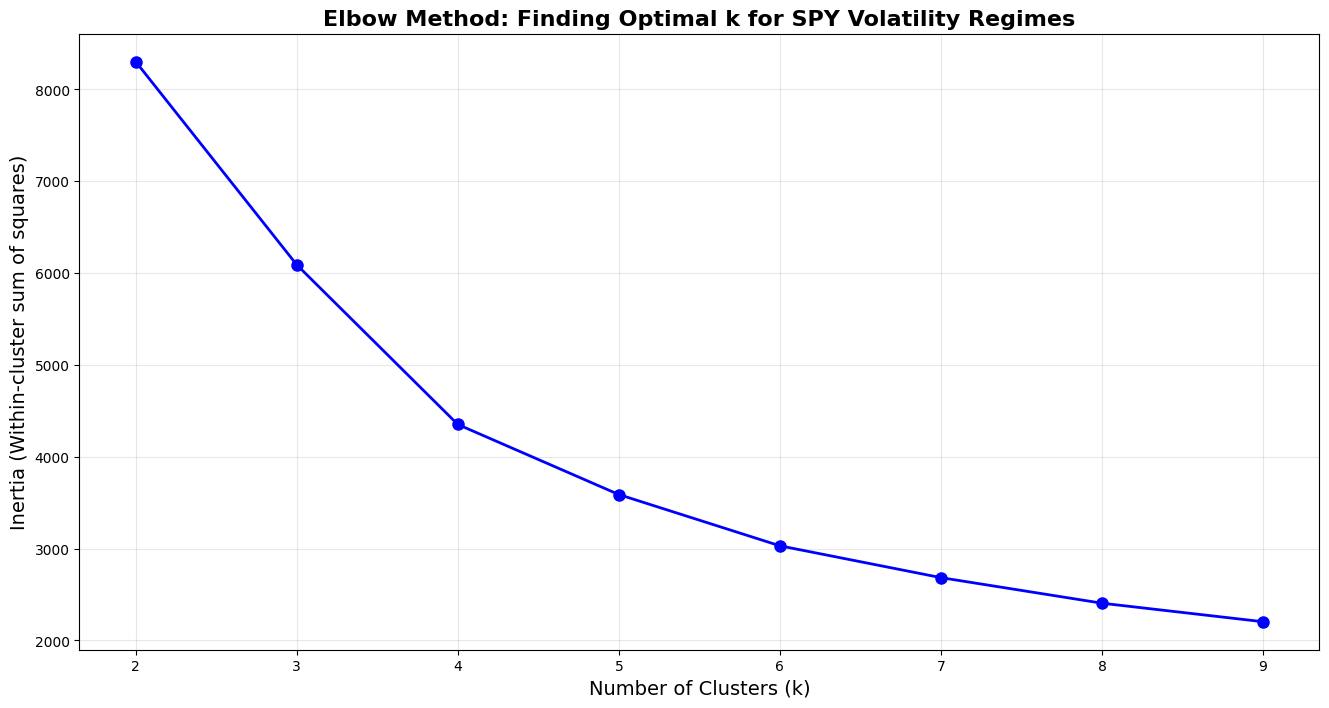

In [7]:
# ============================================================
# ELBOW METHOD - Find optimal k (Professor's approach)
# ============================================================

print("\n" + "="*70)
print("STEP 3: ELBOW METHOD - FINDING OPTIMAL K")
print("="*70)

distortions = []  # Inertia values
max_loop = 10

for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=627, n_init=10)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(16, 8))
plt.plot(range(2, max_loop), distortions, 'bo-', linewidth=2, markersize=8)
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=14)
plt.title('Elbow Method: Finding Optimal k for SPY Volatility Regimes', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


STEP 4: SILHOUETTE ANALYSIS
k=2: Silhouette Score = 0.6564
k=3: Silhouette Score = 0.3995
k=4: Silhouette Score = 0.3707
k=5: Silhouette Score = 0.3693
k=6: Silhouette Score = 0.3260
k=7: Silhouette Score = 0.3159
k=8: Silhouette Score = 0.3234
k=9: Silhouette Score = 0.2895


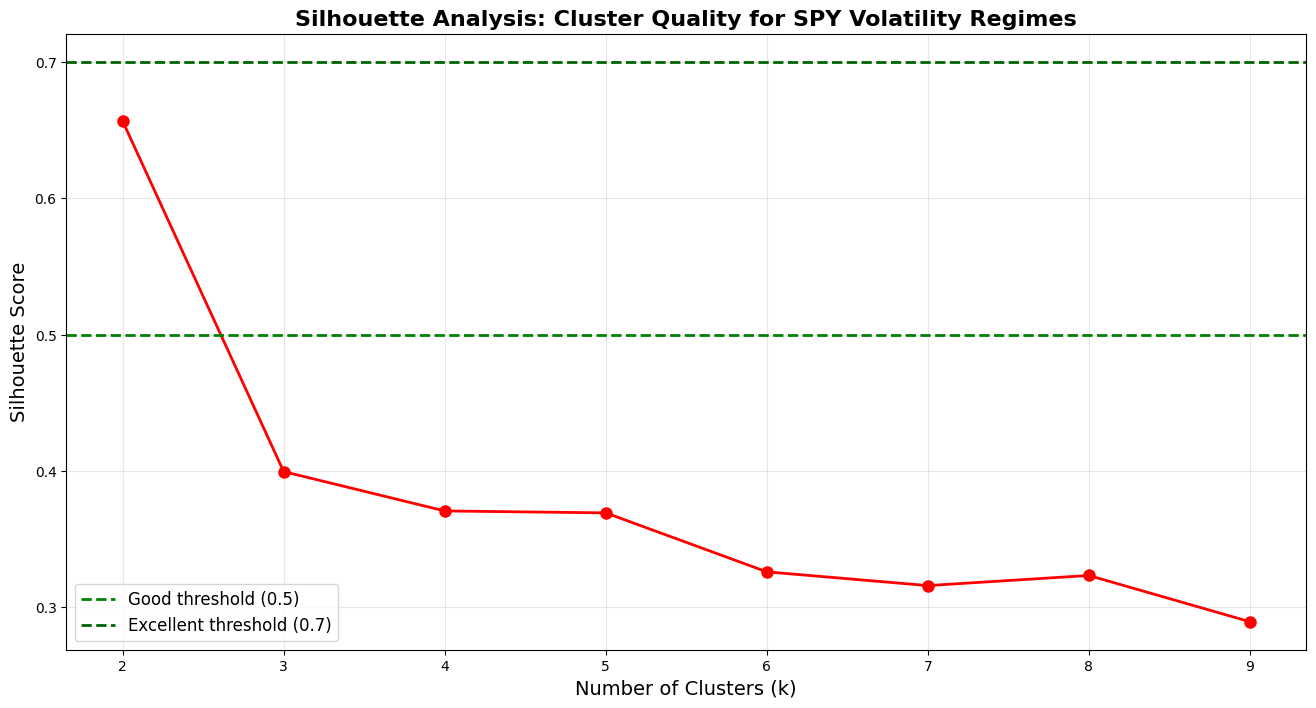


RECOMMENDED k = 2 (highest silhouette score: 0.6564)


In [8]:
# ============================================================
# SILHOUETTE SCORE - Validate cluster quality (Professor's approach)
# ============================================================

print("\n" + "="*70)
print("STEP 4: SILHOUETTE ANALYSIS")
print("="*70)

silhouette_scores = []

for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=627, n_init=10)
    kmeans.fit(X_scaled)
    score = metrics.silhouette_score(X_scaled, kmeans.labels_, random_state=627)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")
        
fig = plt.figure(figsize=(16, 8))
plt.plot(range(2, max_loop), silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Analysis: Cluster Quality for SPY Volatility Regimes', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Good threshold (0.5)')
plt.axhline(y=0.7, color='darkgreen', linestyle='--', linewidth=2, label='Excellent threshold (0.7)')
plt.legend(fontsize=12)
plt.show()

# Find best k
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\n{'='*70}")
print(f"RECOMMENDED k = {best_k} (highest silhouette score: {max(silhouette_scores):.4f})")
print(f"{'='*70}")

In [9]:
print("\n" + "="*70)
print("STEP 5: FIT FINAL K-MEANS MODEL")
print("="*70)

# ============================================================
# CHOOSE NUMBER OF CLUSTERS
# ============================================================
# Option 1: Use automatic selection (highest silhouette score)
nclust = best_k  
nclust = 5
# Option 2: Override with manual selection (comment out line above, uncomment one below)
# nclust = 2  # Use this for Low Vol vs High Vol (binary regime)
# nclust = 3  # Use this for Low/Med/High Vol (most common choice)
# nclust = 4  # Use this for more granular regimes
# nclust = 5  # Use this if elbow shows 5 clusters
# nclust = 6  # Use this if following professor's approach (elbow method)

print(f"\nSelected k = {nclust} (automatic selection based on silhouette score)")
print(f"To manually override, uncomment desired 'nclust = X' line above")
print(f"\nFitting K-Means with k={nclust} clusters...")

k_means = cluster.KMeans(n_clusters=nclust, random_state=627, n_init=10)
k_means.fit(X_scaled)

# Extract labels and centroids
target_labels = k_means.predict(X_scaled)
centroids = k_means.cluster_centers_

print(f"✓ Clustering complete!")
print(f"  Cluster labels: {np.unique(target_labels)}")
print(f"  Centroids shape: {centroids.shape}")


STEP 5: FIT FINAL K-MEANS MODEL

Selected k = 5 (automatic selection based on silhouette score)
To manually override, uncomment desired 'nclust = X' line above

Fitting K-Means with k=5 clusters...
✓ Clustering complete!
  Cluster labels: [0 1 2 3 4]
  Centroids shape: (5, 4)


In [10]:
# Add regime labels to dataframe and sort by volatility
spy_train_features.loc[X.index, 'regime'] = target_labels

# Sort regimes by volatility (0=Low, 1=Med, 2=High, etc.)
# Use first feature (volatility) from feature_cols for sorting
volatility_col = feature_cols[0]  # e.g., 'volatility_5' or 'volatility_20'
regime_volatility = spy_train_features.groupby('regime')[volatility_col].mean().sort_values()
regime_mapping = {old: new for new, old in enumerate(regime_volatility.index)}
spy_train_features['regime'] = spy_train_features['regime'].map(regime_mapping)

print(f"\nRegimes sorted by average volatility:")
for old_label, new_label in sorted(regime_mapping.items(), key=lambda x: x[1]):
    avg_vol = regime_volatility[old_label]
    print(f"  Regime {new_label} (was {old_label}): {avg_vol:.2f}% volatility")


Regimes sorted by average volatility:
  Regime 0 (was 0.0): 9.26% volatility
  Regime 1 (was 3.0): 11.41% volatility
  Regime 2 (was 4.0): 23.77% volatility
  Regime 3 (was 1.0): 47.37% volatility
  Regime 4 (was 2.0): 95.52% volatility



STEP 6: VISUALIZE CLUSTERS (2D SCATTER)


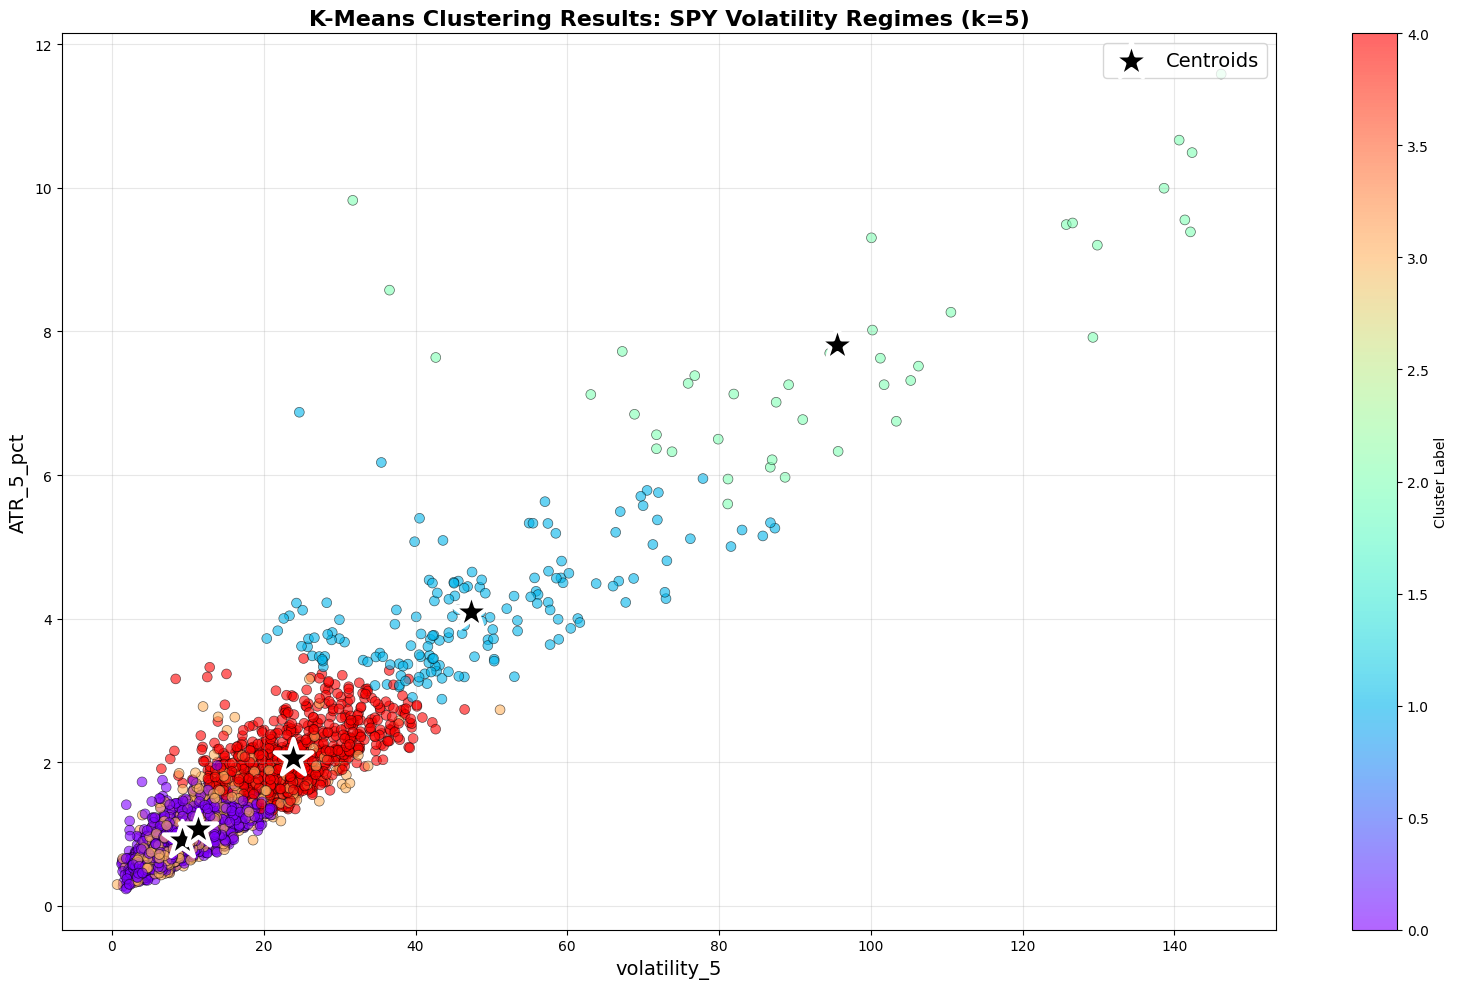


Centroid Coordinates (original scale):


,volatility_5,ATR_5_pct,volume_ratio_5,range_ma5
0,9.283342,0.917706,0.873561,0.834791
1,47.371661,4.093917,0.984246,3.830318
2,95.516552,7.805870,0.969213,7.018407
3,11.382477,1.072401,1.312745,0.974813
4,23.795709,2.060911,0.941594,1.873967


In [11]:

print("\n" + "="*70)
print("STEP 6: VISUALIZE CLUSTERS (2D SCATTER)")
print("="*70)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

# Plot using first 2 features (like professor used Returns vs Volatility)
scatter = ax.scatter(X.iloc[:, 0],      # First feature (e.g., volatility_5)
                     X.iloc[:, 1],      # Second feature (e.g., ATR_5_pct)
                     c=target_labels,   # Color by cluster
                     cmap="rainbow", 
                     s=50, 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

ax.set_title(f"K-Means Clustering Results: SPY Volatility Regimes (k={nclust})", 
             fontsize=16, fontweight='bold')
ax.set_xlabel(f"{feature_cols[0]}", fontsize=14)
ax.set_ylabel(f"{feature_cols[1]}", fontsize=14)

# Plot centroids (convert back to original scale)
centroids_original = scaler.inverse_transform(centroids)
plt.scatter(centroids_original[:, 0],    # First feature centroid
           centroids_original[:, 1],     # Second feature centroid
           marker='*', 
           s=800, 
           c='black',
           edgecolors='white',
           linewidth=3,
           label='Centroids',
           zorder=10)

plt.colorbar(scatter, label='Cluster Label')
plt.legend(fontsize=14, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCentroid Coordinates (original scale):")
centroids_df = pd.DataFrame(centroids_original, columns=feature_cols)
display(centroids_df)


STEP 7: CLUSTER MEMBER COUNTS


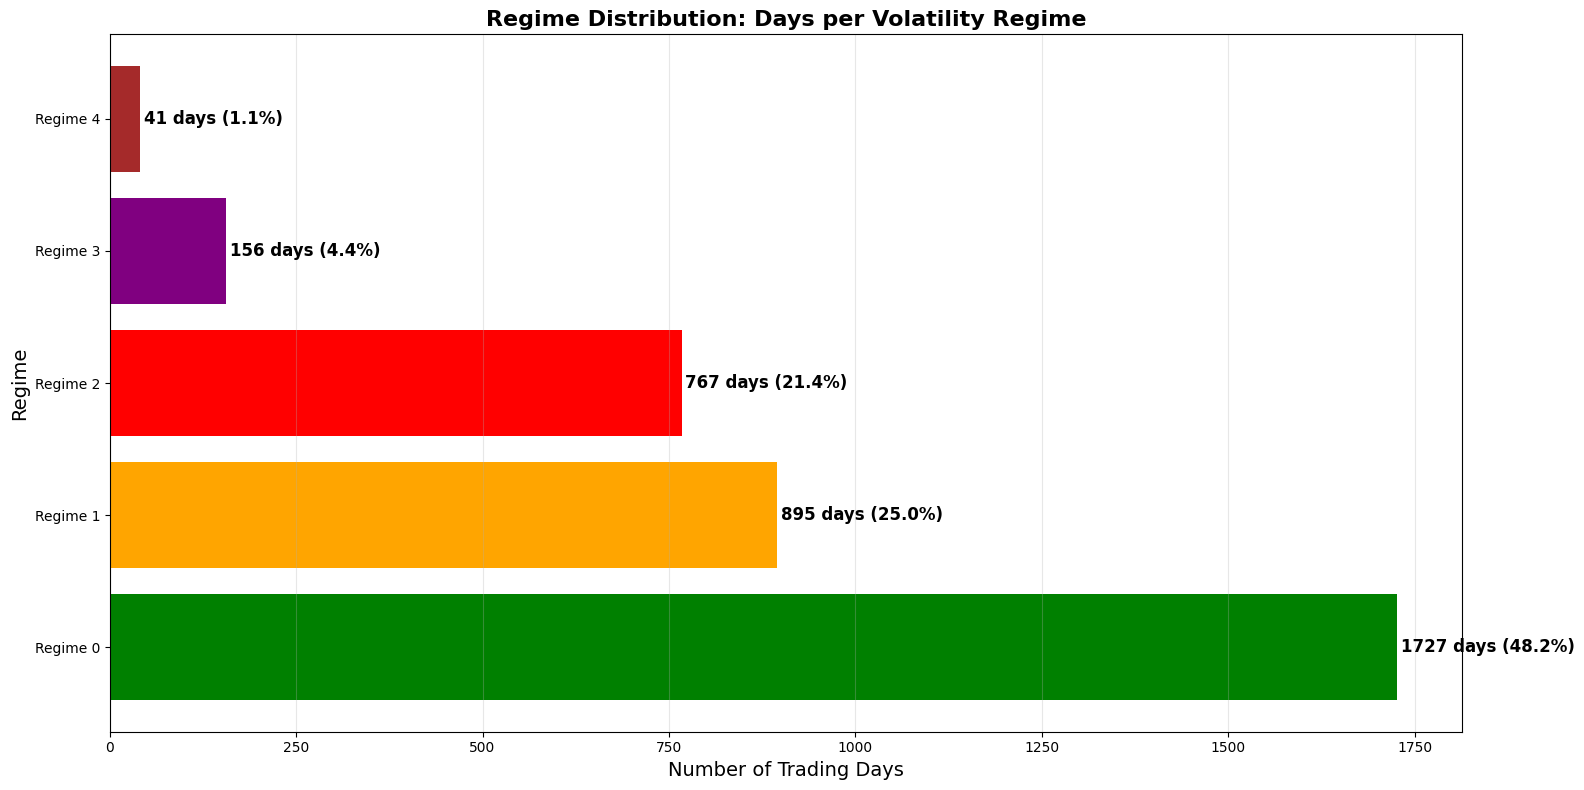


Regime Distribution Summary:
  Regime 0: 1727 days (48.2%)
  Regime 1: 895 days (25.0%)
  Regime 2: 767 days (21.4%)
  Regime 3: 156 days (4.4%)
  Regime 4: 41 days (1.1%)


In [12]:
print("\n" + "="*70)
print("STEP 7: CLUSTER MEMBER COUNTS")
print("="*70)

clustered_series = pd.Series(index=X.index, data=target_labels)
clustered_series = clustered_series[clustered_series != -1]  # Remove any outliers

# Apply regime mapping to ensure sorted by volatility
clustered_series_sorted = clustered_series.map(regime_mapping)

# Define regime names
if nclust == 2:
    regime_names = {0: 'Low Vol', 1: 'High Vol'}
elif nclust == 3:
    regime_names = {0: 'Low Vol', 1: 'Med Vol', 2: 'High Vol'}
else:
    regime_names = {i: f'Regime {i}' for i in range(nclust)}

plt.figure(figsize=(16, 8))
counts = clustered_series_sorted.value_counts().sort_index()

# Color mapping
color_map = {0: 'green', 1: 'orange', 2: 'red', 3: 'purple', 4: 'brown'}
colors = [color_map.get(i, 'gray') for i in counts.index]

bars = plt.barh(counts.index, counts, color=colors)

plt.title("Regime Distribution: Days per Volatility Regime", fontsize=16, fontweight='bold')
plt.xlabel("Number of Trading Days", fontsize=14)
plt.ylabel("Regime", fontsize=14)
plt.yticks(counts.index, [f"{regime_names.get(i, f'Regime {i}')}" for i in counts.index])

# Add percentage labels on bars
for i, (idx, count) in enumerate(counts.items()):
    pct = count / len(clustered_series_sorted) * 100
    plt.text(count + 5, idx, f'{count} days ({pct:.1f}%)', 
             va='center', fontsize=12, fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Print regime distribution
print(f"\nRegime Distribution Summary:")
for regime_id in sorted(counts.index):
    count = counts[regime_id]
    pct = count / len(clustered_series_sorted) * 100
    print(f"  {regime_names.get(regime_id, f'Regime {regime_id}')}: {count} days ({pct:.1f}%)")

In [13]:

print("\n" + "="*70)
print("✅ K-MEANS CLUSTERING COMPLETE!")
print("="*70)
print(f"\nFinal Results:")
print(f"  - Optimal k: {nclust}")
print(f"  - Silhouette Score: {max(silhouette_scores):.4f}")
print(f"  - Features Used: {feature_cols}")
print(f"  - Training Days Clustered: {len(X)}")
print(f"\nRegime column added to spy_train_features DataFrame")
print("="*70)

# Display sample of data with regime labels (using actual features used for clustering)
print("\nSample of clustered data:")
display_cols = ['Adj_Close'] + feature_cols + ['regime']
display(spy_train_features[display_cols].dropna().tail(20))

# Count days in each cluster
print("\n" + "="*70)
print("CLUSTER DISTRIBUTION")
print("="*70)

regime_counts = spy_train_features['regime'].value_counts().sort_index()
total_days = regime_counts.sum()

# Define regime names based on nclust
if nclust == 2:
    regime_names = {0: 'Low Vol', 1: 'High Vol'}
elif nclust == 3:
    regime_names = {0: 'Low Vol', 1: 'Med Vol', 2: 'High Vol'}
elif nclust == 4:
    regime_names = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Med Vol', 3: 'High Vol'}
else:
    regime_names = {i: f'Regime {i}' for i in range(nclust)}

print(f"\nTotal Trading Days: {total_days}")
print(f"\nDays per Regime:")
print("-" * 70)
# Dynamic column header based on first feature used
vol_header = f"Avg {volatility_col}"
print(f"{'Regime':<20} {'Days':>15} {'Percentage':>15} {vol_header:>15}")
print("-" * 70)

for regime_id in sorted(regime_counts.index):
    count = regime_counts[regime_id]
    pct = count / total_days * 100
    # Use first feature (volatility) from feature_cols for display
    avg_vol = spy_train_features[spy_train_features['regime'] == regime_id][volatility_col].mean()
    regime_label = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    print(f"{regime_label:<20} {count:>15} {pct:>14.1f}% {avg_vol:>14.2f}%")

print("-" * 70)
print(f"{'TOTAL':<20} {total_days:>15} {100.0:>14.1f}%")
print("="*70)


✅ K-MEANS CLUSTERING COMPLETE!

Final Results:
  - Optimal k: 5
  - Silhouette Score: 0.6564
  - Features Used: ['volatility_5', 'ATR_5_pct', 'volume_ratio_5', 'range_ma5']
  - Training Days Clustered: 3586

Regime column added to spy_train_features DataFrame

Sample of clustered data:


,Adj_Close,volatility_5,ATR_5_pct,volume_ratio_5,range_ma5,regime
Date,,,,,,
2021-01-11,354.542725,12.240404,1.404310,0.697381,1.252340,0.0
2021-01-12,354.617523,12.609917,1.353851,0.746365,1.197469,0.0
2021-01-13,355.572632,12.497514,1.094808,0.782905,0.935149,0.0
2021-01-14,354.327362,7.818904,0.923210,0.923834,0.884773,0.0
2021-01-15,351.743408,6.907797,0.949686,1.750780,0.861031,1.0
2021-01-19,354.505310,9.199369,0.941764,0.836507,0.840977,0.0
2021-01-20,359.411102,13.449284,1.066444,0.979901,0.869772,0.0
2021-01-21,359.738770,13.508060,0.997288,0.752064,0.799751,0.0
2021-01-22,358.465515,13.518255,0.967921,0.823552,0.759249,0.0



CLUSTER DISTRIBUTION

Total Trading Days: 3586

Days per Regime:
----------------------------------------------------------------------
Regime                          Days      Percentage Avg volatility_5
----------------------------------------------------------------------
Regime 0                        1727           48.2%           9.26%
Regime 1                         895           25.0%          11.41%
Regime 2                         767           21.4%          23.77%
Regime 3                         156            4.4%          47.37%
Regime 4                          41            1.1%          95.52%
----------------------------------------------------------------------
TOTAL                           3586          100.0%


In [14]:

print("\n" + "="*70)
print("APPLYING TRAINED MODEL TO TEST DATA")
print("="*70)

# Step 1: Add features to test data
spy_test_features = add_clustering_features(spy_test)

# Step 2: Extract same features as training
X_test = spy_test_features[feature_cols].dropna()

print(f"\nTest Data: {len(X_test)} trading days")
print(f"Date range: {X_test.index[0]} to {X_test.index[-1]}")

# Step 3: Transform test data using TRAINING scaler (no refit!)
X_test_scaled = scaler.transform(X_test)

# Step 4: Predict clusters using TRAINING model (no refit!)
test_labels = k_means.predict(X_test_scaled)

# Step 5: Add regime labels to test dataframe
spy_test_features.loc[X_test.index, 'regime'] = test_labels

# Step 6: Apply SAME regime mapping as training (0=Low, 1=High, etc.)
spy_test_features['regime'] = spy_test_features['regime'].map(regime_mapping)

print(f"✓ Test data clustered using trained model (no refitting)")
print(f"✓ Regime mapping consistent with training data")


APPLYING TRAINED MODEL TO TEST DATA

Test Data: 1192 trading days
Date range: 2021-02-17 00:00:00 to 2025-11-12 00:00:00
✓ Test data clustered using trained model (no refitting)
✓ Regime mapping consistent with training data


In [15]:
# Display test data cluster distribution
print("\n" + "="*70)
print("TEST DATA CLUSTER DISTRIBUTION")
print("="*70)

regime_counts_test = spy_test_features['regime'].value_counts().sort_index()
total_days_test = regime_counts_test.sum()

print(f"\nTotal Trading Days (Test): {total_days_test}")
print(f"\nDays per Regime (Test):")
print("-" * 70)
print(f"{'Regime':<20} {'Days':>15} {'Percentage':>15} {vol_header:>15}")
print("-" * 70)

for regime_id in sorted(regime_counts_test.index):
    count = regime_counts_test[regime_id]
    pct = count / total_days_test * 100
    avg_vol = spy_test_features[spy_test_features['regime'] == regime_id][volatility_col].mean()
    regime_label = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    print(f"{regime_label:<20} {count:>15} {pct:>14.1f}% {avg_vol:>14.2f}%")

print("-" * 70)
print(f"{'TOTAL':<20} {total_days_test:>15} {100.0:>14.1f}%")
print("="*70)


TEST DATA CLUSTER DISTRIBUTION

Total Trading Days (Test): 1192

Days per Regime (Test):
----------------------------------------------------------------------
Regime                          Days      Percentage Avg volatility_5
----------------------------------------------------------------------
Regime 0                         602           50.5%          10.45%
Regime 1                         293           24.6%          12.44%
Regime 2                         281           23.6%          23.67%
Regime 3                          12            1.0%          47.27%
Regime 4                           4            0.3%          93.40%
----------------------------------------------------------------------
TOTAL                           1192          100.0%


In [16]:
# Compare train vs test distribution
print("\n" + "="*70)
print("TRAIN vs TEST COMPARISON")
print("="*70)

comparison_data = []
for regime_id in sorted(regime_counts.index):
    train_count = regime_counts.get(regime_id, 0)
    train_pct = train_count / total_days * 100
    test_count = regime_counts_test.get(regime_id, 0)
    test_pct = test_count / total_days_test * 100
    regime_label = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    
    comparison_data.append({
        'Regime': regime_label,
        'Train Days': train_count,
        'Train %': f"{train_pct:.1f}%",
        'Test Days': test_count,
        'Test %': f"{test_pct:.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print("\n✅ REGIME DETECTION COMPLETE FOR TRAIN AND TEST DATA")
print("="*70)
print("\nNext steps:")
print("1. Use spy_train_features and spy_test_features in your strategy")
print("2. Both DataFrames now have 'regime' column")
print("3. Regimes are consistently labeled (0=Low, 1=High, etc.)")
print("4. Ready for regime-aware backtesting!")
print("="*70)


TRAIN vs TEST COMPARISON


,Regime,Train Days,Train %,Test Days,Test %
0,Regime 0,1727,48.2%,602,50.5%
1,Regime 1,895,25.0%,293,24.6%
2,Regime 2,767,21.4%,281,23.6%
3,Regime 3,156,4.4%,12,1.0%
4,Regime 4,41,1.1%,4,0.3%



✅ REGIME DETECTION COMPLETE FOR TRAIN AND TEST DATA

Next steps:
1. Use spy_train_features and spy_test_features in your strategy
2. Both DataFrames now have 'regime' column
3. Regimes are consistently labeled (0=Low, 1=High, etc.)
4. Ready for regime-aware backtesting!


In [17]:
# Display sample of test data with regimes
print("\nSample of TEST data with regime labels:")
display_cols_test = ['Adj_Close'] + feature_cols + ['regime']
display(spy_test_features[display_cols_test].dropna().tail(20))


Sample of TEST data with regime labels:


,Adj_Close,volatility_5,ATR_5_pct,volume_ratio_5,range_ma5,regime
Date,,,,,,
2025-10-16,660.640015,25.106299,2.082224,1.063050,1.881497,2.0
2025-10-17,664.390015,13.093750,1.664385,1.055562,1.464346,2.0
2025-10-20,671.299988,10.537465,1.519442,0.690501,1.449844,0.0
2025-10-21,671.289978,10.302715,1.231958,0.693560,1.157177,0.0
2025-10-22,667.799988,11.497992,1.160529,0.996165,1.077972,0.0
2025-10-23,671.760010,9.574064,0.954509,0.912665,0.872980,0.0
2025-10-24,677.250000,10.100137,0.919897,1.102337,0.726874,1.0
2025-10-27,685.239990,10.691803,0.922888,0.931156,0.679515,0.0
2025-10-28,687.059998,10.199759,0.951589,0.893194,0.708602,0.0


In [18]:
# Display final train and test dataframes
print("\n" + "="*70)
print("FINAL DATAFRAMES WITH REGIME COLUMN")
print("="*70)
print(f"\nTrain Data: {spy_train_features.shape}")
display(spy_train_features.head())
print(f"\nTest Data: {spy_test_features.shape}")
display(spy_test_features.head())


FINAL DATAFRAMES WITH REGIME COLUMN

Train Data: (3591, 61)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,volume_std_60,volume_ratio,range_ma3,range_std3,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60,regime
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-11-01,95.973610,96.990426,95.875435,96.927316,83005600,95.973610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100,95.917526,-0.000584,-0.000585,-0.000585,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,95.749207,96.345277,95.104054,96.261130,71346400,95.749207,-0.001755,-0.001756,-0.001756,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.977769,0.440397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,96.829124,96.969373,96.036704,96.043724,63303300,96.829124,0.011279,0.011215,0.011215,11.389941,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.911583,0.412985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,97.200806,97.460266,96.773040,96.913289,63318900,97.200806,0.003839,0.003831,0.003831,10.328964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.988851,0.295491,0.920707,0.333593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Test Data: (1197, 61)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,volume_std_60,volume_ratio,range_ma3,range_std3,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60,regime
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-09,365.365540,365.964743,364.354419,364.766336,35551100,365.365540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10,365.206360,367.266087,362.790887,367.116286,59154400,365.206360,-0.000436,-0.000436,-0.000436,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-11,365.796326,366.713846,363.352766,366.292529,42913300,365.796326,0.001615,0.001614,0.001614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.861657,0.395436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-12,367.603149,367.846551,364.916132,364.991047,50593300,367.603149,0.004939,0.004927,0.004927,4.295958,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.980466,0.220662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,367.284851,-0.000866,-0.000866,-0.000866,4.614269,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.796322,0.122943,0.81102,0.291412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:

def mr_calculate_rsi(prices, period=14):
    # Calculate price changes
    delta = prices.diff()

    # Separate gains and losses
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    # Calculate Wilder's smoothed moving averages
    # First average uses simple mean, then uses Wilder's smoothing
    avg_gain = gains.ewm(com=period-1, min_periods=period, adjust=False).mean()
    avg_loss = losses.ewm(com=period-1, min_periods=period, adjust=False).mean()

    # Calculate RS (Relative Strength)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    # Handle edge cases (division by zero)
    rsi = rsi.fillna(50)  # When no price movement, RSI = 50 (neutral)

    return rsi

In [20]:
def mr_compute_mean_reversion_rsi_strategy(df, rsi_period=14, position_size=150, initial_cash=100000,
                                   rsi_oversold=30, rsi_overbought=70,
                                   rsi_exit_long=50, rsi_exit_short=50,
                                   position_sizing_method='capital_based', capital_allocation_pct=0.98,
                                   target_regime=None, signal_shift=0):
    df_signals = df.copy()
    # ============================================================
    # 1. Calculate Technical Indicators
    # ============================================================
    # Calculate RSI
    df_signals['rsi'] = mr_calculate_rsi(df_signals['Adj_Close'], period=rsi_period) 
    
    # ============================================================
    # 2. Generate Entry/Exit Signals
    # ============================================================
    # Entry Long: RSI crosses above oversold threshold (exits oversold zone - bullish reversal)
    # RSI[t-1] <= oversold AND RSI[t] > oversold
    df_signals['entry_long'] = (
        (df_signals['rsi'].shift(1) <= rsi_oversold) &
        (df_signals['rsi'] > rsi_oversold)
    )

    # Exit Long: RSI crosses above exit threshold (momentum normalizing/profit taking)
    # RSI[t-1] < rsi_exit_long AND RSI[t] >= rsi_exit_long
    df_signals['exit_long'] = (
        (df_signals['rsi'].shift(1) < rsi_exit_long) &
        (df_signals['rsi'] >= rsi_exit_long)
    )

    # Entry Short: RSI crosses below overbought threshold (exits overbought zone - bearish reversal)
    # RSI[t-1] >= overbought AND RSI[t] < overbought
    df_signals['entry_short'] = (
        (df_signals['rsi'].shift(1) >= rsi_overbought) &
        (df_signals['rsi'] < rsi_overbought)
    )

    # Exit Short: RSI crosses below exit threshold (momentum normalizing/profit taking)
    # RSI[t-1] > rsi_exit_short AND RSI[t] <= rsi_exit_short
    df_signals['exit_short'] = (
        (df_signals['rsi'].shift(1) > rsi_exit_short) &
        (df_signals['rsi'] <= rsi_exit_short)
    )

    # Prevent look-ahead bias: shift signals forward to simulate realistic execution
    # Signal generated at day T close can only be executed at day T+1 open (or later)
    # signal_shift=1 ensures we trade on next bar, avoiding forward-looking bias
    if signal_shift > 0:
        df_signals['entry_long'] = df_signals['entry_long'].shift(signal_shift).fillna(False)
        df_signals['exit_long'] = df_signals['exit_long'].shift(signal_shift).fillna(False)
        df_signals['entry_short'] = df_signals['entry_short'].shift(signal_shift).fillna(False)
        df_signals['exit_short'] = df_signals['exit_short'].shift(signal_shift).fillna(False)

    # ============================================================
    # 3. Calculate Position State and Portfolio Tracking
    # ============================================================
    # Position states: 0 = flat, 1 = long, -1 = short
    positions = []
    shares_held = []
    cash_balance = []
    equity_value = []
    total_portfolio = []
    
    current_position = 0
    current_shares = 0
    current_cash = initial_cash

    for i in range(len(df_signals)):
        price = df_signals.iloc[i]['Adj_Close']

        # First (rsi_period-1) days: no positions (RSI lookback period)
        if i < rsi_period - 1:
            positions.append(0)
            shares_held.append(0)
            cash_balance.append(current_cash)
            equity_value.append(0)
            total_portfolio.append(current_cash)
            continue

        # Process exit signals first (priority)
        if current_position == 1 and df_signals.iloc[i]['exit_long']:
            # Exit long: sell shares
            current_cash += current_shares * price
            current_shares = 0
            current_position = 0
            
        elif current_position == -1 and df_signals.iloc[i]['exit_short']:
            # Exit short: buy back shares to cover
            current_cash += current_shares * price  # current_shares is negative for short
            current_shares = 0
            current_position = 0
            
        # Process entry signals (only if flat)
        elif current_position == 0:
            # Check if we should trade in this regime (if target_regime is specified)
            regime_check = True
            if target_regime is not None and 'regime' in df_signals.columns:
                current_regime = df_signals.iloc[i]['regime']
                # Only trade if regime matches (skip NaN regimes too)
                regime_check = (not pd.isna(current_regime)) and (current_regime == target_regime)
            
            if regime_check and df_signals.iloc[i]['entry_long']:
                # Enter long position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = int(available_capital / price)
                else:
                    # Use fixed position size
                    current_shares = position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares > 0:
                    current_cash -= current_shares * price
                    current_position = 1
                else:
                    current_shares = 0
                    
            elif regime_check and df_signals.iloc[i]['entry_short']:
                # Enter short position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = -int(available_capital / price)  # Negative for short
                else:
                    # Use fixed position size (negative for short)
                    current_shares = -position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares < 0:
                    current_cash -= current_shares * price  # Subtracting negative adds to cash
                    current_position = -1
                else:
                    current_shares = 0

        # Record state
        positions.append(current_position)
        shares_held.append(current_shares)
        cash_balance.append(current_cash)
        
        # Calculate equity value (mark-to-market)
        equity = current_shares * price
        equity_value.append(equity)
        total_portfolio.append(current_cash + equity)

    df_signals['signal'] = positions
    df_signals['shares'] = shares_held
    df_signals['cash'] = cash_balance
    df_signals['equity'] = equity_value
    df_signals['portfolio_value'] = total_portfolio

    # ============================================================
    # 4. Calculate Returns and PnL
    # ============================================================
    df_signals['returns'] = df_signals['Adj_Close'].pct_change()
    df_signals['position'] = df_signals['signal'].shift(1).fillna(0)
    df_signals['strategy_returns'] = df_signals['returns'] * df_signals['position']       

    # Calculate daily PnL from portfolio value changes
    df_signals['pnl'] = df_signals['portfolio_value'].diff()
    
    # Calculate cumulative PnL
    df_signals['cumulative_pnl'] = df_signals['portfolio_value'] - initial_cash

    return df_signals

In [21]:
# ============================================================
# RSI Visualization Function
# ============================================================
def mr_visualize_rsi_analysis(train_df, test_df, rsi_period=14,
                          rsi_oversold=30, rsi_overbought=70,
                          figsize=(16, 12), show_stats=True):
    import matplotlib.pyplot as plt

    # Calculate RSI for both datasets
    train_data = train_df.copy()
    test_data = test_df.copy()

    if show_stats:
        print("\n" + "="*70)
        print("CALCULATING RSI FOR TRAIN AND TEST DATA")
        print("="*70)

    train_data['rsi'] = mr_calculate_rsi(train_data['Adj_Close'], period=rsi_period)
    test_data['rsi'] = mr_calculate_rsi(test_data['Adj_Close'], period=rsi_period)

    if show_stats:
        print(f"Train RSI - Mean: {train_data['rsi'].mean():.2f}, Std: {train_data['rsi'].std():.2f}")
        print(f"Test RSI - Mean: {test_data['rsi'].mean():.2f}, Std: {test_data['rsi'].std():.2f}")

    # Create visualization
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    fig.suptitle('RSI Analysis: Train vs Test Data', fontsize=16, fontweight='bold')

    # Plot 1: Train Data - Price and RSI
    ax1 = axes[0]
    ax1_twin = ax1.twinx()
    ax1.plot(train_data.index, train_data['Adj_Close'],
             color='blue', linewidth=1.5, label='Price', alpha=0.7)
    ax1.set_ylabel('Price ($)', fontsize=10, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('TRAIN DATA: Price & RSI', fontsize=12, fontweight='bold')

    ax1_twin.plot(train_data.index, train_data['rsi'],
                  color='purple', linewidth=1, label='RSI', alpha=0.8)
    ax1_twin.axhline(y=rsi_overbought, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Overbought ({rsi_overbought})')
    ax1_twin.axhline(y=50, color='gray', linestyle='-', linewidth=0.8, alpha=0.5, label='Neutral (50)')
    ax1_twin.axhline(y=rsi_oversold, color='green', linestyle='--', linewidth=1, alpha=0.5, label=f'Oversold ({rsi_oversold})')
    ax1_twin.fill_between(train_data.index, rsi_overbought, 100, color='red', alpha=0.1)
    ax1_twin.fill_between(train_data.index, 0, rsi_oversold, color='green', alpha=0.1)
    ax1_twin.set_ylabel('RSI', fontsize=10, color='purple')
    ax1_twin.tick_params(axis='y', labelcolor='purple')
    ax1_twin.set_ylim(0, 100)
    ax1_twin.legend(loc='upper right', fontsize=8)

    # Plot 2: Test Data - Price and RSI
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    ax2.plot(test_data.index, test_data['Adj_Close'],
             color='blue', linewidth=1.5, label='Price', alpha=0.7)
    ax2.set_ylabel('Price ($)', fontsize=10, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('TEST DATA: Price & RSI', fontsize=12, fontweight='bold')

    ax2_twin.plot(test_data.index, test_data['rsi'],
                  color='purple', linewidth=1, label='RSI', alpha=0.8)
    ax2_twin.axhline(y=rsi_overbought, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Overbought ({rsi_overbought})')
    ax2_twin.axhline(y=50, color='gray', linestyle='-', linewidth=0.8, alpha=0.5, label='Neutral (50)')
    ax2_twin.axhline(y=rsi_oversold, color='green', linestyle='--', linewidth=1, alpha=0.5, label=f'Oversold ({rsi_oversold})')
    ax2_twin.fill_between(test_data.index, rsi_overbought, 100, color='red', alpha=0.1)
    ax2_twin.fill_between(test_data.index, 0, rsi_oversold, color='green', alpha=0.1)
    ax2_twin.set_ylabel('RSI', fontsize=10, color='purple')
    ax2_twin.tick_params(axis='y', labelcolor='purple')
    ax2_twin.set_ylim(0, 100)
    ax2_twin.legend(loc='upper right', fontsize=8)

    # Plot 3: RSI Distribution Comparison
    ax3 = axes[2]
    ax3.hist(train_data['rsi'].dropna(), bins=50, alpha=0.6,
             color='blue', label=f'Train (n={len(train_data)})', edgecolor='black')
    ax3.hist(test_data['rsi'].dropna(), bins=50, alpha=0.6,
             color='orange', label=f'Test (n={len(test_data)})', edgecolor='black')
    ax3.axvline(x=rsi_oversold, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Oversold ({rsi_oversold})')
    ax3.axvline(x=50, color='gray', linestyle='-', linewidth=1.5, alpha=0.7, label='Neutral (50)')
    ax3.axvline(x=rsi_overbought, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Overbought ({rsi_overbought})')
    ax3.set_xlabel('RSI Value', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('RSI Distribution: Train vs Test', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: RSI by Regime (if available)
    ax4 = axes[3]
    if 'regime' in train_data.columns and 'regime' in test_data.columns:
        train_regimes = train_data.groupby('regime')['rsi'].apply(list)
        test_regimes = test_data.groupby('regime')['rsi'].apply(list)

        positions_train = [i - 0.2 for i in range(len(train_regimes))]
        positions_test = [i + 0.2 for i in range(len(test_regimes))]

        bp1 = ax4.boxplot([train_regimes[i] for i in sorted(train_regimes.index)],
                           positions=positions_train, widths=0.35,
                           patch_artist=True, showfliers=False,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='darkblue', linewidth=2))
        bp2 = ax4.boxplot([test_regimes[i] for i in sorted(test_regimes.index)],
                           positions=positions_test, widths=0.35,
                           patch_artist=True, showfliers=False,
                           boxprops=dict(facecolor='lightcoral', alpha=0.7),
                           medianprops=dict(color='darkred', linewidth=2))

        ax4.axhline(y=rsi_overbought, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(y=50, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
        ax4.axhline(y=rsi_oversold, color='green', linestyle='--', linewidth=1, alpha=0.5)
        ax4.set_xticks(range(len(train_regimes)))
        ax4.set_xticklabels([f'Regime {int(i)}' for i in sorted(train_regimes.index)])
        ax4.set_ylabel('RSI Value', fontsize=10)
        ax4.set_title('RSI Distribution by Volatility Regime', fontsize=12, fontweight='bold')
        ax4.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Train', 'Test'], loc='upper right', fontsize=9)
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0, 100)
    else:
        ax4.text(0.5, 0.5, 'Regime data not available',
                 ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        ax4.set_title('RSI by Regime (Not Available)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print RSI statistics
    if show_stats:
        print("\n" + "="*70)
        print("RSI STATISTICS")
        print("="*70)
        print("\nTRAIN DATA:")
        print(f"  Oversold (<{rsi_oversold}): {(train_data['rsi'] < rsi_oversold).sum()} days ({(train_data['rsi'] < rsi_oversold).sum()/len(train_data)*100:.1f}%)")
        print(f"  Neutral ({rsi_oversold}-{rsi_overbought}): {((train_data['rsi'] >= rsi_oversold) & (train_data['rsi'] <= rsi_overbought)).sum()} days ({((train_data['rsi'] >= rsi_oversold) & (train_data['rsi'] <= rsi_overbought)).sum()/len(train_data)*100:.1f}%)")
        print(f"  Overbought (>{rsi_overbought}): {(train_data['rsi'] > rsi_overbought).sum()} days ({(train_data['rsi'] > rsi_overbought).sum()/len(train_data)*100:.1f}%)")

        print("\nTEST DATA:")
        print(f"  Oversold (<{rsi_oversold}): {(test_data['rsi'] < rsi_oversold).sum()} days ({(test_data['rsi'] < rsi_oversold).sum()/len(test_data)*100:.1f}%)")
        print(f"  Neutral ({rsi_oversold}-{rsi_overbought}): {((test_data['rsi'] >= rsi_oversold) & (test_data['rsi'] <= rsi_overbought)).sum()} days ({((test_data['rsi'] >= rsi_oversold) & (test_data['rsi'] <= rsi_overbought)).sum()/len(test_data)*100:.1f}%)")
        print(f"  Overbought (>{rsi_overbought}): {(test_data['rsi'] > rsi_overbought).sum()} days ({(test_data['rsi'] > rsi_overbought).sum()/len(test_data)*100:.1f}%)")

    return train_data, test_data, fig


CALCULATING RSI FOR TRAIN AND TEST DATA
Train RSI - Mean: 55.55, Std: 11.51
Test RSI - Mean: 55.74, Std: 11.49


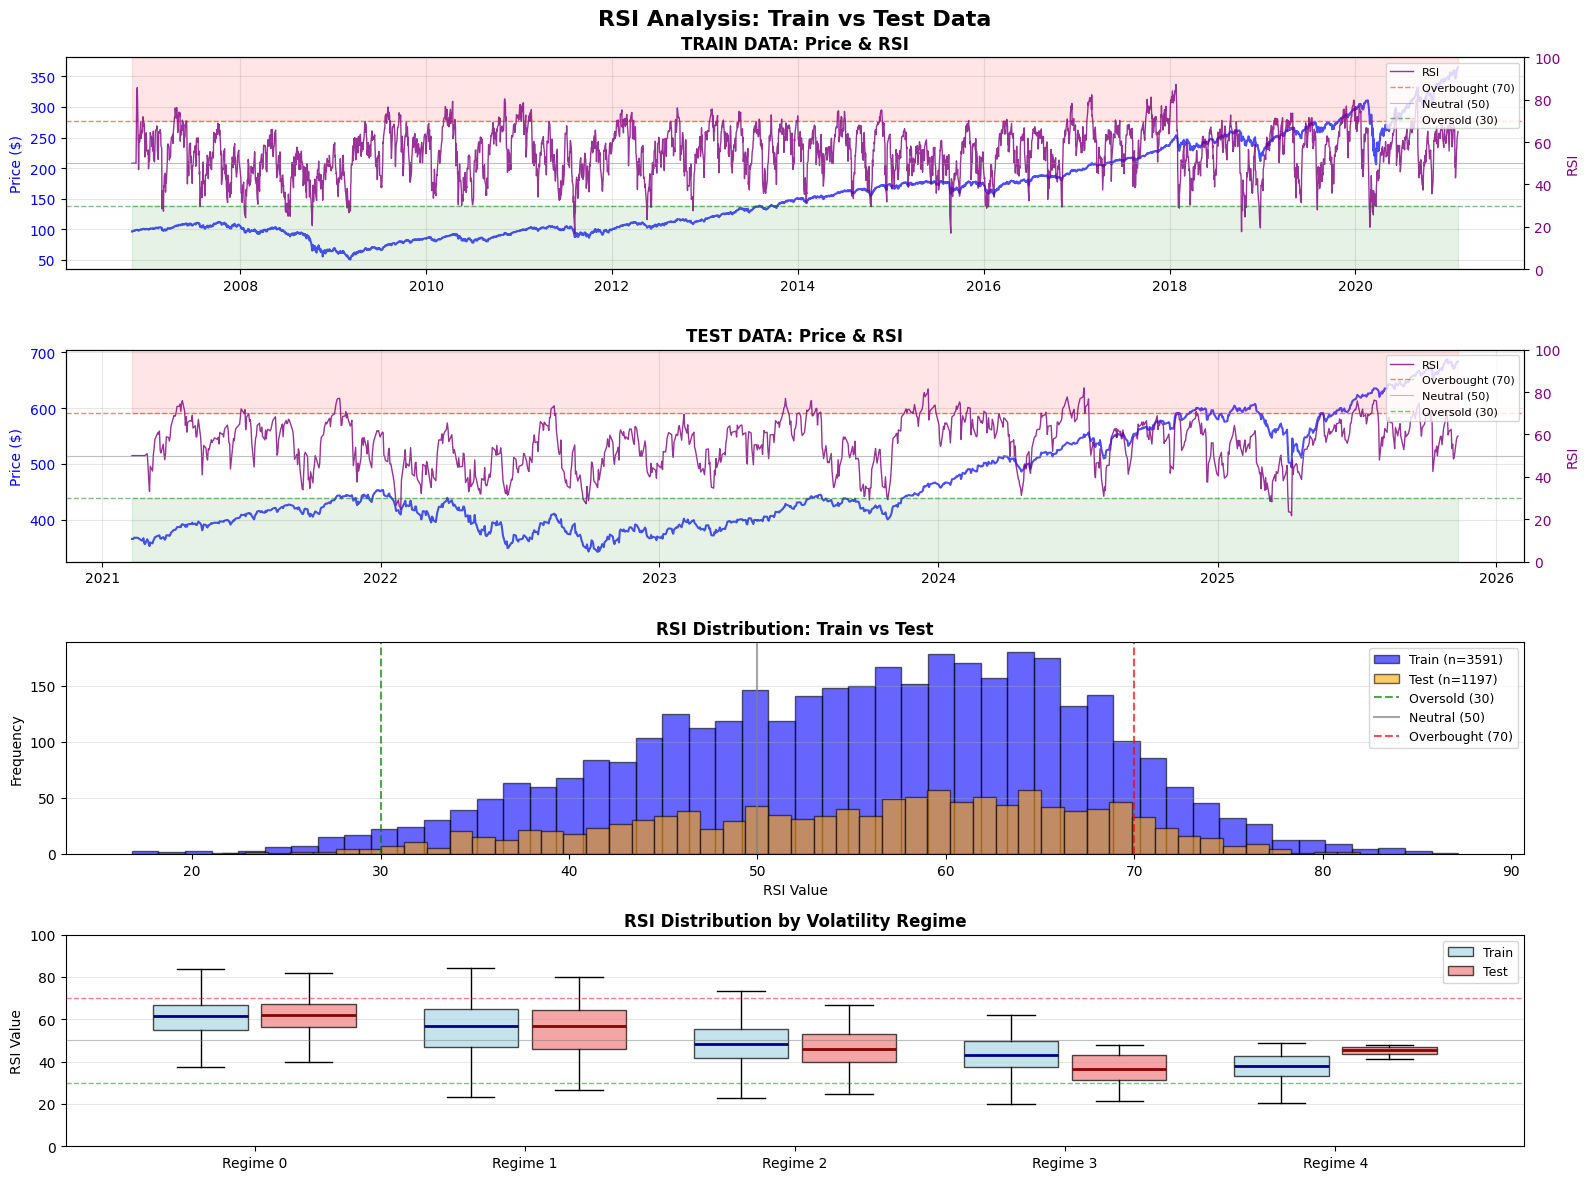


RSI STATISTICS

TRAIN DATA:
  Oversold (<30): 65 days (1.8%)
  Neutral (30-70): 3209 days (89.4%)
  Overbought (>70): 317 days (8.8%)

TEST DATA:
  Oversold (<30): 16 days (1.3%)
  Neutral (30-70): 1073 days (89.6%)
  Overbought (>70): 108 days (9.0%)


In [22]:
# ============================================================
# Visualize RSI for Train and Test Data
# ============================================================
# Call the function with just one line!
spy_train_features, spy_test_features, rsi_fig = mr_visualize_rsi_analysis(spy_train_features, spy_test_features)

In [23]:
def mr_rsi_hyperparameter_test(df,
                       rsi_period_range=[10, 14, 20, 30],
                       rsi_oversold_range=[20, 25, 30, 35],
                       rsi_overbought_range=[65, 70, 75, 80],
                       rsi_exit_long_range=[45, 50, 55],
                       rsi_exit_short_range=[45, 50, 55],
                       position_sizing_methods=['fixed', 'capital_based'],
                       position_sizes=[150],
                       capital_allocation_pcts=[0.98],
                       initial_cash=100000,
                       sort_by='Sharpe Ratio',
                       top_n=20,
                       verbose=True,
                       n_jobs=-1,
                       target_regime=None):
    import itertools
    from datetime import datetime
    from joblib import Parallel, delayed
    import io
    import sys
    
    results = []

    # Generate all parameter combinations for RSI strategy
    param_combinations = []

    for rsi_period in rsi_period_range:
        for rsi_oversold in rsi_oversold_range:
            for rsi_overbought in rsi_overbought_range:
                # Only test valid threshold combinations (overbought > oversold)
                if rsi_overbought > rsi_oversold:
                    for rsi_exit_long in rsi_exit_long_range:
                        for rsi_exit_short in rsi_exit_short_range:
                            # Validate exit thresholds are between entry thresholds
                            if rsi_oversold < rsi_exit_long < rsi_overbought and rsi_oversold < rsi_exit_short < rsi_overbought:
                                for method in position_sizing_methods:
                                    if method == 'fixed':
                                        for pos_size in position_sizes:
                                            param_combinations.append({
                                                'rsi_period': rsi_period,
                                                'rsi_oversold': rsi_oversold,
                                                'rsi_overbought': rsi_overbought,
                                                'rsi_exit_long': rsi_exit_long,
                                                'rsi_exit_short': rsi_exit_short,
                                                'position_sizing_method': method,
                                                'position_size': pos_size,
                                                'capital_allocation_pct': None
                                            })
                                    else:  # capital_based
                                        for cap_alloc in capital_allocation_pcts:
                                            param_combinations.append({
                                                'rsi_period': rsi_period,
                                                'rsi_oversold': rsi_oversold,
                                                'rsi_overbought': rsi_overbought,
                                                'rsi_exit_long': rsi_exit_long,
                                                'rsi_exit_short': rsi_exit_short,
                                                'position_sizing_method': method,
                                                'position_size': None,
                                                'capital_allocation_pct': cap_alloc
                                            })
    
    # Helper function to test a single parameter combination
    def test_single_combination(params):
        try:
            # Run RSI-based strategy
            if params['position_sizing_method'] == 'fixed':
                df_signals = mr_compute_mean_reversion_rsi_strategy(
                    df,
                    rsi_period=params['rsi_period'],
                    rsi_oversold=params['rsi_oversold'],
                    rsi_overbought=params['rsi_overbought'],
                    rsi_exit_long=params['rsi_exit_long'],
                    rsi_exit_short=params['rsi_exit_short'],
                    position_size=params['position_size'],
                    initial_cash=initial_cash,
                    position_sizing_method=params['position_sizing_method'],
                    target_regime=target_regime
                )
            else:  # capital_based
                df_signals = mr_compute_mean_reversion_rsi_strategy(
                    df,
                    rsi_period=params['rsi_period'],
                    rsi_oversold=params['rsi_oversold'],
                    rsi_overbought=params['rsi_overbought'],
                    rsi_exit_long=params['rsi_exit_long'],
                    rsi_exit_short=params['rsi_exit_short'],
                    initial_cash=initial_cash,
                    position_sizing_method=params['position_sizing_method'],
                    capital_allocation_pct=params['capital_allocation_pct'],
                    target_regime=target_regime
                )

            # Calculate metrics (suppress print output)
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()

            metrics = mr_rsi_calculate_performance_metrics(df_signals, initial_cash=initial_cash)

            sys.stdout = old_stdout

            # Store results with RSI parameter names
            result = {
                'RSI_Period': params['rsi_period'],
                'RSI_Oversold': params['rsi_oversold'],
                'RSI_Overbought': params['rsi_overbought'],
                'RSI_Exit_Long': params['rsi_exit_long'],
                'RSI_Exit_Short': params['rsi_exit_short'],
                'Method': params['position_sizing_method'],
                'Position_Size': params['position_size'],
                'Capital_Alloc_Pct': params['capital_allocation_pct'],
                **metrics  # Add all metrics
            }
            return result

        except Exception as e:
            return None
    
    total_tests = len(param_combinations)
    if verbose:
        print(f"\n{'='*70}")
        print(f"HYPERPARAMETER TEST - PARALLEL PROCESSING")
        print(f"{'='*70}")
        print(f"Testing {total_tests} parameter combinations...")
        print(f"Using {n_jobs if n_jobs > 0 else 'ALL'} CPU cores")
        print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
        print(f"{'='*70}\n")
    
    # Run tests in parallel
    results = Parallel(n_jobs=n_jobs, verbose=10 if verbose else 0)(
        delayed(test_single_combination)(params) for params in param_combinations
    )
    
    # Filter out None results (failed tests)
    results = [r for r in results if r is not None]
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"\nCompleted at: {datetime.now().strftime('%H:%M:%S')}")
        print(f"Successful tests: {len(results_df)}/{total_tests}")
    
    # Sort by specified metric (descending for most metrics)
    if sort_by in results_df.columns:
        ascending = True if 'Drawdown' in sort_by else False  # Drawdown should be ascending (less negative is better)
        results_df = results_df.sort_values(by=sort_by, ascending=ascending)
    
    # Return top N results
    return results_df.head(top_n) if top_n else results_df

In [24]:
def mr_rsi_calculate_performance_metrics(df_signals, initial_cash=100000):
    # Calculate signal changes to identify individual trades
    df_signals['signal_change'] = df_signals['signal'].diff()

    # Identify trade periods (when position is held)
    df_long = df_signals[df_signals['signal'] == 1].copy()
    df_short = df_signals[df_signals['signal'] == -1].copy()

    # Calculate trade-level P&L by grouping consecutive positions
    trades = []
    current_signal = 0
    entry_idx = None

    for idx, row in df_signals.iterrows():
        if row['signal'] != current_signal:
            # Position changed - close previous trade if exists
            if current_signal != 0 and entry_idx is not None:
                exit_idx = idx
                trade_pnl = df_signals.loc[entry_idx:idx, 'pnl'].sum()
                trades.append({
                    'entry_date': entry_idx,
                    'exit_date': exit_idx,
                    'direction': 'Long' if current_signal == 1 else 'Short',
                    'pnl': trade_pnl
                })

            # Start new trade if entering position
            if row['signal'] != 0:
                entry_idx = idx
            current_signal = row['signal']

    # Convert to DataFrame
    trades_df = pd.DataFrame(trades)

    # Separate by direction and win/loss
    if len(trades_df) > 0:
        winning_longs = trades_df[(trades_df['direction'] == 'Long') & (trades_df['pnl'] > 0)]
        losing_longs = trades_df[(trades_df['direction'] == 'Long') & (trades_df['pnl'] <= 0)]
        winning_shorts = trades_df[(trades_df['direction'] == 'Short') & (trades_df['pnl'] > 0)]
        losing_shorts = trades_df[(trades_df['direction'] == 'Short') & (trades_df['pnl'] <= 0)]
    else:
        winning_longs = losing_longs = winning_shorts = losing_shorts = pd.DataFrame()

    # Calculate total returns
    # Use portfolio_value if available (more accurate), otherwise calculate from pnl
    if 'portfolio_value' in df_signals.columns:
        final_value = df_signals['portfolio_value'].iloc[-1]
        total_pnl = final_value - initial_cash
    else:
        total_pnl = df_signals['pnl'].sum()
        final_value = initial_cash + total_pnl
    
    total_return_pct = (total_pnl / initial_cash) * 100

    # Calculate CAGR
    years = (df_signals.index[-1] - df_signals.index[0]).days / 365.25
    cagr = ((final_value / initial_cash) ** (1 / years) - 1) * 100 if years > 0 else 0

    # Calculate Sharpe Ratio (annualized)
    daily_returns = df_signals['strategy_returns'].dropna()
    if len(daily_returns) > 0 and daily_returns.std() > 0:
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0

    # Calculate Max Drawdown
    cumulative_returns = (1 + df_signals['strategy_returns']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() * 100

    # Calculate volatility (annualized)
    volatility = daily_returns.std() * np.sqrt(252) * 100 if len(daily_returns) > 0 else 0

    # Calculate final P&L by direction
    final_long_pnl = (winning_longs['pnl'].sum() if len(winning_longs) > 0 else 0) + \
                     (losing_longs['pnl'].sum() if len(losing_longs) > 0 else 0)
    final_short_pnl = (winning_shorts['pnl'].sum() if len(winning_shorts) > 0 else 0) + \
                      (losing_shorts['pnl'].sum() if len(losing_shorts) > 0 else 0)

    # Compile metrics
    metrics = {
        'Total P&L ($)': total_pnl,
        'Total Return (%)': total_return_pct,
        'CAGR (%)': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Volatility (% annualized)': volatility,
        'Total Trades': len(trades_df),
        'Winning Longs': len(winning_longs),
        'Winning Longs P&L ($)': winning_longs['pnl'].sum() if len(winning_longs) > 0 else 0,
        'Losing Longs': len(losing_longs),
        'Losing Longs P&L ($)': losing_longs['pnl'].sum() if len(losing_longs) > 0 else 0,
        'Final Long P&L ($)': final_long_pnl,
        'Long Win Rate (%)': (len(winning_longs) / (len(winning_longs) + len(losing_longs)) * 100) if (len(winning_longs) + len(losing_longs)) > 0 else 0,
        'Winning Shorts': len(winning_shorts),
        'Winning Shorts P&L ($)': winning_shorts['pnl'].sum() if len(winning_shorts) > 0 else 0,
        'Losing Shorts': len(losing_shorts),
        'Losing Shorts P&L ($)': losing_shorts['pnl'].sum() if len(losing_shorts) > 0 else 0,
        'Final Short P&L ($)': final_short_pnl,
        'Short Win Rate (%)': (len(winning_shorts) / (len(winning_shorts) + len(losing_shorts)) * 100) if (len(winning_shorts) + len(losing_shorts)) > 0 else 0,
    }

    # Print formatted summary
    print(f"\n{'='*70}")
    print(f"{'PERFORMANCE METRICS SUMMARY':^70}")
    print(f"{'='*70}\n")

    print(f"{'OVERALL PERFORMANCE':-^70}")
    print(f"Total P&L:                ${metrics['Total P&L ($)']:>15,.2f}")
    print(f"Total Return:             {metrics['Total Return (%)']:>15,.2f}%")
    print(f"CAGR:                     {metrics['CAGR (%)']:>15,.2f}%")
    print(f"Sharpe Ratio:             {metrics['Sharpe Ratio']:>15,.3f}")
    print(f"Max Drawdown:             {metrics['Max Drawdown (%)']:>15,.2f}%")
    print(f"Volatility (annualized):  {metrics['Volatility (% annualized)']:>15,.2f}%")
    print(f"\n{'TRADE STATISTICS':-^70}")
    print(f"Total Trades:             {metrics['Total Trades']:>15,}")
    print(f"\n{'LONG POSITIONS':-^70}")
    print(f"Winning Longs:            {metrics['Winning Longs']:>15,} trades")
    print(f"Winning Longs P&L:        ${metrics['Winning Longs P&L ($)']:>15,.2f}")
    print(f"Losing Longs:             {metrics['Losing Longs']:>15,} trades")
    print(f"Losing Longs P&L:         ${metrics['Losing Longs P&L ($)']:>15,.2f}")
    print(f"Final Long P&L:           ${metrics['Final Long P&L ($)']:>15,.2f}")
    print(f"Long Win Rate:            {metrics['Long Win Rate (%)']:>15,.2f}%")
    print(f"\n{'SHORT POSITIONS':-^70}")
    print(f"Winning Shorts:           {metrics['Winning Shorts']:>15,} trades")
    print(f"Winning Shorts P&L:       ${metrics['Winning Shorts P&L ($)']:>15,.2f}")
    print(f"Losing Shorts:            {metrics['Losing Shorts']:>15,} trades")
    print(f"Losing Shorts P&L:        ${metrics['Losing Shorts P&L ($)']:>15,.2f}")
    print(f"Final Short P&L:          ${metrics['Final Short P&L ($)']:>15,.2f}")
    print(f"Short Win Rate:           {metrics['Short Win Rate (%)']:>15,.2f}%")
    print(f"\n{'='*70}\n")

    return metrics

In [25]:
def mr_viz_backtest_rsi_mean_reversion(df_signals, start_date=None, end_date=None):
    # Filter by date range if specified
    df_plot = df_signals.copy()
    if start_date is not None:
        df_plot = df_plot[df_plot.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_plot = df_plot[df_plot.index <= pd.to_datetime(end_date)]

    # Create subplots: price on top, RSI on bottom
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10), sharex=True,
                                     gridspec_kw={'height_ratios': [2, 1]})

    # ============= TOP PLOT: PRICE WITH SIGNALS =============
    ax1.plot(df_plot.index, df_plot["Adj_Close"], label="Price = Adjusted Close", linewidth=1.5)

    # Calculate signal changes (actual trade executions)
    df_plot['signal_change'] = df_plot['signal'].diff()
    df_plot['prev_signal'] = df_plot['signal'].shift(1)

    # LONG Entry: signal changes to 1 (0→1 or -1→1)
    long_entries = df_plot[(df_plot['signal'] == 1) & (df_plot['prev_signal'] != 1)]
    if len(long_entries) > 0:
        ax1.scatter(long_entries.index, long_entries["Adj_Close"],
                   label="Long Entry", marker="^", color="green", s=100, zorder=5)

    # LONG Exit: signal changes from 1 to something else
    long_exits = df_plot[(df_plot['prev_signal'] == 1) & (df_plot['signal'] != 1)]
    if len(long_exits) > 0:
        ax1.scatter(long_exits.index, long_exits["Adj_Close"],
                   label="Long Exit", marker="v", color="lightgreen", s=100, zorder=5)

    # SHORT Entry: signal changes to -1 (0→-1 or 1→-1)
    short_entries = df_plot[(df_plot['signal'] == -1) & (df_plot['prev_signal'] != -1)]
    if len(short_entries) > 0:
        ax1.scatter(short_entries.index, short_entries["Adj_Close"],
                   label="Short Entry", marker="v", color="red", s=100, zorder=5)

    # SHORT Exit: signal changes from -1 to something else
    short_exits = df_plot[(df_plot['prev_signal'] == -1) & (df_plot['signal'] != -1)]
    if len(short_exits) > 0:
        ax1.scatter(short_exits.index, short_exits["Adj_Close"],
                   label="Short Exit", marker="^", color="lightcoral", s=100, zorder=5)

    ax1.set_ylabel("Price", fontsize=12)
    ax1.set_title("RSI Mean Reversion Strategy - Backtesting with Entry & Exit Signals", fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # ============= BOTTOM PLOT: RSI WITH THRESHOLDS =============
    ax2.plot(df_plot.index, df_plot["rsi"], label="RSI", color="purple", linewidth=1.5)

    # Plot RSI threshold lines if they exist in the dataframe
    if 'rsi_oversold' in df_plot.columns:
        rsi_oversold = df_plot['rsi_oversold'].iloc[0]
        ax2.axhline(y=rsi_oversold, color='green', linestyle='--', linewidth=1.5,
                   label=f'Oversold (Entry Long): {rsi_oversold}')

    if 'rsi_overbought' in df_plot.columns:
        rsi_overbought = df_plot['rsi_overbought'].iloc[0]
        ax2.axhline(y=rsi_overbought, color='red', linestyle='--', linewidth=1.5,
                   label=f'Overbought (Entry Short): {rsi_overbought}')

    if 'rsi_exit_long' in df_plot.columns:
        rsi_exit_long = df_plot['rsi_exit_long'].iloc[0]
        ax2.axhline(y=rsi_exit_long, color='lightgreen', linestyle=':', linewidth=1.5,
                   label=f'Exit Long: {rsi_exit_long}')

    if 'rsi_exit_short' in df_plot.columns:
        rsi_exit_short = df_plot['rsi_exit_short'].iloc[0]
        ax2.axhline(y=rsi_exit_short, color='lightcoral', linestyle=':', linewidth=1.5,
                   label=f'Exit Short: {rsi_exit_short}')

    # Add reference lines at 30 and 70 (traditional RSI levels)
    ax2.axhline(y=30, color='gray', linestyle='-.', linewidth=0.8, alpha=0.5)
    ax2.axhline(y=70, color='gray', linestyle='-.', linewidth=0.8, alpha=0.5)

    # Fill oversold/overbought regions
    ax2.fill_between(df_plot.index, 0, 30, alpha=0.1, color='green', label='Traditional Oversold')
    ax2.fill_between(df_plot.index, 70, 100, alpha=0.1, color='red', label='Traditional Overbought')

    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("RSI", fontsize=12)
    ax2.set_ylim([0, 100])
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [26]:
def mr_ris_viz_regime_aware_backtest_signals(df_results, start_date=None, end_date=None, regime_names_dict=None):

    # Filter by date range if specified
    df_plot = df_results.copy()
    if start_date is not None:
        df_plot = df_plot[df_plot.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_plot = df_plot[df_plot.index <= pd.to_datetime(end_date)]

    # Define regime colors (gradient from calm to crisis)
    regime_colors = {
        0: 'lightgreen',    # Very Low Vol: Green (calm)
        1: 'lightblue',     # Low Vol: Blue (stable)
        2: 'lightyellow',   # Med Vol: Yellow (normal)
        3: 'orange',        # High Vol: Orange (elevated)
        4: 'lightcoral'     # Very High Vol: Red (crisis)
    }

    # Create 2-panel figure: Price chart on top, RSI indicator on bottom
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 1]})

    # ============================================================
    # TOP PANEL: Price Chart with Entry/Exit Signals
    # ============================================================
    # Add regime background first (behind everything)
    if 'regime' in df_plot.columns:
        for regime in df_plot['regime'].dropna().unique():
            regime_mask = df_plot['regime'] == regime
            regime_label = regime_names_dict.get(int(regime), f'Regime {int(regime)}') if regime_names_dict else f'Regime {int(regime)}'
            ax1.fill_between(df_plot.index,
                           df_plot["Adj_Close"].min() * 0.9,
                           df_plot["Adj_Close"].max() * 1.1,
                           where=regime_mask,
                           alpha=0.2,
                           color=regime_colors.get(int(regime), 'lightgray'),
                           label=regime_label)

    # Plot price
    ax1.plot(df_plot.index, df_plot["Adj_Close"], label="SPY Price", linewidth=2, color='black', zorder=3)
    
    # Calculate signal changes (actual trade executions)
    df_plot['signal_change'] = df_plot['signal'].diff()
    df_plot['prev_signal'] = df_plot['signal'].shift(1)

    # LONG Entry: signal changes to 1
    long_entries = df_plot[(df_plot['signal'] == 1) & (df_plot['prev_signal'] != 1)]
    if len(long_entries) > 0:
        ax1.scatter(long_entries.index, long_entries["Adj_Close"],
                   label="LONG Entry", marker="^", s=150, color="darkgreen",
                   edgecolors='black', linewidths=1.5, zorder=5)

    # LONG Exit: signal changes from 1 to something else
    long_exits = df_plot[(df_plot['prev_signal'] == 1) & (df_plot['signal'] != 1)]
    if len(long_exits) > 0:
        ax1.scatter(long_exits.index, long_exits["Adj_Close"],
                   label="LONG Exit", marker="v", s=150, color="lightgreen",
                   edgecolors='black', linewidths=1.5, zorder=5)

    # SHORT Entry: signal changes to -1
    short_entries = df_plot[(df_plot['signal'] == -1) & (df_plot['prev_signal'] != -1)]
    if len(short_entries) > 0:
        ax1.scatter(short_entries.index, short_entries["Adj_Close"],
                   label="SHORT Entry", marker="v", s=150, color="darkred",
                   edgecolors='black', linewidths=1.5, zorder=5)

    # SHORT Exit: signal changes from -1 to something else
    short_exits = df_plot[(df_plot['prev_signal'] == -1) & (df_plot['signal'] != -1)]
    if len(short_exits) > 0:
        ax1.scatter(short_exits.index, short_exits["Adj_Close"],
                   label="SHORT Exit", marker="^", s=150, color="lightcoral",
                   edgecolors='black', linewidths=1.5, zorder=5)

    # Top panel formatting
    date_range = f"{df_plot.index[0].strftime('%Y-%m-%d')} to {df_plot.index[-1].strftime('%Y-%m-%d')}"
    ax1.set_title(f"Regime-Aware RSI Mean Reversion Strategy - Entry/Exit Signals\n{date_range}",
                 fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='best', fontsize=10, ncol=2)
    ax1.grid(alpha=0.3)

    # ============================================================
    # BOTTOM PANEL: RSI Indicator with Threshold Lines
    # ============================================================
    # Add regime background to RSI panel
    if 'regime' in df_plot.columns:
        for regime in df_plot['regime'].dropna().unique():
            regime_mask = df_plot['regime'] == regime
            ax2.fill_between(df_plot.index, 0, 100,
                           where=regime_mask,
                           alpha=0.2,
                           color=regime_colors.get(int(regime), 'lightgray'))

    # Plot RSI
    if 'rsi' in df_plot.columns:
        ax2.plot(df_plot.index, df_plot['rsi'], label='RSI', linewidth=2, color='purple', zorder=3)

    # Plot standard RSI reference levels
    ax2.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Oversold (30)')
    ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Neutral (50)')

    # Mark signal points on RSI panel
    if len(long_entries) > 0:
        ax2.scatter(long_entries.index, long_entries['rsi'],
                   marker="^", s=100, color="darkgreen", edgecolors='black', linewidths=1, zorder=5)
    if len(long_exits) > 0:
        ax2.scatter(long_exits.index, long_exits['rsi'],
                   marker="v", s=100, color="lightgreen", edgecolors='black', linewidths=1, zorder=5)
    if len(short_entries) > 0:
        ax2.scatter(short_entries.index, short_entries['rsi'],
                   marker="v", s=100, color="darkred", edgecolors='black', linewidths=1, zorder=5)
    if len(short_exits) > 0:
        ax2.scatter(short_exits.index, short_exits['rsi'],
                   marker="^", s=100, color="lightcoral", edgecolors='black', linewidths=1, zorder=5)

    # Bottom panel formatting
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('RSI', fontsize=12)
    ax2.set_ylim(0, 100)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Print signal summary
    print("\n" + "="*70)
    print("SIGNAL SUMMARY")
    print("="*70)
    print(f"Long Entries:  {len(long_entries)}")
    print(f"Long Exits:    {len(long_exits)}")
    print(f"Short Entries: {len(short_entries)}")
    print(f"Short Exits:   {len(short_exits)}")
    print(f"Total Signals: {len(long_entries) + len(long_exits) + len(short_entries) + len(short_exits)}")
    print("="*70)

In [27]:
def mr_rsi_viz_backtest_returns(df_signals, initial_cash=100000):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[17, 10])

    # Calculate cumulative returns
    df_plot = df_signals.copy()

    # Strategy cumulative returns
    df_plot['cum_strategy_returns'] = (1 + df_plot['strategy_returns']).cumprod() - 1

    # Buy-and-hold cumulative returns
    df_plot['cum_asset_returns'] = (1 + df_plot['returns']).cumprod() - 1

    # Calculate running maximum for drawdown
    strategy_cummax = (1 + df_plot['strategy_returns']).cumprod().expanding().max()
    df_plot['drawdown'] = ((1 + df_plot['strategy_returns']).cumprod() - strategy_cummax) / strategy_cummax

    # Plot 1: Cumulative Returns
    df_plot[['cum_asset_returns', 'cum_strategy_returns']].dropna().plot(ax=ax1, linewidth=1.5)

    # Format y-axis as percentage
    from matplotlib.ticker import PercentFormatter
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    ax1.legend(['Buy & Hold', 'Mean Reversion Strategy'], loc='best')
    ax1.set_title('Cumulative Returns: Strategy vs Buy-and-Hold', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.grid(alpha=0.3)

    # Plot 2: Drawdown
    df_plot['drawdown'].plot(ax=ax2, color='red', linewidth=1.5)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown')
    ax2.grid(alpha=0.3)
    ax2.fill_between(df_plot.index, df_plot['drawdown'], 0, color='red', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [28]:
def mr_rsi_viz_regime_aware_backtest_comparison(train_results, test_results, regime_names_dict=None):
    fig, axes = plt.subplots(3, 2, figsize=(24, 16))
    
    # Define regime colors (gradient from calm to crisis)
    regime_colors = {
        0: 'lightgreen',    # Very Low Vol: Green (calm)
        1: 'lightblue',     # Low Vol: Blue (stable)
        2: 'lightyellow',   # Med Vol: Yellow (normal)
        3: 'orange',        # High Vol: Orange (elevated)
        4: 'lightcoral'     # Very High Vol: Red (crisis)
    }
    
    # ============================================================
    # TRAINING DATA (Left Column)
    # ============================================================
    
    # 1. Training: Cumulative Returns with Regime Background
    ax_train_returns = axes[0, 0]
    train_cum_strategy = (1 + train_results['strategy_returns']).cumprod() - 1
    train_cum_bh = (1 + train_results['returns_simple']).cumprod() - 1 if 'returns_simple' in train_results.columns else None
    
    # Add regime background
    if 'regime' in train_results.columns:
        for regime in train_results['regime'].dropna().unique():
            regime_mask = train_results['regime'] == regime
            ax_train_returns.fill_between(train_results.index,
                                         train_cum_strategy.min() * 1.1,
                                         train_cum_strategy.max() * 1.1,
                                         where=regime_mask,
                                         alpha=0.15,
                                         color=regime_colors.get(int(regime), 'lightgray'))
    
    ax_train_returns.plot(train_results.index, train_cum_strategy * 100,
                         linewidth=2, color='blue', label='Strategy')
    if train_cum_bh is not None:
        ax_train_returns.plot(train_results.index, train_cum_bh * 100,
                             linewidth=2, color='gray', alpha=0.7, label='Buy & Hold')
    
    ax_train_returns.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax_train_returns.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax_train_returns.set_title('TRAINING: Cumulative Returns by Regime', fontsize=14, fontweight='bold')
    ax_train_returns.legend(loc='upper left', fontsize=10)
    ax_train_returns.grid(alpha=0.3)
    
    # 2. Training: Drawdown
    ax_train_dd = axes[1, 0]
    train_cummax = (1 + train_results['strategy_returns']).cumprod().expanding().max()
    train_dd = ((1 + train_results['strategy_returns']).cumprod() - train_cummax) / train_cummax
    
    ax_train_dd.plot(train_results.index, train_dd * 100, linewidth=2, color='red')
    ax_train_dd.fill_between(train_results.index, train_dd * 100, 0, color='red', alpha=0.3)
    ax_train_dd.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax_train_dd.set_ylabel('Drawdown (%)', fontsize=12)
    ax_train_dd.set_title('TRAINING: Strategy Drawdown', fontsize=14, fontweight='bold')
    ax_train_dd.grid(alpha=0.3)
    
    # 3. Training: Portfolio Value
    ax_train_pv = axes[2, 0]
    ax_train_pv.plot(train_results.index, train_results['portfolio_value'],
                    linewidth=2, color='green')
    ax_train_pv.axhline(y=100000, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax_train_pv.fill_between(train_results.index, 100000, train_results['portfolio_value'],
                            where=(train_results['portfolio_value'] >= 100000),
                            alpha=0.3, color='green')
    ax_train_pv.fill_between(train_results.index, 100000, train_results['portfolio_value'],
                            where=(train_results['portfolio_value'] < 100000),
                            alpha=0.3, color='red')
    ax_train_pv.set_xlabel('Date', fontsize=12)
    ax_train_pv.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax_train_pv.set_title('TRAINING: Portfolio Growth', fontsize=14, fontweight='bold')
    ax_train_pv.grid(alpha=0.3)
    
    # ============================================================
    # TEST DATA (Right Column)
    # ============================================================
    
    # 1. Test: Cumulative Returns with Regime Background
    ax_test_returns = axes[0, 1]
    test_cum_strategy = (1 + test_results['strategy_returns']).cumprod() - 1
    test_cum_bh = (1 + test_results['returns_simple']).cumprod() - 1 if 'returns_simple' in test_results.columns else None
    
    # Add regime background
    if 'regime' in test_results.columns:
        for regime in test_results['regime'].dropna().unique():
            regime_mask = test_results['regime'] == regime
            regime_label = regime_names_dict.get(int(regime), f'Regime {int(regime)}') if regime_names_dict else f'Regime {int(regime)}'
            ax_test_returns.fill_between(test_results.index,
                                        test_cum_strategy.min() * 1.1,
                                        test_cum_strategy.max() * 1.1,
                                        where=regime_mask,
                                        alpha=0.15,
                                        color=regime_colors.get(int(regime), 'lightgray'),
                                        label=regime_label)
    
    ax_test_returns.plot(test_results.index, test_cum_strategy * 100,
                        linewidth=2, color='blue', label='Strategy')
    if test_cum_bh is not None:
        ax_test_returns.plot(test_results.index, test_cum_bh * 100,
                            linewidth=2, color='gray', alpha=0.7, label='Buy & Hold')
    
    ax_test_returns.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax_test_returns.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax_test_returns.set_title('TEST: Cumulative Returns by Regime (Out-of-Sample)', fontsize=14, fontweight='bold')
    ax_test_returns.legend(loc='upper left', fontsize=10)
    ax_test_returns.grid(alpha=0.3)
    
    # 2. Test: Drawdown
    ax_test_dd = axes[1, 1]
    test_cummax = (1 + test_results['strategy_returns']).cumprod().expanding().max()
    test_dd = ((1 + test_results['strategy_returns']).cumprod() - test_cummax) / test_cummax
    
    ax_test_dd.plot(test_results.index, test_dd * 100, linewidth=2, color='red')
    ax_test_dd.fill_between(test_results.index, test_dd * 100, 0, color='red', alpha=0.3)
    ax_test_dd.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax_test_dd.set_ylabel('Drawdown (%)', fontsize=12)
    ax_test_dd.set_title('TEST: Strategy Drawdown', fontsize=14, fontweight='bold')
    ax_test_dd.grid(alpha=0.3)
    
    # 3. Test: Portfolio Value
    ax_test_pv = axes[2, 1]
    ax_test_pv.plot(test_results.index, test_results['portfolio_value'],
                   linewidth=2, color='green')
    ax_test_pv.axhline(y=100000, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax_test_pv.fill_between(test_results.index, 100000, test_results['portfolio_value'],
                           where=(test_results['portfolio_value'] >= 100000),
                           alpha=0.3, color='green')
    ax_test_pv.fill_between(test_results.index, 100000, test_results['portfolio_value'],
                           where=(test_results['portfolio_value'] < 100000),
                           alpha=0.3, color='red')
    ax_test_pv.set_xlabel('Date', fontsize=12)
    ax_test_pv.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax_test_pv.set_title('TEST: Portfolio Growth', fontsize=14, fontweight='bold')
    ax_test_pv.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Calculate SPY (buy-and-hold) drawdowns
    if train_cum_bh is not None:
        train_spy_cummax = (1 + train_results['returns_simple']).cumprod().expanding().max()
        train_spy_dd = ((1 + train_results['returns_simple']).cumprod() - train_spy_cummax) / train_spy_cummax
        train_spy_final_value = 100000 * (1 + train_cum_bh.iloc[-1])
    else:
        train_spy_dd = pd.Series([0])
        train_spy_final_value = 100000

    if test_cum_bh is not None:
        test_spy_cummax = (1 + test_results['returns_simple']).cumprod().expanding().max()
        test_spy_dd = ((1 + test_results['returns_simple']).cumprod() - test_spy_cummax) / test_spy_cummax
        test_spy_final_value = 100000 * (1 + test_cum_bh.iloc[-1])
    else:
        test_spy_dd = pd.Series([0])
        test_spy_final_value = 100000

    # Print summary statistics
    print("\n" + "="*100)
    print("SIDE-BY-SIDE COMPARISON SUMMARY")
    print("="*100)
    print(f"\n{'Metric':<30} {'Strategy (Train)':>18} {'Strategy (Test)':>18} {'SPY B&H (Train)':>18} {'SPY B&H (Test)':>18}")
    print("-"*100)
    print(f"{'Final Return (%)':<30} {train_cum_strategy.iloc[-1]*100:>18.2f} {test_cum_strategy.iloc[-1]*100:>18.2f} {train_cum_bh.iloc[-1]*100 if train_cum_bh is not None else 0:>18.2f} {test_cum_bh.iloc[-1]*100 if test_cum_bh is not None else 0:>18.2f}")
    print(f"{'Max Drawdown (%)':<30} {train_dd.min()*100:>18.2f} {test_dd.min()*100:>18.2f} {train_spy_dd.min()*100:>18.2f} {test_spy_dd.min()*100:>18.2f}")
    print(f"{'Final Portfolio ($)':<30} ${train_results['portfolio_value'].iloc[-1]:>17,.2f} ${test_results['portfolio_value'].iloc[-1]:>17,.2f} ${train_spy_final_value:>17,.2f} ${test_spy_final_value:>17,.2f}")
    print("="*100)

In [29]:
# Display final train and test dataframes
print("\n" + "="*70)
print("FINAL DATAFRAMES WITH REGIME COLUMN")
print("="*70)
print(f"\nTrain Data: {spy_train_features.shape}")
display(spy_train_features.head())
print(f"\nTest Data: {spy_test_features.shape}")
display(spy_test_features.head())




FINAL DATAFRAMES WITH REGIME COLUMN

Train Data: (3591, 62)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,volume_ratio,range_ma3,range_std3,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60,regime,rsi
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-11-01,95.973610,96.990426,95.875435,96.927316,83005600,95.973610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100,95.917526,-0.000584,-0.000585,-0.000585,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2006-11-03,95.749207,96.345277,95.104054,96.261130,71346400,95.749207,-0.001755,-0.001756,-0.001756,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.977769,0.440397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2006-11-06,96.829124,96.969373,96.036704,96.043724,63303300,96.829124,0.011279,0.011215,0.011215,11.389941,NaN,NaN,NaN,NaN,NaN,...,NaN,0.911583,0.412985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2006-11-07,97.200806,97.460266,96.773040,96.913289,63318900,97.200806,0.003839,0.003831,0.003831,10.328964,NaN,NaN,NaN,NaN,NaN,...,NaN,0.988851,0.295491,0.920707,0.333593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0



Test Data: (1197, 62)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,volume_ratio,range_ma3,range_std3,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60,regime,rsi
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-09,365.365540,365.964743,364.354419,364.766336,35551100,365.365540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2021-02-10,365.206360,367.266087,362.790887,367.116286,59154400,365.206360,-0.000436,-0.000436,-0.000436,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2021-02-11,365.796326,366.713846,363.352766,366.292529,42913300,365.796326,0.001615,0.001614,0.001614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.861657,0.395436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2021-02-12,367.603149,367.846551,364.916132,364.991047,50593300,367.603149,0.004939,0.004927,0.004927,4.295958,NaN,NaN,NaN,NaN,NaN,...,NaN,0.980466,0.220662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,367.284851,-0.000866,-0.000866,-0.000866,4.614269,NaN,NaN,NaN,NaN,NaN,...,NaN,0.796322,0.122943,0.81102,0.291412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0


In [30]:

print("\n" + "="*70)
print("REGIME-AWARE RSI HYPERPARAMETER OPTIMIZATION")
print("="*70)
print("\nOptimizing RSI parameters SEPARATELY for each regime...")
print("This allows different RSI thresholds for different volatility regimes!")

# Store results for each regime
regime_results = {}
regime_best_params = {}

# Loop through each regime and optimize separately
for regime_id in sorted(spy_train_features['regime'].dropna().unique()):
    regime_name = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')

    # Count days in this regime
    regime_days = len(spy_train_features[spy_train_features['regime'] == regime_id])

    print(f"\n{'='*70}")
    print(f"OPTIMIZING FOR {regime_name.upper()} (Regime {int(regime_id)})")
    print(f"{'='*70}")
    print(f"Training days in this regime: {regime_days}")
    print(f"Using FULL training data ({len(spy_train_features)} days) for RSI calculation")
    print(f"But only trading on {regime_days} days when regime == {int(regime_id)}")

    # Warn if too few days, but continue optimization anyway
    if regime_days < 50:
        print(f"⚠️  WARNING: Only {regime_days} days in {regime_name}")
        print(f"   Results may be less reliable with limited data, but continuing optimization...")

    # Use different RSI parameter ranges based on regime_id
    # Different volatility regimes need different RSI sensitivity

    # Focused parameter ranges based on test data best scores (±3 step, 3 values each)
    if int(regime_id) == 0:  # Very Low Vol - Test best: 10,35,70,60,55
        regime_rsi_period_range = [7, 10, 13]
        regime_rsi_oversold_range = [32, 35, 35]  # Capped at max 35
        regime_rsi_overbought_range = [67, 70, 73]
        regime_rsi_exit_long_range = [57, 60, 60]  # Capped at max 60
        regime_rsi_exit_short_range = [52, 55, 58]
    elif int(regime_id) == 1:  # Low Vol - Test best: 20,30,75,45,40
        regime_rsi_period_range = [17, 20, 23]
        regime_rsi_oversold_range = [27, 30, 33]
        regime_rsi_overbought_range = [72, 75, 78]
        regime_rsi_exit_long_range = [42, 45, 48]
        regime_rsi_exit_short_range = [37, 40, 43]
    elif int(regime_id) == 2:  # Med Vol - Test best: 10,35,65,50,40 (HIGHEST TEST RETURN!)
        regime_rsi_period_range = [7, 10, 13]
        regime_rsi_oversold_range = [32, 35, 35]  # Capped at max 35
        regime_rsi_overbought_range = [62, 65, 68]
        regime_rsi_exit_long_range = [47, 50, 53]
        regime_rsi_exit_short_range = [37, 40, 43]
    elif int(regime_id) == 3:  # High Vol - Test best: 10,35,65,45,40
        regime_rsi_period_range = [7, 10, 13]
        regime_rsi_oversold_range = [32, 35, 35]  # Capped at max 35
        regime_rsi_overbought_range = [62, 65, 68]
        regime_rsi_exit_long_range = [42, 45, 48]
        regime_rsi_exit_short_range = [37, 40, 43]
    else:  # Regime 4 - Very High Vol/Crisis - Test best: 30,35,85,60,55
        regime_rsi_period_range = [27, 30, 33]
        regime_rsi_oversold_range = [32, 35, 35]  # Capped at max 35
        regime_rsi_overbought_range = [82, 85, 85]  # Capped at max 85
        regime_rsi_exit_long_range = [57, 60, 60]  # Capped at max 60
        regime_rsi_exit_short_range = [52, 55, 58]

    # Run RSI hyperparameter optimization using FULL training data
    # The target_regime parameter ensures we only trade when regime matches
    results_regime = mr_rsi_hyperparameter_test(
        spy_train_features,  # ✅ FULL DATA (not filtered!)
        rsi_period_range=regime_rsi_period_range,
        rsi_oversold_range=regime_rsi_oversold_range,
        rsi_overbought_range=regime_rsi_overbought_range,
        rsi_exit_long_range=regime_rsi_exit_long_range,
        rsi_exit_short_range=regime_rsi_exit_short_range,
        initial_cash=100000,
        sort_by='Total Return (%)',
        # sort_by='CAGR (%)',
        # sort_by='Sharpe Ratio',
        top_n=20,
        verbose=True,
        n_jobs=-1,
        target_regime=int(regime_id)  # ✅ Only trade in this regime
    )

    # Store results
    regime_results[regime_id] = results_regime
    regime_best_params[regime_id] = results_regime.iloc[0].to_dict()

    # Display top result for this regime
    print(f"\n✅ BEST RSI PARAMETERS FOR {regime_name.upper()} (sorted by Total Return):")
    print(f"   RSI Period: {regime_best_params[regime_id]['RSI_Period']}")
    print(f"   RSI Oversold: {regime_best_params[regime_id]['RSI_Oversold']}")
    print(f"   RSI Overbought: {regime_best_params[regime_id]['RSI_Overbought']}")
    print(f"   RSI Exit Long: {regime_best_params[regime_id]['RSI_Exit_Long']}")
    print(f"   RSI Exit Short: {regime_best_params[regime_id]['RSI_Exit_Short']}")
    print(f"   Total Return: {regime_best_params[regime_id]['Total Return (%)']:.2f}%")
    print(f"   CAGR: {regime_best_params[regime_id]['CAGR (%)']:.2f}%")
    print(f"   Sharpe: {regime_best_params[regime_id]['Sharpe Ratio']:.2f}")

    # Save regime-specific results
    results_regime.to_csv(
        os.path.join(f'rsi_hyperparameter_results_regime_{int(regime_id)}.csv'),
        index=False
    )


REGIME-AWARE RSI HYPERPARAMETER OPTIMIZATION

Optimizing RSI parameters SEPARATELY for each regime...
This allows different RSI thresholds for different volatility regimes!

OPTIMIZING FOR REGIME 0 (Regime 0)
Training days in this regime: 1727
Using FULL training data (3591 days) for RSI calculation
But only trading on 1727 days when regime == 0

HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 486 parameter combinations...
Using ALL CPU cores
Started at: 22:56:06



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 22:56:23
Successful tests: 486/486

✅ BEST RSI PARAMETERS FOR REGIME 0 (sorted by Total Return):
   RSI Period: 7
   RSI Oversold: 35
   RSI Overbought: 70
   RSI Exit Long: 57
   RSI Exit Short: 58
   Total Return: 42.86%
   CAGR: 2.53%
   Sharpe: 0.57

OPTIMIZING FOR REGIME 1 (Regime 1)
Training days in this regime: 895
Using FULL training data (3591 days) for RSI calculation
But only trading on 895 days when regime == 1

HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 486 parameter combinations...
Using ALL CPU cores
Started at: 22:56:23



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 22:56:33
Successful tests: 486/486

✅ BEST RSI PARAMETERS FOR REGIME 1 (sorted by Total Return):
   RSI Period: 17
   RSI Oversold: 33
   RSI Overbought: 78
   RSI Exit Long: 48
   RSI Exit Short: 43
   Total Return: 15.30%
   CAGR: 1.00%
   Sharpe: 0.40

OPTIMIZING FOR REGIME 2 (Regime 2)
Training days in this regime: 767
Using FULL training data (3591 days) for RSI calculation
But only trading on 767 days when regime == 2

HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 486 parameter combinations...
Using ALL CPU cores
Started at: 22:56:33



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 22:56:41
Successful tests: 486/486

✅ BEST RSI PARAMETERS FOR REGIME 2 (sorted by Total Return):
   RSI Period: 10
   RSI Oversold: 35
   RSI Overbought: 68
   RSI Exit Long: 53
   RSI Exit Short: 43
   Total Return: 77.32%
   CAGR: 4.09%
   Sharpe: 0.59

OPTIMIZING FOR REGIME 3 (Regime 3)
Training days in this regime: 156
Using FULL training data (3591 days) for RSI calculation
But only trading on 156 days when regime == 3

HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 486 parameter combinations...
Using ALL CPU cores
Started at: 22:56:41



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 22:56:50
Successful tests: 486/486

✅ BEST RSI PARAMETERS FOR REGIME 3 (sorted by Total Return):
   RSI Period: 13
   RSI Oversold: 32
   RSI Overbought: 68
   RSI Exit Long: 42
   RSI Exit Short: 37
   Total Return: -1.44%
   CAGR: -0.10%
   Sharpe: -0.03

OPTIMIZING FOR REGIME 4 (Regime 4)
Training days in this regime: 41
Using FULL training data (3591 days) for RSI calculation
But only trading on 41 days when regime == 4
⚠️  WARNING: Only 41 days in Regime 4
   Results may be less reliable with limited data, but continuing optimization...

HYPERPARAMETER TEST - PARALLEL PROCESSING
Testing 486 parameter combinations...
Using ALL CPU cores
Started at: 22:56:50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  


Completed at: 22:56:59
Successful tests: 486/486

✅ BEST RSI PARAMETERS FOR REGIME 4 (sorted by Total Return):
   RSI Period: 33
   RSI Oversold: 35
   RSI Overbought: 85
   RSI Exit Long: 60
   RSI Exit Short: 58
   Total Return: 36.91%
   CAGR: 2.23%
   Sharpe: 0.24


In [31]:
# Display summary of optimal RSI parameters by regime
print("\n" + "="*70)
print("OPTIMAL RSI PARAMETERS SUMMARY BY REGIME")
print("="*70)

summary_data = []
for regime_id, params in regime_best_params.items():
    regime_name = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    summary_data.append({
        'Regime': regime_name,
        'RSI_Period': params['RSI_Period'],
        'RSI_Oversold': params['RSI_Oversold'],
        'RSI_Overbought': params['RSI_Overbought'],
        'RSI_Exit_Long': params['RSI_Exit_Long'],
        'RSI_Exit_Short': params['RSI_Exit_Short'],
        'Total Return %': f"{params['Total Return (%)']:.2f}%",
        'CAGR %': f"{params['CAGR (%)']:.2f}%",
        'Sharpe': f"{params['Sharpe Ratio']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n💡 KEY INSIGHT:")
print("   Different regimes should have different optimal RSI parameters!")
print("   Example: High volatility may need longer RSI periods and more extreme thresholds")
print(f"   Results sorted by: Total Return (%) - Absolute return over training period")
print("="*70)


OPTIMAL RSI PARAMETERS SUMMARY BY REGIME


,Regime,RSI_Period,RSI_Oversold,RSI_Overbought,RSI_Exit_Long,RSI_Exit_Short,Total Return %,CAGR %,Sharpe
0,Regime 0,7,35,70,57,58,42.86%,2.53%,0.57
1,Regime 1,17,33,78,48,43,15.30%,1.00%,0.40
2,Regime 2,10,35,68,53,43,77.32%,4.09%,0.59
3,Regime 3,13,32,68,42,37,-1.44%,-0.10%,-0.03
4,Regime 4,33,35,85,60,58,36.91%,2.23%,0.24



💡 KEY INSIGHT:
   Different regimes should have different optimal RSI parameters!
   Example: High volatility may need longer RSI periods and more extreme thresholds
   Results sorted by: Total Return (%) - Absolute return over training period


In [32]:
print("\n" + "="*70)
print("LOADING RSI REGIME PARAMETERS FROM CSV FILES")
print("="*70)

# Initialize regime_best_params dictionary
regime_best_params = {}

for regime_id in range(5):  # Assuming 5 regimes (0-4)
    csv_path = os.path.join(f'rsi_hyperparameter_results_regime_{regime_id}.csv')

    if os.path.exists(csv_path):
        # Read CSV and get best parameters (first row)
        regime_csv = pd.read_csv(csv_path)

        if not regime_csv.empty:
            best_row = regime_csv.iloc[0]
            regime_best_params[regime_id] = best_row.to_dict()

            regime_name = regime_names.get(regime_id, f'Regime {regime_id}')
            print(f"✅ Loaded {regime_name}:")
            print(f"   RSI_Period={best_row['RSI_Period']}, "
                  f"RSI_Oversold={best_row['RSI_Oversold']}, "
                  f"RSI_Overbought={best_row['RSI_Overbought']}")
        else:
            print(f"⚠️  Warning: Empty CSV for regime {regime_id}")
    else:
        print(f"❌ CSV not found: {csv_path}")

print(f"\n✅ Loaded parameters for {len(regime_best_params)} regimes from CSV")
print("="*70)


LOADING RSI REGIME PARAMETERS FROM CSV FILES
✅ Loaded Regime 0:
   RSI_Period=7, RSI_Oversold=35, RSI_Overbought=70
✅ Loaded Regime 1:
   RSI_Period=17, RSI_Oversold=33, RSI_Overbought=78
✅ Loaded Regime 2:
   RSI_Period=10, RSI_Oversold=35, RSI_Overbought=68
✅ Loaded Regime 3:
   RSI_Period=13, RSI_Oversold=32, RSI_Overbought=68
✅ Loaded Regime 4:
   RSI_Period=33, RSI_Oversold=35, RSI_Overbought=85

✅ Loaded parameters for 5 regimes from CSV


In [33]:
# ============================================================
# APPLY REGIME-SPECIFIC PARAMETERS TO TEST DATA
# ============================================================

print("\n" + "="*70)
print("TESTING REGIME-AWARE STRATEGY ON TEST SET")
print("="*70)

# Run strategy on each test regime using its optimal parameters
test_regime_results = {}

for regime_id, best_params in regime_best_params.items():
    regime_name = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    
    # Count test days in this regime
    regime_test_days = len(spy_test_features[spy_test_features['regime'] == regime_id])
    
    print(f"\n{'='*70}")
    print(f"TESTING {regime_name.upper()} (Regime {int(regime_id)})")
    print(f"{'='*70}")
    print(f"Test days in this regime: {regime_test_days}")
    print(f"Using FULL test data ({len(spy_test_features)} days) for RSI calculation")
    print(f"But only trading on {regime_test_days} days when regime == {int(regime_id)}")
    
    if regime_test_days < 10:
        print(f"⚠️  WARNING: Only {regime_test_days} test days in {regime_name}")
        print(f"   Results may be less reliable with limited data, but continuing...")
    
    # Apply regime-specific optimal RSI parameters using FULL test data
    test_result = mr_compute_mean_reversion_rsi_strategy(
        spy_test_features,  # ✅ FULL TEST DATA (not filtered!)
        rsi_period=best_params['RSI_Period'],
        rsi_oversold=best_params['RSI_Oversold'],
        rsi_overbought=best_params['RSI_Overbought'],
        rsi_exit_long=best_params['RSI_Exit_Long'],
        rsi_exit_short=best_params['RSI_Exit_Short'],
        initial_cash=100000,
        position_sizing_method='capital_based',
        capital_allocation_pct=0.98,
        target_regime=int(regime_id)  # ✅ Only trade in this regime
    )
    
    # Calculate performance metrics
    metrics = mr_rsi_calculate_performance_metrics(test_result, initial_cash=100000)
    test_regime_results[regime_id] = metrics
    
    print(f"\n✅ TEST RESULTS FOR {regime_name.upper()}:")
    print(f"   Total Return: {metrics['Total Return (%)']:.2f}%")
    print(f"   Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"   Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%")
    print(f"   Long Win Rate: {metrics['Long Win Rate (%)']:.1f}%")
    print(f"   Short Win Rate: {metrics['Short Win Rate (%)']:.1f}%")
    print(f"   Total Trades: {metrics['Total Trades']}")


TESTING REGIME-AWARE STRATEGY ON TEST SET

TESTING REGIME 0 (Regime 0)
Test days in this regime: 602
Using FULL test data (1197 days) for RSI calculation
But only trading on 602 days when regime == 0

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      -2,420.61
Total Return:                       -2.42%
CAGR:                               -0.51%
Sharpe Ratio:                      -0.062
Max Drawdown:                      -10.45%
Volatility (annualized):             6.08%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                          35

----------------------------LONG POSITIONS----------------------------
Winning Longs:                          6 trades
Winning Longs P&L:        $       6,912.79
Losing Longs:                           4 trades
Losing Longs P&L:         $      -3,306.34
Final Long P&L:           $ 

In [34]:
test_result['pnl'].sum()
cumulative_returns = (1 + test_result['strategy_returns']).cumprod()
print(cumulative_returns.iloc[-1])

1.1241438427053843


In [35]:
# ============================================================
# LOAD REGIME PARAMETERS FROM CSV (RSI STRATEGY)
# ============================================================

In [36]:
# Display test performance summary by regime
print("\n" + "="*70)
print("TEST PERFORMANCE BY REGIME")
print("="*70)

test_summary_data = []
for regime_id, metrics in test_regime_results.items():
    regime_name = regime_names.get(int(regime_id), f'Regime {int(regime_id)}')
    test_summary_data.append({
        'Regime': regime_name,
        'Total Return %': f"{metrics['Total Return (%)']:.1f}%",
        'Sharpe': f"{metrics['Sharpe Ratio']:.2f}",
        'Max DD %': f"{metrics['Max Drawdown (%)']:.1f}%",
        'Total Trades': metrics['Total Trades']
    })

test_summary_df = pd.DataFrame(test_summary_data)
display(test_summary_df)

print("\n💡 INTERPRETATION:")
print("   Compare train vs test Sharpe ratios to check for overfitting")
print("   Good generalization = similar performance across train/test")
print("="*70)


TEST PERFORMANCE BY REGIME


,Regime,Total Return %,Sharpe,Max DD %,Total Trades
0,Regime 0,-2.4%,-0.06,-10.5%,35
1,Regime 1,3.2%,0.46,-1.5%,1
2,Regime 2,25.9%,0.60,-9.6%,16
3,Regime 3,0.0%,0.00,0.0%,0
4,Regime 4,12.1%,0.62,-6.3%,1



💡 INTERPRETATION:
   Compare train vs test Sharpe ratios to check for overfitting
   Good generalization = similar performance across train/test


In [37]:
# ============================================================
# REGIME-AWARE STRATEGY WITH DYNAMIC PARAMETERS
# ============================================================

def mr_rsi_compute_regime_aware_strategy(df_with_regimes, regime_params_dict,
                                  initial_cash=100000, position_sizing_method='capital_based',
                                  capital_allocation_pct=0.98, signal_shift=0):
    df_signals = df_with_regimes.copy()

    # Step 1: Calculate RSI for each unique period used across regimes
    # (Following the pattern from mr_compute_mean_reversion_rsi_strategy - calculate indicators first)
    unique_periods = set[int](int(params['RSI_Period']) for params in regime_params_dict.values())

    # Calculate RSI for each unique period
    for period in unique_periods:
        col_name = f'rsi_{period}'
        df_signals[col_name] = mr_calculate_rsi(df_signals['Adj_Close'], period=period)

    # Initialize signal columns
    df_signals['entry_long'] = False
    df_signals['exit_long'] = False
    df_signals['entry_short'] = False
    df_signals['exit_short'] = False
    df_signals['rsi'] = np.nan  # Store the regime-specific RSI being used

    # Step 2: Generate signals bar-by-bar using regime-specific thresholds
    # (Following the original pattern but with regime-aware threshold selection)
    for i in range(len(df_signals)):
        # Get current regime (use regime 0 params if NaN)
        current_regime = df_signals['regime'].iloc[i]
        if pd.isna(current_regime):
            current_regime = 0  # Default to first regime if missing

        # Get regime-specific parameters
        params = regime_params_dict.get(int(current_regime), regime_params_dict[0])
        rsi_period = int(params['RSI_Period'])
        rsi_oversold = float(params['RSI_Oversold'])
        rsi_overbought = float(params['RSI_Overbought'])
        rsi_exit_long = float(params['RSI_Exit_Long'])
        rsi_exit_short = float(params['RSI_Exit_Short'])

        # Get the RSI value for this regime's period
        rsi_col = f'rsi_{rsi_period}'
        current_rsi = df_signals[rsi_col].iloc[i]
        df_signals.loc[df_signals.index[i], 'rsi'] = current_rsi

        # Generate signals (need previous RSI for crossover detection)
        if i > 0:
            # Get previous regime's parameters to get previous RSI
            prev_regime = df_signals['regime'].iloc[i-1]
            if pd.isna(prev_regime):
                prev_regime = 0
            prev_params = regime_params_dict.get(int(prev_regime), regime_params_dict[0])
            prev_rsi_period = int(prev_params['RSI_Period'])
            prev_rsi_col = f'rsi_{prev_rsi_period}'
            prev_rsi = df_signals[prev_rsi_col].iloc[i-1]

            # Entry Long: RSI crosses UP through oversold threshold
            df_signals.loc[df_signals.index[i], 'entry_long'] = (
                (prev_rsi <= rsi_oversold) and (current_rsi > rsi_oversold)
            )

            # Exit Long: RSI crosses UP through exit threshold
            df_signals.loc[df_signals.index[i], 'exit_long'] = (
                (prev_rsi < rsi_exit_long) and (current_rsi >= rsi_exit_long)
            )

            # Entry Short: RSI crosses DOWN through overbought threshold
            df_signals.loc[df_signals.index[i], 'entry_short'] = (
                (prev_rsi >= rsi_overbought) and (current_rsi < rsi_overbought)
            )

            # Exit Short: RSI crosses DOWN through exit threshold
            df_signals.loc[df_signals.index[i], 'exit_short'] = (
                (prev_rsi > rsi_exit_short) and (current_rsi <= rsi_exit_short)
            )

    # Prevent look-ahead bias: shift signals forward to simulate realistic execution
    # Signal generated at day T close can only be executed at day T+1 open (or later)
    # signal_shift=1 ensures we trade on next bar, avoiding forward-looking bias
    if signal_shift > 0:
        df_signals['entry_long'] = df_signals['entry_long'].shift(signal_shift).fillna(False)
        df_signals['exit_long'] = df_signals['exit_long'].shift(signal_shift).fillna(False)
        df_signals['entry_short'] = df_signals['entry_short'].shift(signal_shift).fillna(False)
        df_signals['exit_short'] = df_signals['exit_short'].shift(signal_shift).fillna(False)

    # ============================================================
    # Calculate Position State and Portfolio Tracking
    # ============================================================
    positions = []
    shares_held = []
    cash_balance = []
    portfolio_values = []
    pnl_daily = []
    
    position = 0  # 0 = flat, 1 = long, -1 = short
    shares = 0
    cash = initial_cash
    entry_price = 0
    
    for i in range(len(df_signals)):
        price = df_signals['Adj_Close'].iloc[i]
        
        # Default to previous state
        new_position = position
        new_shares = shares
        new_cash = cash
        daily_pnl = 0
        
        # Process signals
        if df_signals['entry_long'].iloc[i] and position <= 0:
            # Close short if exists
            cash_after_closing = cash
            if position == -1:
                cover_cost = shares * price
                daily_pnl = shares * (entry_price - price)  # Short P&L (for tracking)
                cash_after_closing = cash - cover_cost  # P&L already implicit in cash flow
                
            # Enter long (use cash after closing short if any)
            if position_sizing_method == 'capital_based':
                shares_to_buy = int((cash_after_closing * capital_allocation_pct) / price)
            else:
                shares_to_buy = 150  # Default position size
            
            cost = shares_to_buy * price
            if cost <= cash_after_closing:
                new_shares = shares_to_buy
                new_cash = cash_after_closing - cost
                new_position = 1
                entry_price = price
                if position != -1:  # Don't double count if closed short
                    daily_pnl = 0
                    
        elif df_signals['exit_long'].iloc[i] and position == 1:
            # Exit long
            proceeds = shares * price
            daily_pnl = shares * (price - entry_price)
            new_cash = cash + proceeds
            new_position = 0
            new_shares = 0
            entry_price = 0
            
        elif df_signals['entry_short'].iloc[i] and position >= 0:
            # Close long if exists
            cash_from_closing = 0
            if position == 1:
                proceeds = shares * price
                daily_pnl = shares * (price - entry_price)  # Long P&L
                cash_from_closing = proceeds
                
            # Enter short (use cash + proceeds from closing long if any)
            available_cash = cash + cash_from_closing
            if position_sizing_method == 'capital_based':
                shares_to_short = int((available_cash * capital_allocation_pct) / price)
            else:
                shares_to_short = 150
            
            if shares_to_short > 0:
                proceeds_from_short = shares_to_short * price
                new_shares = shares_to_short
                new_cash = available_cash + proceeds_from_short
                new_position = -1
                entry_price = price
                if position != 1:  # Don't double count if closed long
                    daily_pnl = 0
                    
        elif df_signals['exit_short'].iloc[i] and position == -1:
            # Exit short: buy back shares to cover
            cover_cost = shares * price
            daily_pnl = shares * (entry_price - price)  # For tracking only
            new_cash = cash - cover_cost  # P&L already implicit in cash flow
            new_position = 0
            new_shares = 0
            entry_price = 0
        
        # Update state
        position = new_position
        shares = new_shares
        cash = new_cash
        
        # Calculate portfolio value
        if position == 1:
            portfolio_value = cash + shares * price
        elif position == -1:
            portfolio_value = cash - shares * price
        else:
            portfolio_value = cash
        
        # Store results
        positions.append(position)
        shares_held.append(shares)
        cash_balance.append(cash)
        portfolio_values.append(portfolio_value)
        pnl_daily.append(daily_pnl)
    
    # Add to dataframe
    df_signals['signal'] = positions
    df_signals['shares'] = shares_held
    df_signals['cash'] = cash_balance
    df_signals['portfolio_value'] = portfolio_values
    df_signals['pnl'] = pnl_daily
    
    # Calculate strategy returns
    df_signals['strategy_returns'] = df_signals['portfolio_value'].pct_change().fillna(0)
    
    return df_signals

In [38]:
# ============================================================
# REGIME-AWARE STRATEGY V2 - EXACT MIRROR OF STANDARD STRATEGY
# ============================================================

def mr_rsi_compute_regime_aware_strategy_v2(df_with_regimes, regime_params_dict,
                                    position_size=150, initial_cash=100000,
                                    position_sizing_method='capital_based',
                                    capital_allocation_pct=0.98, signal_shift=0):
    df_signals = df_with_regimes.copy()

    # Get max RSI period for warmup period
    max_window = max(int(params['RSI_Period']) for params in regime_params_dict.values())
    
    # ============================================================
    # 1. Calculate RSI Indicators for each unique period
    # (Following the pattern from mr_compute_mean_reversion_rsi_strategy)
    # ============================================================
    # Get unique RSI periods used across regimes
    unique_periods = set(int(params['RSI_Period']) for params in regime_params_dict.values())

    # Calculate RSI for each unique period
    for period in unique_periods:
        col_name = f'rsi_{period}'
        df_signals[col_name] = mr_calculate_rsi(df_signals['Adj_Close'], period=period)

    # Initialize signal columns
    df_signals['entry_long'] = False
    df_signals['exit_long'] = False
    df_signals['entry_short'] = False
    df_signals['exit_short'] = False
    df_signals['rsi'] = np.nan  # Store the regime-specific RSI being used
    
    # ============================================================
    # 2. Generate Entry/Exit Signals (using regime-specific thresholds)
    # ============================================================
    # Generate signals bar-by-bar using regime-specific thresholds
    for i in range(len(df_signals)):
        # Get current regime (default to 0 if NaN)
        current_regime = df_signals['regime'].iloc[i]
        if pd.isna(current_regime):
            current_regime = 0

        # Get regime-specific parameters
        params = regime_params_dict.get(int(current_regime), regime_params_dict[0])
        rsi_period = int(params['RSI_Period'])
        rsi_oversold = float(params['RSI_Oversold'])
        rsi_overbought = float(params['RSI_Overbought'])
        rsi_exit_long = float(params['RSI_Exit_Long'])
        rsi_exit_short = float(params['RSI_Exit_Short'])

        # Get the RSI value for this regime's period
        rsi_col = f'rsi_{rsi_period}'
        current_rsi = df_signals[rsi_col].iloc[i]
        df_signals.loc[df_signals.index[i], 'rsi'] = current_rsi

        # Generate signals (need previous RSI for crossover detection)
        if i > 0:
            # Get previous regime's parameters to get previous RSI
            prev_regime = df_signals['regime'].iloc[i-1]
            if pd.isna(prev_regime):
                prev_regime = 0
            prev_params = regime_params_dict.get(int(prev_regime), regime_params_dict[0])
            prev_rsi_period = int(prev_params['RSI_Period'])
            prev_rsi_col = f'rsi_{prev_rsi_period}'
            prev_rsi = df_signals[prev_rsi_col].iloc[i-1]

            # Entry Long: RSI crosses UP through oversold threshold
            df_signals.loc[df_signals.index[i], 'entry_long'] = (
                (prev_rsi <= rsi_oversold) and (current_rsi > rsi_oversold)
            )

            # Exit Long: RSI crosses UP through exit threshold
            df_signals.loc[df_signals.index[i], 'exit_long'] = (
                (prev_rsi < rsi_exit_long) and (current_rsi >= rsi_exit_long)
            )

            # Entry Short: RSI crosses DOWN through overbought threshold
            df_signals.loc[df_signals.index[i], 'entry_short'] = (
                (prev_rsi >= rsi_overbought) and (current_rsi < rsi_overbought)
            )

            # Exit Short: RSI crosses DOWN through exit threshold
            df_signals.loc[df_signals.index[i], 'exit_short'] = (
                (prev_rsi > rsi_exit_short) and (current_rsi <= rsi_exit_short)
            )

    # Prevent look-ahead bias: shift signals forward to simulate realistic execution
    # Signal generated at day T close can only be executed at day T+1 open (or later)
    # signal_shift=1 ensures we trade on next bar, avoiding forward-looking bias
    if signal_shift > 0:
        df_signals['entry_long'] = df_signals['entry_long'].shift(signal_shift).fillna(False)
        df_signals['exit_long'] = df_signals['exit_long'].shift(signal_shift).fillna(False)
        df_signals['entry_short'] = df_signals['entry_short'].shift(signal_shift).fillna(False)
        df_signals['exit_short'] = df_signals['exit_short'].shift(signal_shift).fillna(False)

    # ============================================================
    # 3. Calculate Position State and Portfolio Tracking
    # (EXACT MIRROR of mr_compute_mean_reversion_rsi_strategy lines 712-799)
    # ============================================================
    positions = []
    shares_held = []
    cash_balance = []
    equity_value = []
    total_portfolio = []
    
    current_position = 0
    current_shares = 0
    current_cash = initial_cash
    
    for i in range(len(df_signals)):
        price = df_signals.iloc[i]['Adj_Close']
        
        # First (max_window-1) days: no positions (indicator lookback period)
        if i < max_window - 1:
            positions.append(0)
            shares_held.append(0)
            cash_balance.append(current_cash)
            equity_value.append(0)
            total_portfolio.append(current_cash)
            continue
        
        # Process exit signals first (priority) - EXACT COPY
        if current_position == 1 and df_signals.iloc[i]['exit_long']:
            # Exit long: sell shares
            current_cash += current_shares * price
            current_shares = 0
            current_position = 0
            
        elif current_position == -1 and df_signals.iloc[i]['exit_short']:
            # Exit short: buy back shares to cover
            current_cash += current_shares * price  # current_shares is negative for short
            current_shares = 0
            current_position = 0
            
        # Process entry signals (only if flat) - EXACT COPY
        elif current_position == 0:
            if df_signals.iloc[i]['entry_long']:
                # Enter long position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = int(available_capital / price)
                else:
                    # Use fixed position size
                    current_shares = position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares > 0:
                    current_cash -= current_shares * price
                    current_position = 1
                else:
                    current_shares = 0
                    
            elif df_signals.iloc[i]['entry_short']:
                # Enter short position
                if position_sizing_method == 'capital_based':
                    # Calculate max shares based on available capital
                    available_capital = current_cash * capital_allocation_pct
                    current_shares = -int(available_capital / price)  # Negative for short
                else:
                    # Use fixed position size (negative for short)
                    current_shares = -position_size
                
                # Execute trade if we can afford at least 1 share
                if current_shares < 0:
                    current_cash -= current_shares * price  # Subtracting negative adds to cash
                    current_position = -1
                else:
                    current_shares = 0
        
        # Record state - EXACT COPY
        positions.append(current_position)
        shares_held.append(current_shares)
        cash_balance.append(current_cash)
        
        # Calculate equity value (mark-to-market) - EXACT COPY
        equity = current_shares * price
        equity_value.append(equity)
        total_portfolio.append(current_cash + equity)
    
    df_signals['signal'] = positions
    df_signals['shares'] = shares_held
    df_signals['cash'] = cash_balance
    df_signals['equity'] = equity_value
    df_signals['portfolio_value'] = total_portfolio
    
    # ============================================================
    # 4. Calculate Returns and PnL - EXACT COPY
    # ============================================================
    df_signals['returns'] = df_signals['Adj_Close'].pct_change()
    df_signals['position'] = df_signals['signal'].shift(1).fillna(0)
    df_signals['strategy_returns'] = df_signals['returns'] * df_signals['position']
    
    # Calculate daily PnL from portfolio value changes
    df_signals['pnl'] = df_signals['portfolio_value'].diff()
    
    # Calculate cumulative PnL
    df_signals['cumulative_pnl'] = df_signals['portfolio_value'] - initial_cash
    
    return df_signals








In [39]:
print("\n" + "="*70)
print("LOADING RSI REGIME PARAMETERS FROM CSV FILES")
print("="*70)

# Initialize regime_best_params dictionary
regime_best_params = {}

for regime_id in range(5):  # Assuming 5 regimes (0-4)
    csv_path = os.path.join(f'rsi_hyperparameter_results_regime_{regime_id}.csv')

    if os.path.exists(csv_path):
        # Read CSV and get best parameters (first row)
        regime_csv = pd.read_csv(csv_path)

        if not regime_csv.empty:
            best_row = regime_csv.iloc[0]
            regime_best_params[regime_id] = best_row.to_dict()

            regime_name = regime_names.get(regime_id, f'Regime {regime_id}')
            print(f"✅ Loaded {regime_name}:")
            print(f"   RSI_Period={best_row['RSI_Period']}, "
                  f"RSI_Oversold={best_row['RSI_Oversold']}, "
                  f"RSI_Overbought={best_row['RSI_Overbought']}")
        else:
            print(f"⚠️  Warning: Empty CSV for regime {regime_id}")
    else:
        print(f"❌ CSV not found: {csv_path}")

print(f"\n✅ Loaded parameters for {len(regime_best_params)} regimes from CSV")
print("="*70)


LOADING RSI REGIME PARAMETERS FROM CSV FILES
✅ Loaded Regime 0:
   RSI_Period=7, RSI_Oversold=35, RSI_Overbought=70
✅ Loaded Regime 1:
   RSI_Period=17, RSI_Oversold=33, RSI_Overbought=78
✅ Loaded Regime 2:
   RSI_Period=10, RSI_Oversold=35, RSI_Overbought=68
✅ Loaded Regime 3:
   RSI_Period=13, RSI_Oversold=32, RSI_Overbought=68
✅ Loaded Regime 4:
   RSI_Period=33, RSI_Oversold=35, RSI_Overbought=85

✅ Loaded parameters for 5 regimes from CSV


In [40]:
# ============================================================
# RUN UNIFIED REGIME-AWARE BACKTEST ON FULL TRAIN DATA
# ============================================================

print("\n" + "="*70)
print("UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA")
print("="*70)
print(f"\nTraining Data Period:")
print(f"  Start Date: {spy_train_features.index[0].strftime('%Y-%m-%d')}")
print(f"  End Date:   {spy_train_features.index[-1].strftime('%Y-%m-%d')}")
print(f"  Total Days: {len(spy_train_features)}")
print("\nTesting strategy on FULL training data with regime transitions...")

# Prepare regime parameters dictionary from optimization results
regime_params_for_strategy = {}
for regime_id, best_params in regime_best_params.items():
    regime_params_for_strategy[int(regime_id)] = {
        'RSI_Period': best_params['RSI_Period'],
        'RSI_Oversold': best_params['RSI_Oversold'],
        'RSI_Overbought': best_params['RSI_Overbought'],
        'RSI_Exit_Long': best_params['RSI_Exit_Long'],
        'RSI_Exit_Short': best_params['RSI_Exit_Short']
    }

print("\nRegime Parameters Being Used:")
for regime_id, params in regime_params_for_strategy.items():
    regime_name = regime_names.get(regime_id, f'Regime {regime_id}')
    print(f"  {regime_name}: RSI_Period={params['RSI_Period']}, RSI_Oversold={params['RSI_Oversold']}, "
          f"RSI_Overbought={params['RSI_Overbought']}, RSI_Exit_Long={params['RSI_Exit_Long']}, "
          f"RSI_Exit_Short={params['RSI_Exit_Short']}")

# Run unified backtest on full training data
train_unified_results = mr_rsi_compute_regime_aware_strategy(
    spy_train_features,
    regime_params_for_strategy,
    initial_cash=100000,
    position_sizing_method='capital_based',
    capital_allocation_pct=0.98
)

# Calculate metrics
train_unified_metrics = mr_rsi_calculate_performance_metrics(train_unified_results, initial_cash=100000)

print("\n" + "="*70)
print("UNIFIED BACKTEST RESULTS - TRAINING DATA")
print("="*70)
print(f"Total Return:     {train_unified_metrics['Total Return (%)']:.2f}%")
print(f"CAGR:             {train_unified_metrics['CAGR (%)']:.2f}%")
print(f"Sharpe Ratio:     {train_unified_metrics['Sharpe Ratio']:.2f}")
print(f"Max Drawdown:     {train_unified_metrics['Max Drawdown (%)']:.2f}%")
print(f"Total Trades:     {train_unified_metrics['Total Trades']}")
print("="*70)


UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA

Training Data Period:
  Start Date: 2006-11-01
  End Date:   2021-02-08
  Total Days: 3591

Testing strategy on FULL training data with regime transitions...

Regime Parameters Being Used:
  Regime 0: RSI_Period=7, RSI_Oversold=35, RSI_Overbought=70, RSI_Exit_Long=57, RSI_Exit_Short=58
  Regime 1: RSI_Period=17, RSI_Oversold=33, RSI_Overbought=78, RSI_Exit_Long=48, RSI_Exit_Short=43
  Regime 2: RSI_Period=10, RSI_Oversold=35, RSI_Overbought=68, RSI_Exit_Long=53, RSI_Exit_Short=43
  Regime 3: RSI_Period=13, RSI_Oversold=32, RSI_Overbought=68, RSI_Exit_Long=42, RSI_Exit_Short=37
  Regime 4: RSI_Period=33, RSI_Oversold=35, RSI_Overbought=85, RSI_Exit_Long=60, RSI_Exit_Short=58

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      52,713.69
Total Return:                       52.71%
CAGR:                                3.

In [41]:
# ============================================================
# RUN UNIFIED REGIME-AWARE BACKTEST ON TEST DATA
# ============================================================

print("\n" + "="*70)
print("UNIFIED REGIME-AWARE BACKTEST - TEST DATA")
print("="*70)
print(f"\nTest Data Period:")
print(f"  Start Date: {spy_test_features.index[0].strftime('%Y-%m-%d')}")
print(f"  End Date:   {spy_test_features.index[-1].strftime('%Y-%m-%d')}")
print(f"  Total Days: {len(spy_test_features)}")
print("\nTesting strategy on FULL test data with regime transitions...")

# Run unified backtest on full test data (using same params from training)
test_unified_results = mr_rsi_compute_regime_aware_strategy(
    spy_test_features,
    regime_params_for_strategy,
    initial_cash=100000,
    position_sizing_method='capital_based',
    capital_allocation_pct=0.98
)

# Calculate metrics
test_unified_metrics = mr_rsi_calculate_performance_metrics(test_unified_results, initial_cash=100000)

print("\n" + "="*70)
print("UNIFIED BACKTEST RESULTS - TEST DATA")
print("="*70)
print(f"Total Return:     {test_unified_metrics['Total Return (%)']:.2f}%")
print(f"CAGR:             {test_unified_metrics['CAGR (%)']:.2f}%")
print(f"Sharpe Ratio:     {test_unified_metrics['Sharpe Ratio']:.2f}")
print(f"Max Drawdown:     {test_unified_metrics['Max Drawdown (%)']:.2f}%")
print(f"Total Trades:     {test_unified_metrics['Total Trades']}")
print("="*70)


UNIFIED REGIME-AWARE BACKTEST - TEST DATA

Test Data Period:
  Start Date: 2021-02-09
  End Date:   2025-11-12
  Total Days: 1197

Testing strategy on FULL test data with regime transitions...

                     PERFORMANCE METRICS SUMMARY                      

-------------------------OVERALL PERFORMANCE--------------------------
Total P&L:                $      33,140.88
Total Return:                       33.14%
CAGR:                                6.20%
Sharpe Ratio:                       0.617
Max Drawdown:                      -10.70%
Volatility (annualized):            10.70%

---------------------------TRADE STATISTICS---------------------------
Total Trades:                          47

----------------------------LONG POSITIONS----------------------------
Winning Longs:                         20 trades
Winning Longs P&L:        $      53,568.64
Losing Longs:                           4 trades
Losing Longs P&L:         $      -3,054.34
Final Long P&L:           $      50

In [42]:
# ============================================================
# COMPARE: REGIME-AWARE VS REGIME-AGNOSTIC
# ============================================================

print("\n" + "="*70)
print("PERFORMANCE COMPARISON: TRAIN vs TEST")
print("="*70)

comparison_table = pd.DataFrame({
    'Metric': ['Total Return (%)', 'CAGR (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Total Trades'],
    'Train': [
        f"{train_unified_metrics['Total Return (%)']:.2f}",
        f"{train_unified_metrics['CAGR (%)']:.2f}",
        f"{train_unified_metrics['Sharpe Ratio']:.2f}",
        f"{train_unified_metrics['Max Drawdown (%)']:.2f}",
        f"{train_unified_metrics['Total Trades']}"
    ],
    'Test': [
        f"{test_unified_metrics['Total Return (%)']:.2f}",
        f"{test_unified_metrics['CAGR (%)']:.2f}",
        f"{test_unified_metrics['Sharpe Ratio']:.2f}",
        f"{test_unified_metrics['Max Drawdown (%)']:.2f}",
        f"{test_unified_metrics['Total Trades']}"
    ]
})

display(comparison_table)

print("\n💡 INTERPRETATION:")
print("   - Similar Sharpe ratios → Good generalization, no overfitting")
print("   - Test Sharpe much lower → May be overfitted to train data")
print("   - Test Sharpe higher → Got lucky with test period or train was more volatile")
print("="*70)


PERFORMANCE COMPARISON: TRAIN vs TEST


,Metric,Train,Test
0,Total Return (%),52.71,33.14
1,CAGR (%),3.01,6.20
2,Sharpe Ratio,0.30,0.62
3,Max Drawdown (%),-25.08,-10.70
4,Total Trades,126,47



💡 INTERPRETATION:
   - Similar Sharpe ratios → Good generalization, no overfitting
   - Test Sharpe much lower → May be overfitted to train data
   - Test Sharpe higher → Got lucky with test period or train was more volatile



GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...


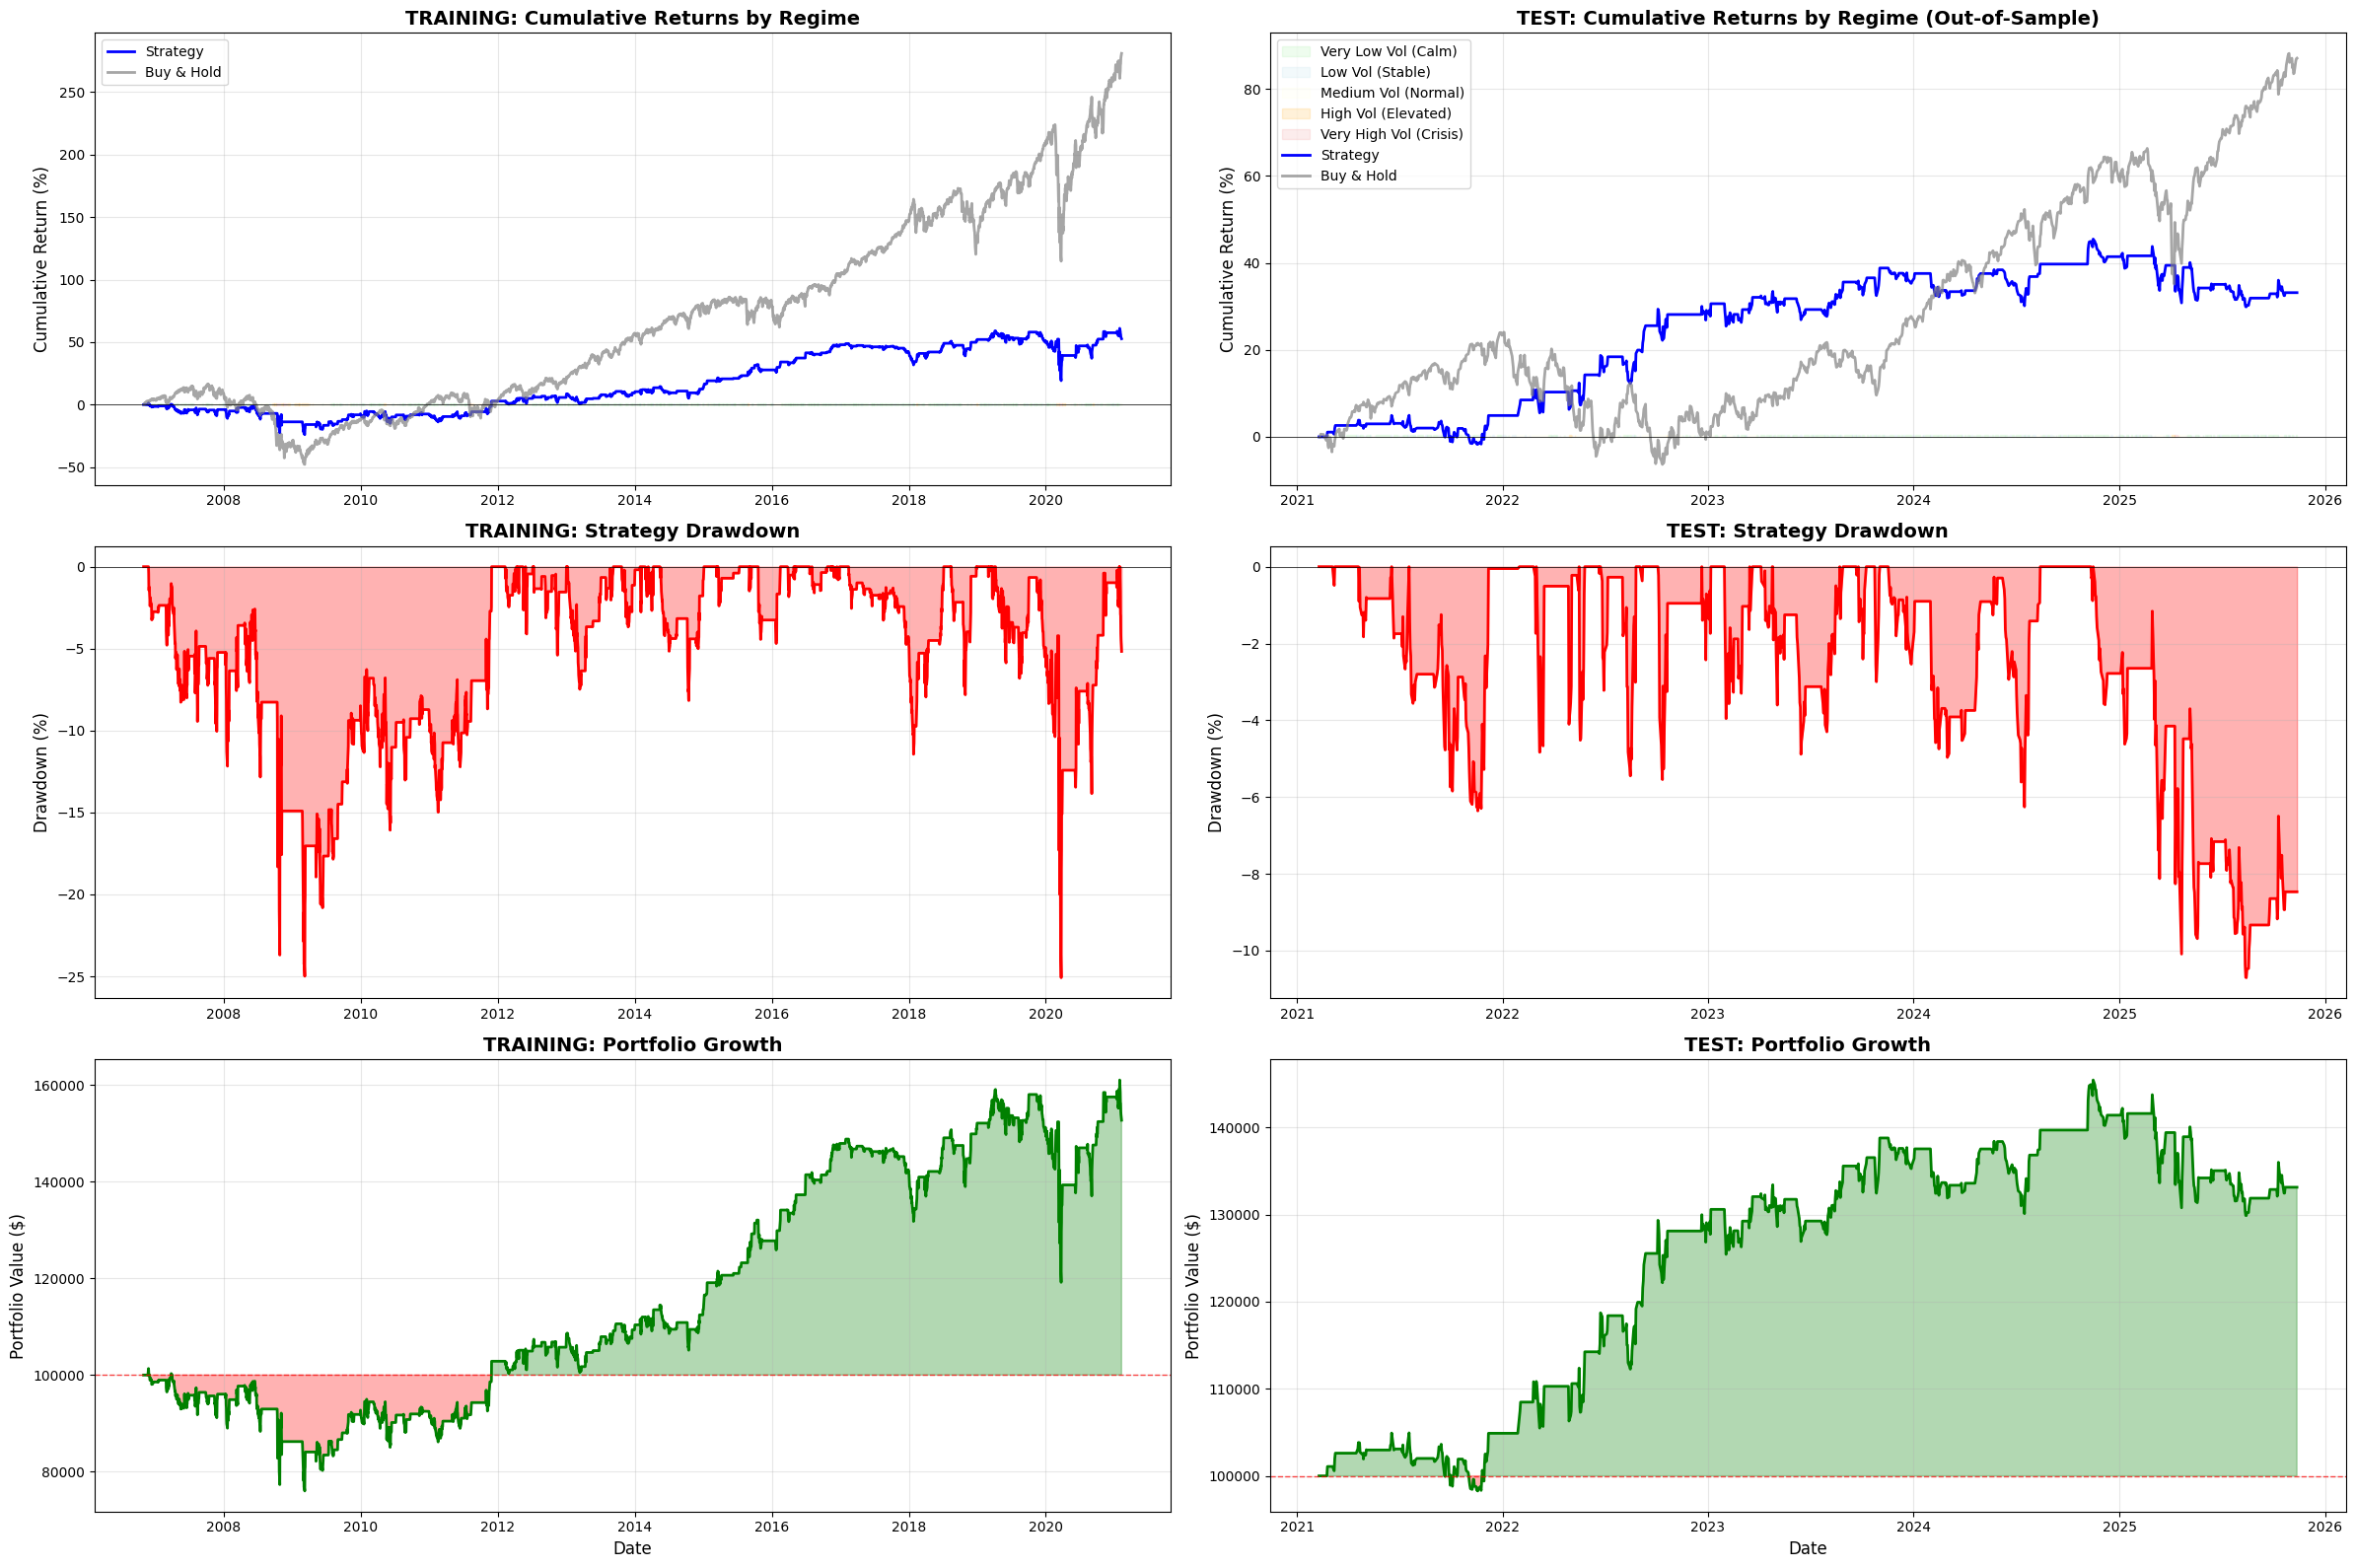


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                            52.71              33.14             280.95              87.04
Max Drawdown (%)                           -25.08             -10.70             -55.19             -24.50
Final Portfolio ($)            $       152,713.69 $       133,140.88 $       380,947.44 $       187,040.08


In [43]:
# ============================================================
# VISUALIZE TRAIN VS TEST COMPARISON WITH REGIME OVERLAY
# ============================================================

print("\n" + "="*70)
print("GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...")
print("="*70)

# Create regime names dict based on actual number of clusters
# Current setting: nclust = 5 (see line 316)
if nclust == 2:
    regime_names = {0: 'Low Vol', 1: 'High Vol'}
elif nclust == 3:
    regime_names = {0: 'Low Vol', 1: 'Med Vol', 2: 'High Vol'}
elif nclust == 4:
    regime_names = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Med Vol', 3: 'High Vol'}
elif nclust == 5:
    regime_names = {
        0: 'Very Low Vol (Calm)',
        1: 'Low Vol (Stable)', 
        2: 'Medium Vol (Normal)',
        3: 'High Vol (Elevated)',
        4: 'Very High Vol (Crisis)'
    }
else:
    regime_names = {i: f'Regime {i}' for i in range(nclust)}

# Call the comparison visualization
mr_rsi_viz_regime_aware_backtest_comparison(
    train_unified_results,
    test_unified_results,
    regime_names_dict=regime_names
)

In [44]:
# ============================================================
# VISUALIZE TRAINING DATA SIGNALS WITH REGIME OVERLAY (YEAR BY YEAR)
# ============================================================

# print("\n" + "="*70)
# print("TRAINING DATA: Entry/Exit Signals with Regime Background (Year by Year)")
# print("="*70)

# # Get unique years in training data
# train_years = train_unified_results.index.year.unique()
# print(f"\nTraining data spans {len(train_years)} years: {train_years.min()} - {train_years.max()}")
# print(f"Generating {len(train_years)} separate visualizations...\n")

# # Visualize each year separately
# for year in sorted(train_years):
#     print(f"\n{'='*70}")
#     print(f"YEAR {year}")
#     print(f"{'='*70}")
    
#     # Define start and end date for the year
#     start_date = f'{year}-01-01'
#     end_date = f'{year}-12-31'
    
#     # Filter data for this year
#     year_data = train_unified_results[train_unified_results.index.year == year]
    
#     if len(year_data) > 0:
#         print(f"Trading days: {len(year_data)}")
#         print(f"Date range: {year_data.index[0].strftime('%Y-%m-%d')} to {year_data.index[-1].strftime('%Y-%m-%d')}")
        
#         # Visualize this year
#         mr_ris_viz_regime_aware_backtest_signals(
#             train_unified_results,
#             start_date=start_date,
#             end_date=end_date,
#             regime_names_dict=regime_names
#         )
#     else:
#         print(f"No data available for {year}")

# print("\n" + "="*70)
# print("COMPLETED: All training yearly visualizations generated")
# print("="*70)


TEST DATA: Entry/Exit Signals with Regime Background (Year by Year)

Test data spans 5 years: 2021 - 2025
Generating 5 separate visualizations...


YEAR 2021
Trading days: 227
Date range: 2021-02-09 to 2021-12-31


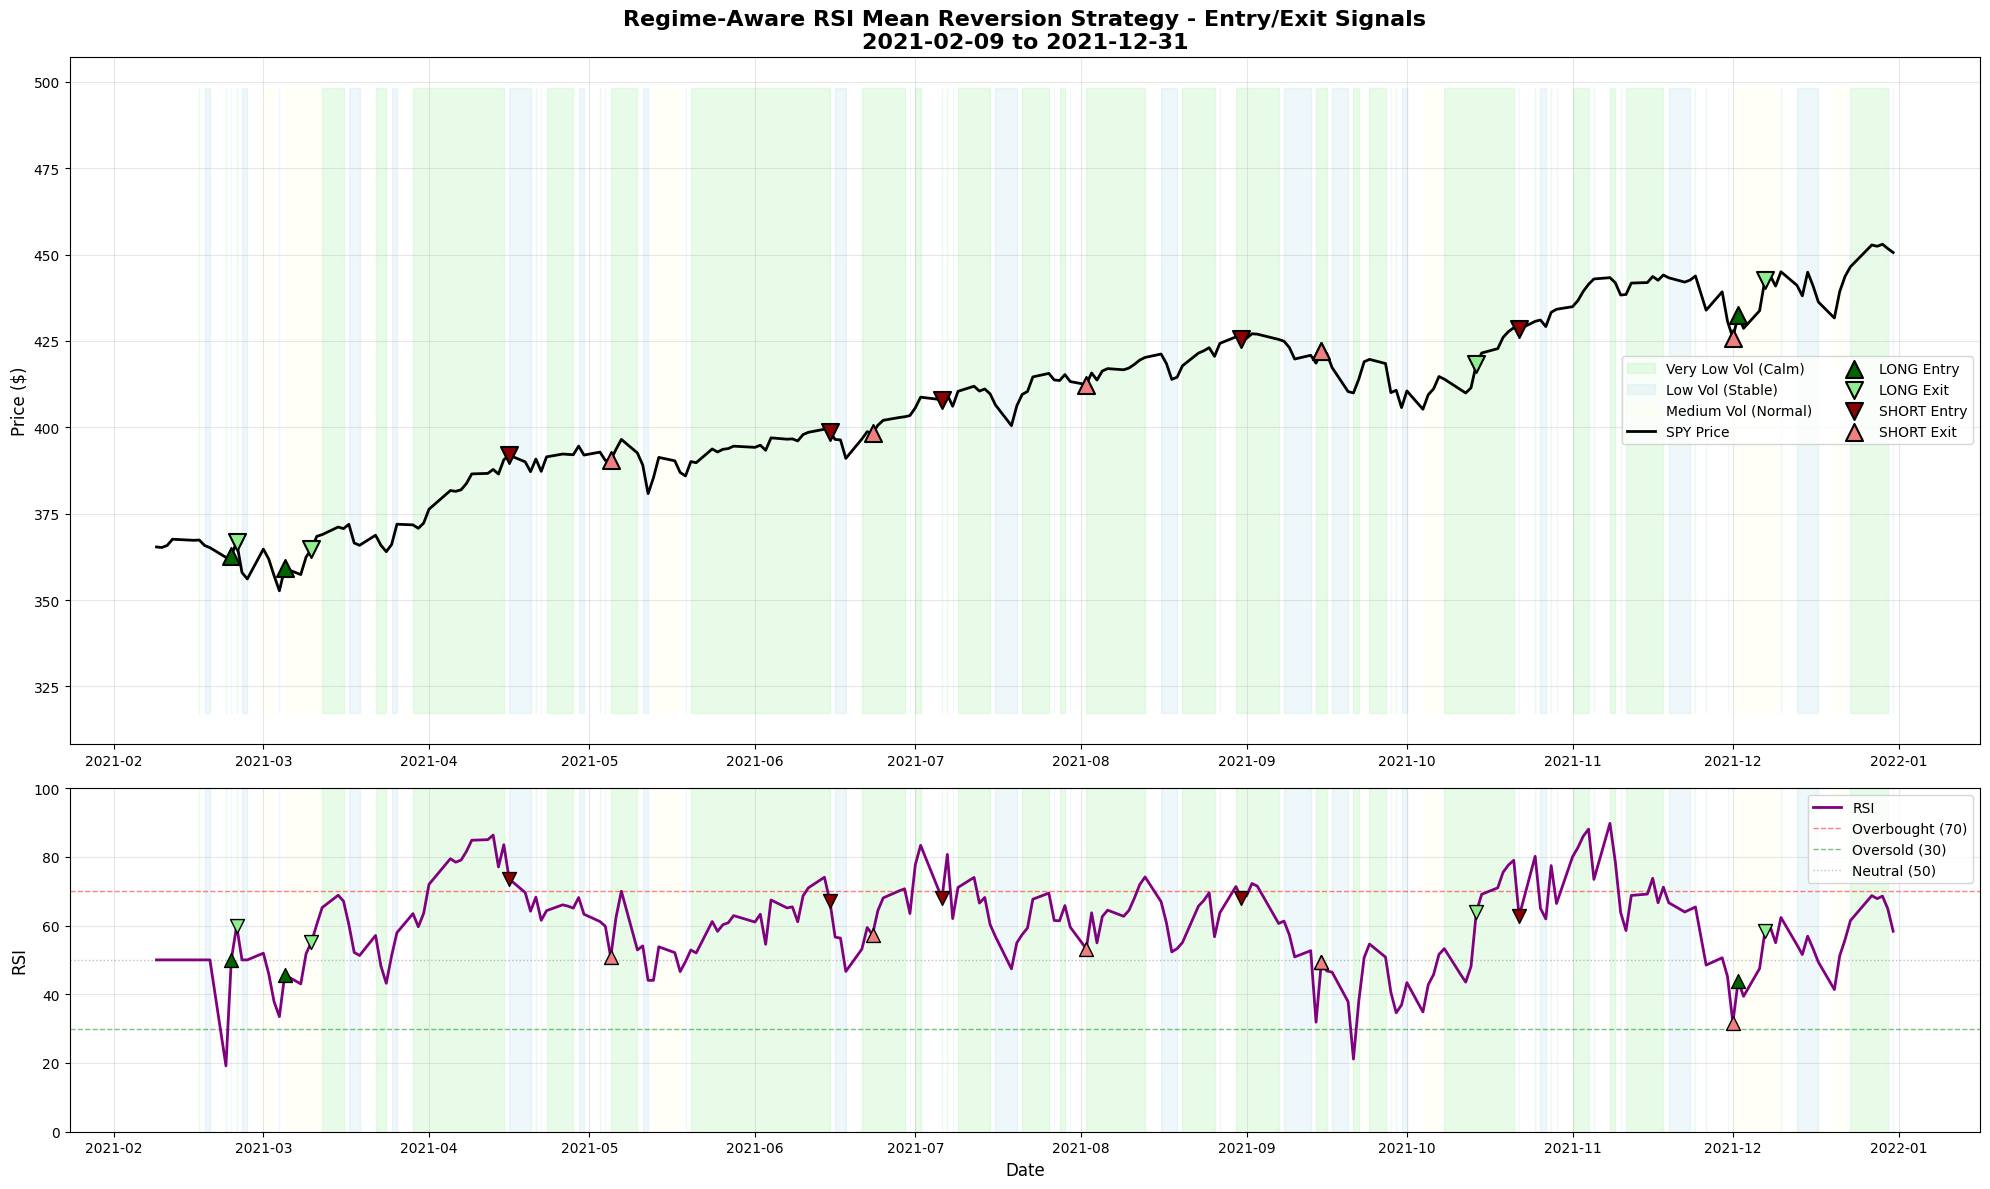


SIGNAL SUMMARY
Long Entries:  4
Long Exits:    4
Short Entries: 5
Short Exits:   5
Total Signals: 18

YEAR 2022
Trading days: 251
Date range: 2022-01-03 to 2022-12-30


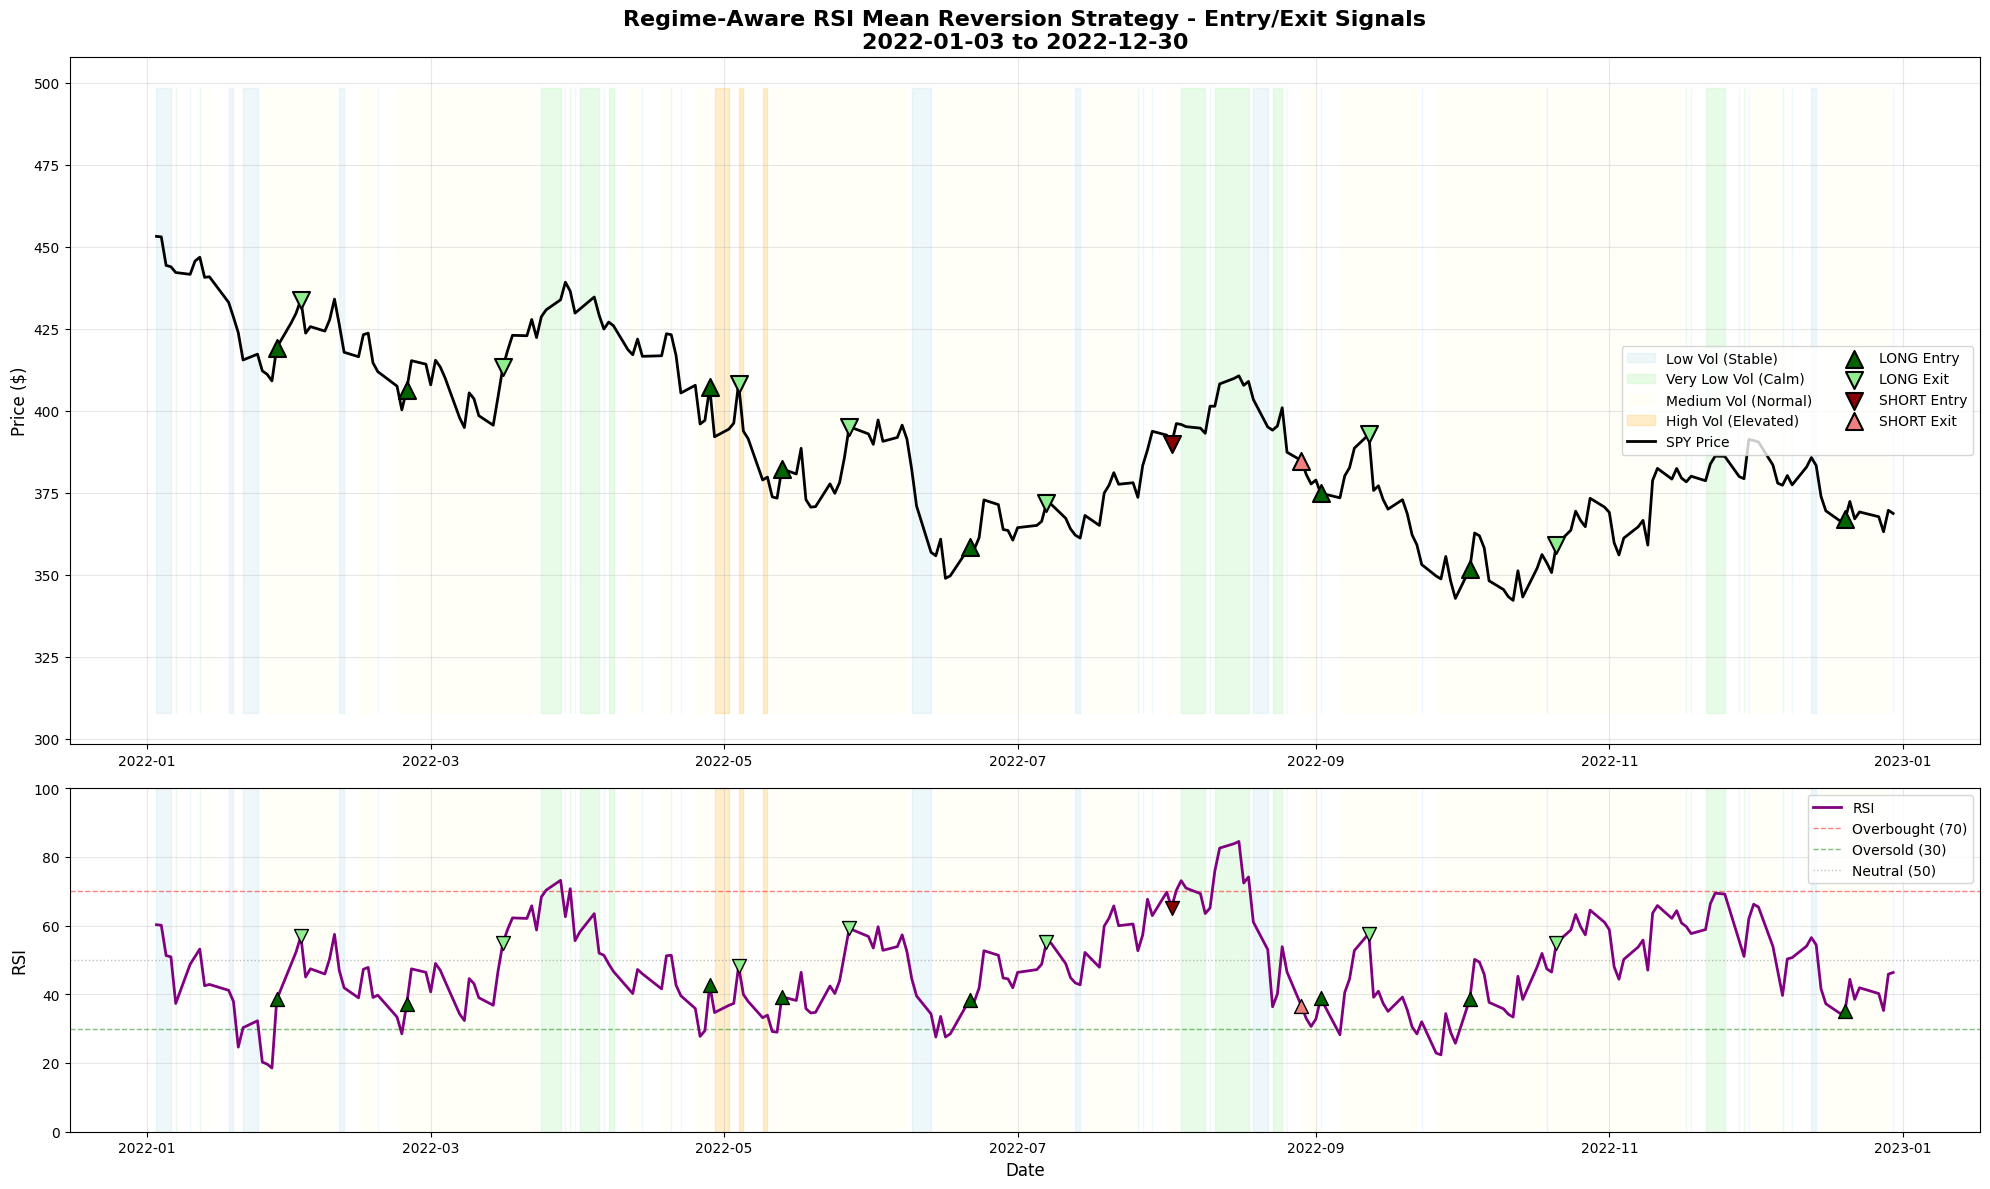


SIGNAL SUMMARY
Long Entries:  8
Long Exits:    7
Short Entries: 1
Short Exits:   1
Total Signals: 17

YEAR 2023
Trading days: 250
Date range: 2023-01-03 to 2023-12-29


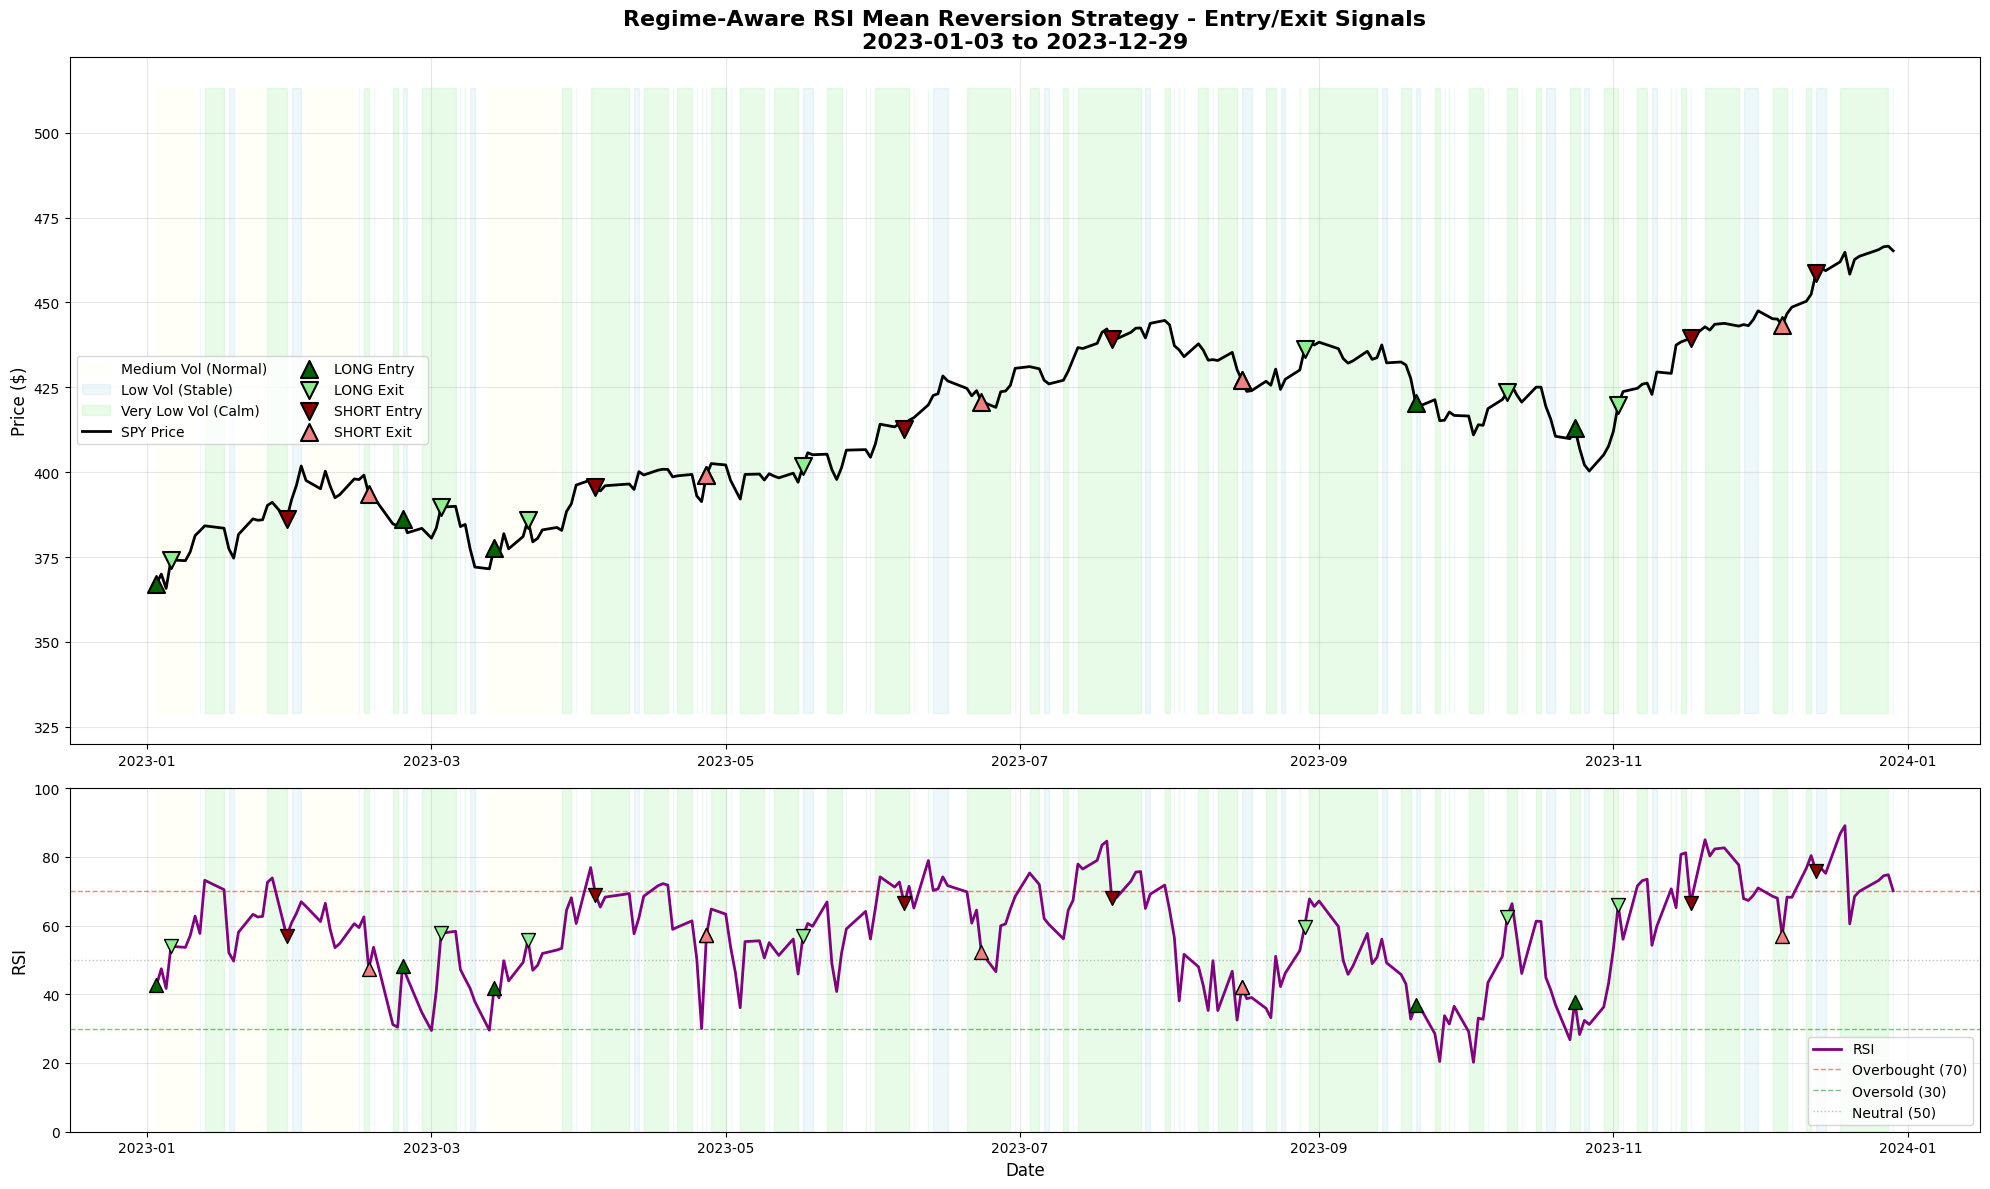


SIGNAL SUMMARY
Long Entries:  7
Long Exits:    7
Short Entries: 6
Short Exits:   5
Total Signals: 25

YEAR 2024
Trading days: 252
Date range: 2024-01-02 to 2024-12-31


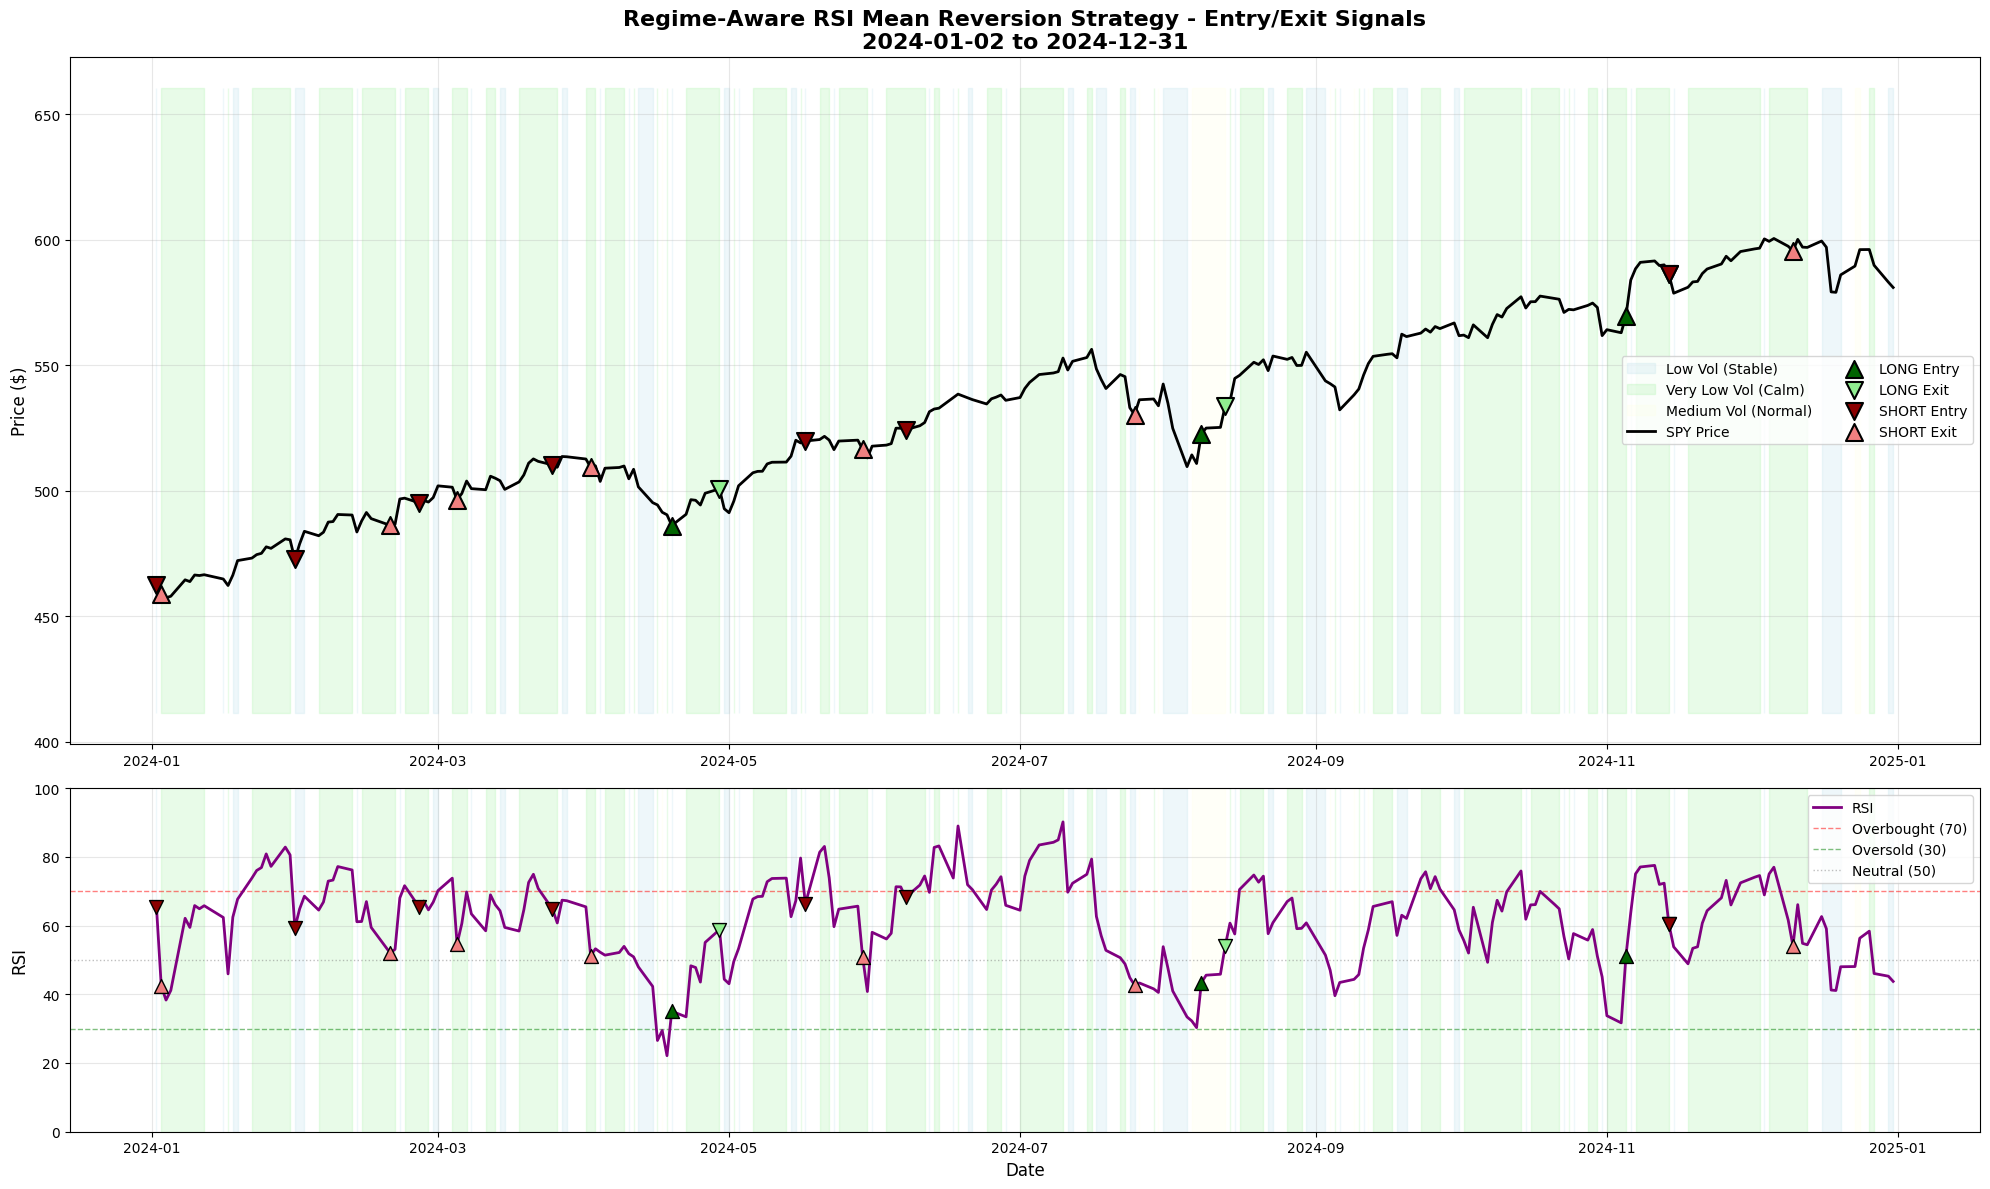


SIGNAL SUMMARY
Long Entries:  3
Long Exits:    3
Short Entries: 7
Short Exits:   7
Total Signals: 20

YEAR 2025
Trading days: 217
Date range: 2025-01-02 to 2025-11-12


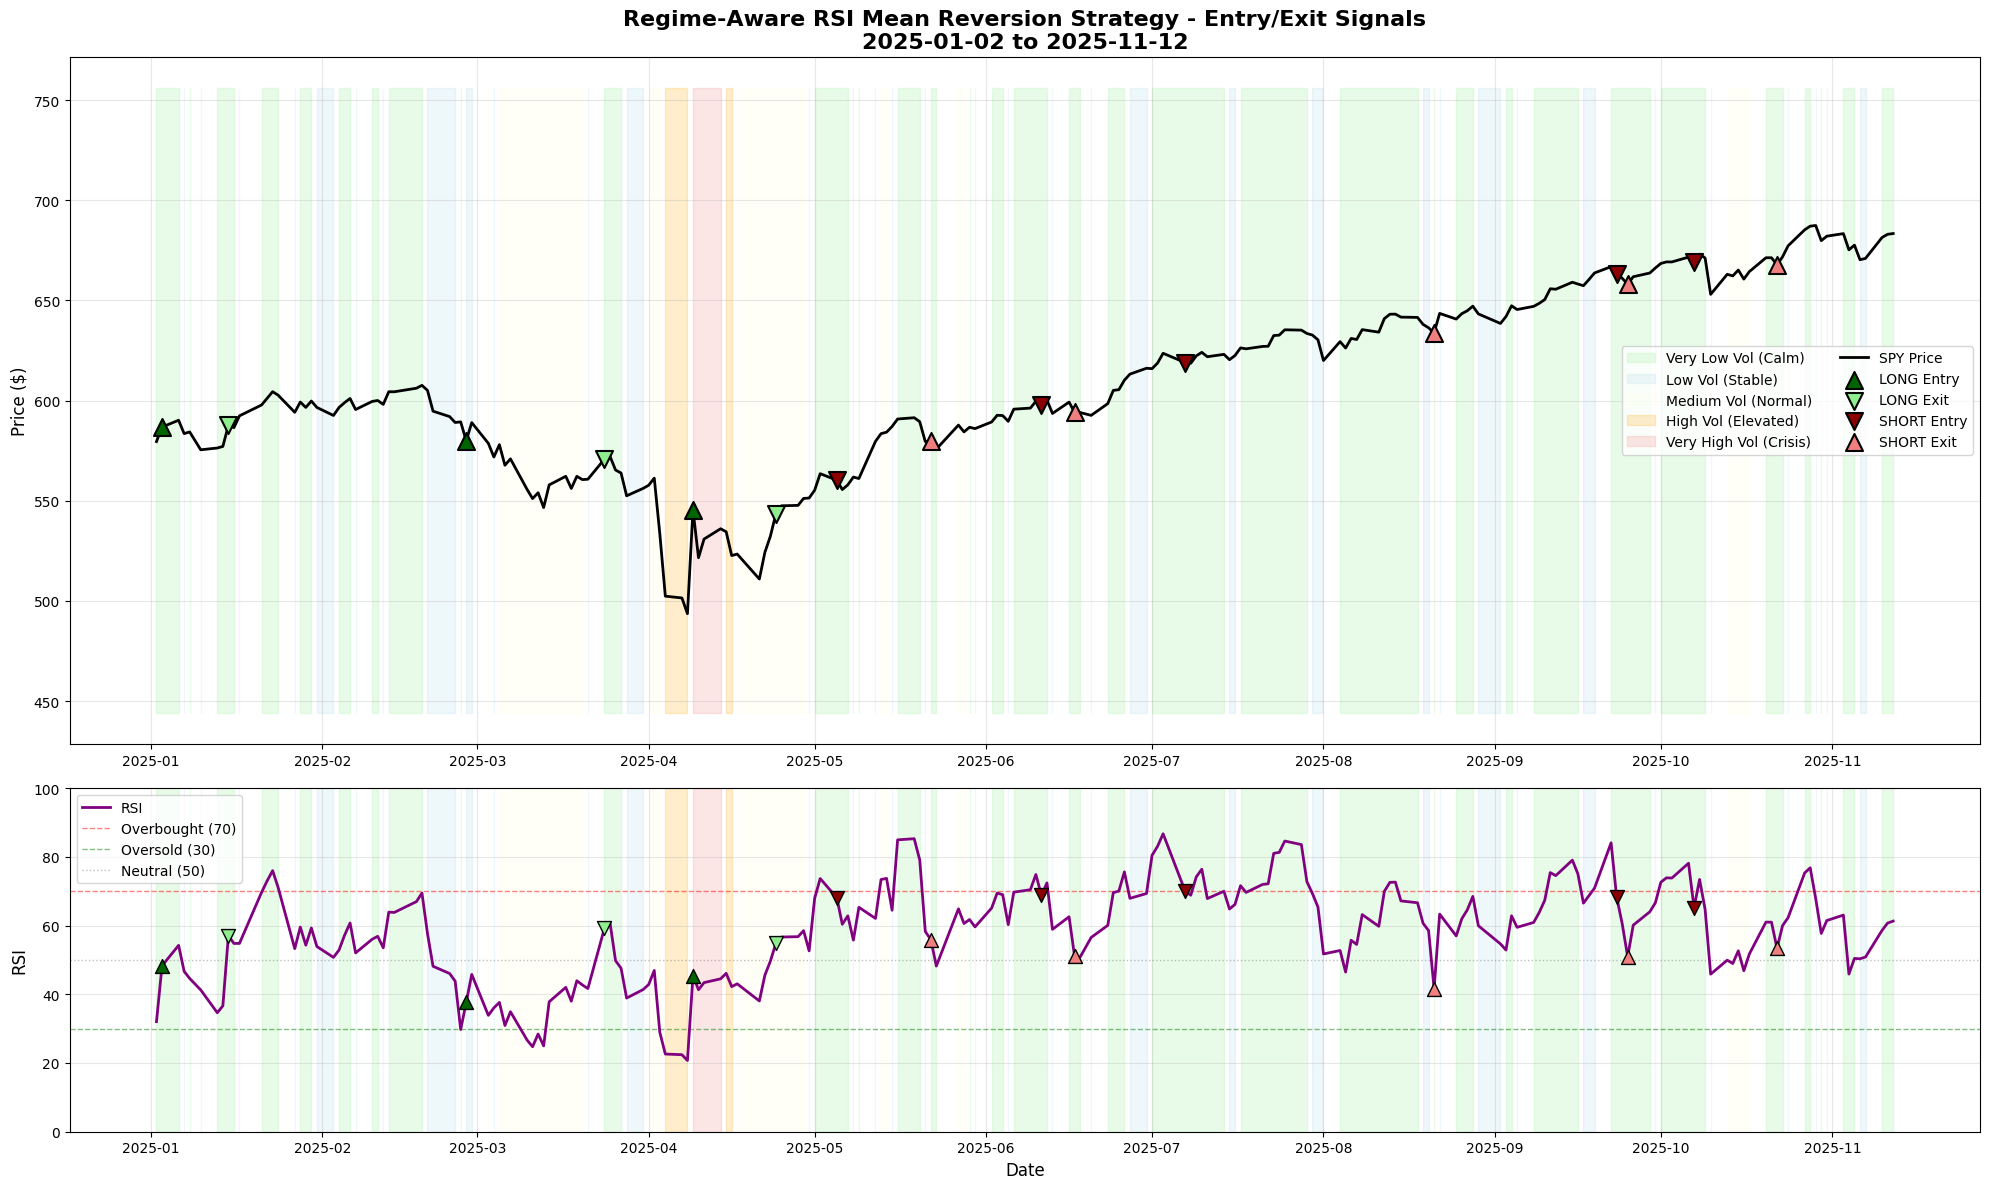


SIGNAL SUMMARY
Long Entries:  3
Long Exits:    3
Short Entries: 5
Short Exits:   5
Total Signals: 16

COMPLETED: All yearly visualizations generated


In [45]:
# ============================================================
# VISUALIZE TEST DATA SIGNALS WITH REGIME OVERLAY (YEAR BY YEAR)
# ============================================================

print("\n" + "="*70)
print("TEST DATA: Entry/Exit Signals with Regime Background (Year by Year)")
print("="*70)

# Get unique years in test data
test_years = test_unified_results.index.year.unique()
print(f"\nTest data spans {len(test_years)} years: {test_years.min()} - {test_years.max()}")
print(f"Generating {len(test_years)} separate visualizations...\n")

# Visualize each year separately
for year in sorted(test_years):
    print(f"\n{'='*70}")
    print(f"YEAR {year}")
    print(f"{'='*70}")
    
    # Define start and end date for the year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter data for this year
    year_data = test_unified_results[test_unified_results.index.year == year]
    
    if len(year_data) > 0:
        print(f"Trading days: {len(year_data)}")
        print(f"Date range: {year_data.index[0].strftime('%Y-%m-%d')} to {year_data.index[-1].strftime('%Y-%m-%d')}")
        
        # Visualize this year
        mr_ris_viz_regime_aware_backtest_signals(
            test_unified_results,
            start_date=start_date,
            end_date=end_date,
            regime_names_dict=regime_names
        )
    else:
        print(f"No data available for {year}")

print("\n" + "="*70)
print("COMPLETED: All yearly visualizations generated")
print("="*70)

In [46]:
# ============================================================
# TRADE-BY-TRADE TRACKING AND ANALYSIS FUNCTION
# ============================================================

def get_trade_details(df_results, initial_cash=100000, sort_by='pnl', ascending=False):
    df = df_results.copy()
    
    # Ensure we have the signal column
    if 'signal' not in df.columns:
        print("ERROR: 'signal' column not found in DataFrame")
        return pd.DataFrame()
    
    trades = []
    current_signal = 0
    entry_idx = None
    entry_price = None
    entry_portfolio_value = None
    entry_shares = None
    trade_id = 0
    
    for idx, row in df.iterrows():
        if row['signal'] != current_signal:
            # Position changed - close previous trade if exists
            if current_signal != 0 and entry_idx is not None:
                exit_idx = idx
                exit_price = row['Adj_Close']
                exit_portfolio_value = row['portfolio_value'] if 'portfolio_value' in df.columns else None
                
                # Calculate trade P&L
                if 'pnl' in df.columns:
                    # Sum P&L from entry to exit
                    trade_pnl = df.loc[entry_idx:exit_idx, 'pnl'].sum()
                else:
                    # Calculate manually from price changes
                    if current_signal == 1:  # Long
                        trade_pnl = entry_shares * (exit_price - entry_price)
                    else:  # Short
                        trade_pnl = entry_shares * (entry_price - exit_price)
                
                # Calculate return percentage
                if entry_portfolio_value and entry_portfolio_value > 0:
                    return_pct = (trade_pnl / entry_portfolio_value) * 100
                else:
                    return_pct = 0
                
                # Calculate duration
                duration_days = (exit_idx - entry_idx).days
                
                # Get regime information if available
                regime_at_entry = df.loc[entry_idx, 'regime'] if 'regime' in df.columns else None
                regime_at_exit = df.loc[exit_idx, 'regime'] if 'regime' in df.columns else None
                
                trades.append({
                    'trade_id': trade_id,
                    'entry_date': entry_idx,
                    'exit_date': exit_idx,
                    'direction': 'Long' if current_signal == 1 else 'Short',
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'shares': abs(entry_shares) if entry_shares else 0,
                    'duration_days': duration_days,
                    'pnl': trade_pnl,
                    'return_pct': return_pct,
                    'portfolio_value_at_entry': entry_portfolio_value,
                    'portfolio_value_at_exit': exit_portfolio_value,
                    'regime_at_entry': regime_at_entry,
                    'regime_at_exit': regime_at_exit
                })
                
                trade_id += 1
            
            # Start new trade if entering position
            if row['signal'] != 0:
                entry_idx = idx
                entry_price = row['Adj_Close']
                entry_portfolio_value = row['portfolio_value'] if 'portfolio_value' in df.columns else initial_cash
                entry_shares = row['shares'] if 'shares' in df.columns else 0
            
            current_signal = row['signal']
    
    # Convert to DataFrame
    trades_df = pd.DataFrame(trades)
    
    if len(trades_df) == 0:
        print("No trades found in the data")
        return trades_df
    
    # Sort by specified column
    if sort_by in trades_df.columns:
        trades_df = trades_df.sort_values(by=sort_by, ascending=ascending)
    
    return trades_df

In [47]:
# ============================================================
# TRADE ANALYSIS HELPER FUNCTIONS
# ============================================================

def analyze_top_trades(df_results, top_n=10, trade_type='best'):

    trades_df = get_trade_details(df_results, sort_by='pnl', ascending=(trade_type=='worst'))
    
    if len(trades_df) == 0:
        print("No trades to analyze")
        return
    
    print("\n" + "="*100)
    print(f"TOP {top_n} {trade_type.upper()} TRADES")
    print("="*100)
    
    display_df = trades_df.head(top_n).copy()
    
    # Format for better display
    display_df['entry_date'] = display_df['entry_date'].dt.strftime('%Y-%m-%d')
    display_df['exit_date'] = display_df['exit_date'].dt.strftime('%Y-%m-%d')
    display_df['pnl'] = display_df['pnl'].apply(lambda x: f"${x:,.2f}")
    display_df['return_pct'] = display_df['return_pct'].apply(lambda x: f"{x:.2f}%")
    display_df['portfolio_value_at_exit'] = display_df['portfolio_value_at_exit'].apply(lambda x: f"${x:,.2f}")
    
    display(display_df[['trade_id', 'entry_date', 'exit_date', 'direction', 
                       'duration_days', 'pnl', 'return_pct', 'portfolio_value_at_exit']])
    
    print("="*100)


def trade_summary_stats(df_results):
    trades_df = get_trade_details(df_results)
    
    if len(trades_df) == 0:
        print("No trades to summarize")
        return
    
    print("\n" + "="*70)
    print("TRADE SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\nTotal Trades: {len(trades_df)}")
    print(f"Long Trades:  {len(trades_df[trades_df['direction'] == 'Long'])}")
    print(f"Short Trades: {len(trades_df[trades_df['direction'] == 'Short'])}")
    
    print(f"\n{'PROFIT/LOSS BREAKDOWN':-^70}")
    winning_trades = trades_df[trades_df['pnl'] > 0]
    losing_trades = trades_df[trades_df['pnl'] <= 0]
    
    print(f"Winning Trades: {len(winning_trades)} ({len(winning_trades)/len(trades_df)*100:.1f}%)")
    print(f"  Average Win:  ${winning_trades['pnl'].mean():,.2f}")
    print(f"  Largest Win:  ${winning_trades['pnl'].max():,.2f}")
    
    print(f"\nLosing Trades:  {len(losing_trades)} ({len(losing_trades)/len(trades_df)*100:.1f}%)")
    print(f"  Average Loss: ${losing_trades['pnl'].mean():,.2f}")
    print(f"  Largest Loss: ${losing_trades['pnl'].min():,.2f}")
    
    print(f"\n{'DURATION STATISTICS':-^70}")
    print(f"Average Duration: {trades_df['duration_days'].mean():.1f} days")
    print(f"Shortest Trade:   {trades_df['duration_days'].min()} days")
    print(f"Longest Trade:    {trades_df['duration_days'].max()} days")
    
    print(f"\n{'RETURN STATISTICS':-^70}")
    print(f"Average Return:   {trades_df['return_pct'].mean():.2f}%")
    print(f"Best Return:      {trades_df['return_pct'].max():.2f}%")
    print(f"Worst Return:     {trades_df['return_pct'].min():.2f}%")
    
    print("="*70)

In [48]:
# ============================================================
# ANALYZE TEST DATA TRADES
# ============================================================

print("\n" + "="*70)
print("ANALYZING TEST DATA TRADES")
print("="*70)

# Get all trade details
test_trades = get_trade_details(test_unified_results, sort_by='pnl', ascending=False)

print(f"\nFound {len(test_trades)} trades in test data")
print(f"Date range: {test_unified_results.index[0].strftime('%Y-%m-%d')} to {test_unified_results.index[-1].strftime('%Y-%m-%d')}")

# Show summary statistics
trade_summary_stats(test_unified_results)

# Show top 10 best trades
analyze_top_trades(test_unified_results, top_n=10, trade_type='best')

# Show top 10 worst trades
analyze_top_trades(test_unified_results, top_n=10, trade_type='worst')

# Save to CSV for detailed analysis (sorted by P&L)
test_trades.to_csv(os.path.join('test_trades_detailed.csv'), index=False)
print(f"\n✅ Detailed trade data saved to: test_trades_detailed.csv")

# Display first 20 trades chronologically
print("\n" + "="*100)
print("FIRST 20 TRADES (Chronological Order - Earliest Entry Dates)")
print("="*100)
test_trades_chronological = test_trades.sort_values('entry_date', ascending=True)
display(test_trades_chronological.head(20))

# Display last 20 trades chronologically
print("\n" + "="*100)
print("LAST 20 TRADES (Chronological Order - Most Recent Entry Dates)")
print("="*100)
display(test_trades_chronological.tail(20))



ANALYZING TEST DATA TRADES

Found 47 trades in test data
Date range: 2021-02-09 to 2025-11-12

TRADE SUMMARY STATISTICS

Total Trades: 47
Long Trades:  24
Short Trades: 23

------------------------PROFIT/LOSS BREAKDOWN-------------------------
Winning Trades: 32 (68.1%)
  Average Win:  $2,042.88
  Largest Win:  $6,319.40

Losing Trades:  15 (31.9%)
  Average Loss: $-1,676.47
  Largest Loss: $-4,730.82

-------------------------DURATION STATISTICS--------------------------
Average Duration: 16.3 days
Shortest Trade:   1 days
Longest Trade:    48 days

--------------------------RETURN STATISTICS---------------------------
Average Return:   0.74%
Best Return:      4.76%
Worst Return:     -3.40%

TOP 10 BEST TRADES


,trade_id,entry_date,exit_date,direction,duration_days,pnl,return_pct,portfolio_value_at_exit
25,25,2023-08-16,2023-08-29,Long,13,"$6,319.40",4.76%,"$135,579.67"
15,15,2022-09-02,2022-09-12,Long,10,"$5,603.22",4.67%,"$125,543.54"
13,13,2022-06-21,2022-07-07,Long,16,"$4,150.95",3.63%,"$118,398.93"
37,37,2024-11-05,2024-11-14,Long,9,"$3,948.00",2.83%,"$143,655.35"
33,33,2024-04-19,2024-04-29,Long,10,"$3,935.13",2.95%,"$137,538.00"
12,12,2022-05-13,2022-05-27,Long,14,"$3,646.59",3.30%,"$114,247.98"
9,9,2022-01-28,2022-02-02,Long,5,"$3,579.48",3.41%,"$108,473.62"
24,24,2023-07-20,2023-08-16,Short,27,"$3,508.15",2.71%,"$132,768.42"
36,36,2024-08-08,2024-08-13,Long,5,"$2,871.98",2.10%,"$139,707.35"
20,20,2023-03-14,2023-03-21,Long,7,"$2,810.65",2.17%,"$132,064.63"



TOP 10 WORST TRADES


,trade_id,entry_date,exit_date,direction,duration_days,pnl,return_pct,portfolio_value_at_exit
42,42,2025-05-05,2025-05-22,Short,17,"$-4,730.82",-3.40%,"$134,208.32"
30,30,2024-01-31,2024-02-20,Short,20,"$-3,871.77",-2.81%,"$133,676.60"
44,44,2025-07-07,2025-08-21,Short,45,"$-3,158.55",-2.34%,"$131,883.75"
23,23,2023-06-07,2023-06-23,Short,16,"$-2,496.88",-1.90%,"$129,260.26"
18,18,2023-01-30,2023-02-16,Short,17,"$-2,454.02",-1.88%,"$128,147.91"
40,40,2025-02-27,2025-03-24,Long,25,"$-2,189.89",-1.55%,"$139,418.89"
35,35,2024-06-07,2024-07-25,Short,48,"$-1,554.49",-1.12%,"$136,835.37"
28,28,2023-11-17,2023-12-06,Short,19,"$-1,195.82",-0.86%,"$137,603.02"
21,21,2023-04-04,2023-04-27,Short,23,"$-1,183.57",-0.90%,"$130,881.06"
4,4,2021-07-06,2021-08-02,Short,27,"$-1,084.70",-1.05%,"$102,007.88"



✅ Detailed trade data saved to: test_trades_detailed.csv

FIRST 20 TRADES (Chronological Order - Earliest Entry Dates)


,trade_id,entry_date,exit_date,direction,entry_price,exit_price,shares,duration_days,pnl,return_pct,portfolio_value_at_entry,portfolio_value_at_exit,regime_at_entry,regime_at_exit
0,0,2021-02-23,2021-02-24,Long,362.790985,366.788696,270,1,1079.382019,1.079382,100000.000000,101079.382019,1.0,0.0
1,1,2021-03-05,2021-03-10,Long,359.167755,364.738342,275,5,1531.911469,1.515553,101079.382019,102611.293488,2.0,2.0
2,2,2021-04-16,2021-05-05,Short,391.932800,390.514465,256,19,363.093750,0.353854,102611.293488,102974.387238,1.0,0.0
3,3,2021-06-15,2021-06-23,Short,398.714539,398.247345,253,8,118.199982,0.114786,102974.387238,103092.587219,0.0,0.0
4,4,2021-07-06,2021-08-02,Short,407.981964,412.373474,247,27,-1084.702972,-1.052164,103092.587219,102007.884247,1.0,0.0
5,5,2021-08-31,2021-09-15,Short,425.538483,422.070496,234,15,811.508972,0.795536,102007.884247,102819.393219,0.0,0.0
6,6,2021-09-15,2021-10-14,Long,422.070496,418.336395,238,29,-77.206909,-0.075090,102819.393219,101930.677338,0.0,0.0
7,7,2021-10-22,2021-12-01,Short,428.376526,425.899597,233,40,577.124390,0.566193,101930.677338,102507.801727,1.0,2.0
8,8,2021-12-02,2021-12-07,Long,432.422791,442.708710,232,5,2386.333252,2.327953,102507.801727,104894.134979,2.0,2.0
9,9,2022-01-28,2022-02-02,Long,419.284454,433.894592,245,5,3579.483795,3.412473,104894.134979,108473.618774,2.0,2.0



LAST 20 TRADES (Chronological Order - Most Recent Entry Dates)


,trade_id,entry_date,exit_date,direction,entry_price,exit_price,shares,duration_days,pnl,return_pct,portfolio_value_at_entry,portfolio_value_at_exit,regime_at_entry,regime_at_exit
27,27,2023-10-24,2023-11-02,Long,412.957367,419.907715,324,9,2251.912720,1.649186,136546.921600,138798.834320,0.0,0.0
28,28,2023-11-17,2023-12-06,Short,439.433105,443.303070,309,19,-1195.819061,-0.861548,138798.834320,137603.015259,1.0,0.0
29,29,2023-12-13,2024-01-03,Short,458.646545,458.832397,294,21,-54.640503,-0.039709,137603.015259,137548.374756,1.0,0.0
30,30,2024-01-31,2024-02-20,Short,472.623108,486.208282,285,20,-3871.774750,-2.814846,137548.374756,133676.600006,1.0,0.0
31,31,2024-02-26,2024-03-05,Short,495.242188,496.406921,264,8,-307.489746,-0.230025,133676.600006,133369.110260,0.0,0.0
32,32,2024-03-25,2024-04-02,Short,510.310242,509.397125,256,8,233.757813,0.175271,133369.110260,133602.868073,0.0,0.0
33,33,2024-04-19,2024-04-29,Long,486.148102,500.776855,269,10,3935.134735,2.945397,133602.868073,137538.002808,1.0,0.0
34,34,2024-05-17,2024-05-29,Short,519.813965,516.524963,259,12,851.851379,0.619357,137538.002808,138389.854187,1.0,0.0
35,35,2024-06-07,2024-07-25,Short,524.291077,530.316223,258,48,-1554.487793,-1.123267,138389.854187,136835.366394,0.0,1.0
36,36,2024-08-08,2024-08-13,Long,522.672974,533.891663,256,5,2871.984375,2.098861,136835.366394,139707.350769,2.0,2.0
